# MDMRT scan project data analysis

## Set up functions to run drift diffusion model fits and plot data with fits

In [1]:
# load all necessary packages
%load_ext rpy2.ipython
%R library(lme4)
%R library(sjPlot)
%R library(ggplot2)
%R library(plotrix)
%R library(Hmisc)

#%load_ext pymatbridge
from __future__ import division
from __future__ import print_function
from scipy.stats import norm
from scipy.signal import fftconvolve
import matplotlib.gridspec as gridspec
import brewer2mpl as b2mpl
import fminbnd
import os, glob, scipy
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import nilearn
from nilearn import image
from nilearn import plotting
import multiprocessing  
from joblib import Parallel, delayed
import pickle


# list of subject IDs
subjid=list(range(2,26))+list(range(27,32))+[33]

# path to data
datapath='../Output/'

eps = 2 ** -52

# a few global variables that speed up optimization
T = None
It = None
STIM_STRENGTH = None
Ic = None

sns.set_style('ticks')
sns.set_context('talk')


/Users/akram/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Matrix

  warnings.warn(x, RRuntimeWarning)
/Users/akram/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Install package "strengejacke" from GitHub (`devtools::install_github("strengejacke/strengejacke")`) to load all sj-packages at once!

  warnings.warn(x, RRuntimeWarning)
/Users/akram/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: lattice

  warnings.warn(x, RRuntimeWarning)
/Users/akram/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: survival

  warnings.warn(x, RRuntimeWarning)
/Users/akram/anaconda2/lib/python2.7/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Loading required package: Formula

  warnings.warn(x, RRuntimeWarning)
/Users/akram/anaconda2/lib/python2.7/sit

In [2]:
# Originally written by Luke Woloszyn in December 2015 (https://github.com/lwoloszy/behavior)
# Modified by Akram Bakkour in September 2017

def fitData(
        data, dt=.0005, k=5, B0=1.5, Bdel=1, B2=1,
        tnd=0.5, tnd_sd=0.05, stim_strength_bias=0, y0=0, plaw=1):

    """
    Fit choices and reaction times to a diffusion to bound model
    with exponentially and symmetrically decreasing bounds

    Parameters
    ----------
    data : 2D array of shape (N, 3) where N is number of trials
          and the columns correspond to stim_strength, rt, and choice

    dt : temporal resolution of the simulated diffusion process

    ########## The following are initial values of parameters ##############

    k : float, proportionality constant between stim_strength and drift rate

    B0 : float, initial bound height

    Bdelay : float, delay in seconds before bound starts decreasing

    B2 : float, coefficient of exponential term that governs bound decrease

    tnd: float, non decision time

    tnd_sd: float, standard deviation of non-decision time

    stim_strength_bias : bias in drift rate (added to stim_strength before k mult)

    y0 : initial offset of decision variable (relative to 0)
    
    plaw : power law coefficient for stim_strengths


    Returns
    -------
    theta : 1D array of 9 params -
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw

    """

    global T, It, STIM_STRENGTH, Ic
    T, It, STIM_STRENGTH, Ic = None, None, None, None

    stim_strengths = data[:, 0]
    rt = data[:, 1]
    ci = data[:, 2]

    # plausible bounds for the parameters
    theta_lo = [0.2, 0.5,  0,  0, 0.3 , 0 ,-0.2,  0, 1/20]
    theta_hi = [35,  4,    5,  3, 1   , 0.1  ,0.2, 0, 3]
    theta_init = [k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw]

    theta, fopt = fminbnd.fminbnd(
        calculateNegLL, theta_init, args=(stim_strengths, rt, ci, dt),
        LB=theta_lo, UB=theta_hi)

    # clear the globals
    T, It, STIM_STRENGTH, Ic = None, None, None, None

    return theta, fopt

In [3]:
# Originally written by Luke Woloszyn in December 2015 (https://github.com/lwoloszy/behavior)
# Modified by Akram Bakkour in September 2017

def plotDotsDataWithFit(data, theta, dt=.0005):
    """
    Given a  diffusion to bound model with exponentially collapsing bounds
    parametrized by theta, plot raw behavioral data and its dtb fit

    Parameters
    ----------
    data : 2D array of shape (N, 4) where N is total number of trials
           and the columns correspond to stim_strength, rt, and choice, subjid

    theta : 9 element list or array containing the fitted DTB parameters
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw

    dt : float, temporal resolution, in seconds, to use when propagating
         the stimulus strengths to visualize (for plotting only)

    Returns
    -------

    """

    colors = b2mpl.get_map('Set1', 'Qualitative', 3).mpl_colors

    fig = plt.figure()
    k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw = theta
    stim_strengths, rt, ci, subj = data[:, 0], data[:, 1], data[:, 2], data[:, 3]

    stim_strengths = stim_strengths.astype("complex") ** plaw
    ustim_strengths = np.unique(stim_strengths)
    stim_strengths_to_propagate = np.linspace(
        np.min(ustim_strengths), np.max(ustim_strengths), 51)

    drifts, t, Bup, Blo, y, yinit = discretize(
        theta, stim_strengths_to_propagate, np.max(rt), dt)

    D = propagate(drifts, t, Bup, Blo, y, yinit)

    meanprop = sortedFunc(ci, stim_strengths, 'mean')[:, 1]
    df=pd.DataFrame(data,columns=['stim_strength','rt','ci','subj'])  
    df['ci']=df['ci'].astype('bool')
    df['rt']=df['rt'].astype('float64')
    df['stim_strength']=stim_strengths
    # calculate participant means per subject
    smean = df.groupby(['subj','stim_strength'],as_index=False).mean()
    # SEM across participant means
    semprop = smean.groupby('stim_strength').sem()['ci']
    
    # predicted proportions
    predprop = D['up']['p'][:]

    #chose blue or chose yellow
    cb=df[df['ci']==1]
    cy=df[df['ci']==0]
    
    #means per participant per stim_strenght
    scbmeans=cb.groupby(['subj','stim_strength'],as_index=False).mean()
    scymeans=cy.groupby(['subj','stim_strength'],as_index=False).mean()
    bothmeans=df.groupby(['subj','stim_strength'],as_index=False).mean()
    del scymeans['ci'] 
    del scbmeans['ci'] 
    del bothmeans['ci']     
    
    meanrt_lo=cy.groupby(['stim_strength'],as_index=False).mean()['rt']
    meanrt_up=cb.groupby(['stim_strength'],as_index=False).mean()['rt']
    meanrt_both=df.groupby(['stim_strength'],as_index=False).mean()['rt']
    
    semrt_lo=scymeans.groupby('stim_strength').sem()['rt']
    semrt_up=scbmeans.groupby('stim_strength').sem()['rt']
    semrt_both=df.groupby('stim_strength').sem()['rt']
    

    predrt_up = D['up']['mean_t'][0] + tnd
    predrt_lo = D['lo']['mean_t'][0] + tnd
    predrt_both = D['both']['mean_t'][0] + tnd
    
    ax_choice = fig.add_subplot(1, 2, 1)
    ax_choice.errorbar(ustim_strengths, meanprop, yerr=semprop, color='grey',
                       linestyle='None', capsize=0, marker='o')
    ax_choice.add_line(
        plt.Line2D(stim_strengths_to_propagate, predprop, color='k'))

    xdata = stim_strengths_to_propagate
    ax_choice.set_xlim((np.min(xdata) * 1.2, np.max(xdata) * 1.2))
    ax_choice.set_ylim((-0.01, 1.01))
    ax_choice.set_xlabel('Color Coherence (yellow-to-blue)')
    ax_choice.set_ylabel('P(respond Blue)')

    ax_rt = fig.add_subplot(1, 2, 2)
    ax_rt.errorbar(ustim_strengths, meanrt_both, yerr=semrt_both,
                   color='grey', linestyle='None', marker='o', capsize=0)
    ax_rt.add_line(plt.Line2D(
        stim_strengths_to_propagate, predrt_both,
        color='k', marker='None'))

    ax_rt.set_xlabel('Color Coherence (yellow-to-blue)')
    ax_rt.set_ylabel('Reaction time (s)')

    ax_rt.set_xlim((np.min(xdata) * 1.2, np.max(xdata) * 1.2))
    ax_rt.set_ylim(np.nanmin(np.concatenate([meanrt_up, meanrt_lo])) * .75,
                   np.nanmax(np.concatenate([meanrt_up, meanrt_lo])) * 1.1)

    ax_rt.set_xlabel('Color Coherence (yellow-to-blue)')
    ax_rt.set_ylabel('Mean reaction times (s)')

    sns.despine(offset=5, trim=True)
    plt.tight_layout()
    plt.show()

In [4]:
# Originally written by Luke Woloszyn in December 2015 (https://github.com/lwoloszy/behavior)
# Modified by Akram Bakkour in September 2017

def plotDotsubDataWithFit(data, theta, subjid, dt=.0005):
    """
    Given a  diffusion to bound model with exponentially collapsing bounds
    parametrized by theta, plot raw behavioral data and its dtb fit

    Parameters
    ----------
    data : 2D array of shape (N, 4) where N is total number of trials
           and the columns correspond to stim_strength, rt, and choice, subjid

    theta : 9 element list or array containing the fitted DTB parameters
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw

    dt : float, temporal resolution, in seconds, to use when propagating
         the stimulus strengths to visualize (for plotting only)

    Returns
    -------

    """

    colors = b2mpl.get_map('Set1', 'Qualitative', 3).mpl_colors

    fig = plt.figure()
    
    k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw = theta
    stim_strengths, rt, ci = data[:, 0], data[:, 1], data[:, 2]

    stim_strengths = stim_strengths.astype("complex") ** plaw
    ustim_strengths = np.unique(stim_strengths) 
    stim_strengths_to_propagate = np.linspace(
        np.min(ustim_strengths), np.max(ustim_strengths), 51)

    drifts, t, Bup, Blo, y, yinit = discretize(
        theta, stim_strengths_to_propagate, np.max(rt), dt)

    D = propagate(drifts, t, Bup, Blo, y, yinit)

    meanprop = sortedFunc(ci, stim_strengths, 'mean')[:, 1]
    df=pd.DataFrame(data,columns=['stim_strength','rt','ci'])
    df['ci']=df['ci'].astype('bool')
    df['rt']=df['rt'].astype('float64')
    df['stim_strength']=stim_strengths
    
    # calculate stdev per stim strengh
    semprop = df.groupby(['stim_strength']).sem()['ci']
    
    # predicted proportions
    predprop = D['up']['p'][:]

    #chose blue or chose yellow
    cb=df[df['ci']==1]
    cy=df[df['ci']==0]
    
    meanrt_lo=cy.groupby(['stim_strength']).mean()['rt']
    meanrt_up=cb.groupby(['stim_strength']).mean()['rt']
    meanrt_both=df.groupby(['stim_strength']).mean()['rt']
    
    del cb['ci']
    del cy['ci']
    
    semrt_lo=cy.groupby(['stim_strength']).sem()['rt']
    semrt_up=cb.groupby(['stim_strength']).sem()['rt']
    semrt_both=df.groupby(['stim_strength']).sem()['rt']
    

    predrt_up = D['up']['mean_t'][0] + tnd
    predrt_lo = D['lo']['mean_t'][0] + tnd
    predrt_both = D['both']['mean_t'][0] + tnd
    
    ax_choice = fig.add_subplot(1, 2, 1)
    ax_choice.errorbar(ustim_strengths, meanprop, yerr=semprop, color='grey',
                       linestyle='None', capsize=0, marker='o')
    ax_choice.add_line(
        plt.Line2D(stim_strengths_to_propagate, predprop, color='k'))

    xdata = stim_strengths_to_propagate
    ax_choice.set_xlim((np.min(xdata) * 1.2, np.max(xdata) * 1.2))
    ax_choice.set_ylim((-0.01, 1.01))
    ax_choice.set_xlabel('Color Coherence (yellow-to-blue)')
    ax_choice.set_ylabel('P(respond Blue)')
    
    plt.title('Perceptual choices for participant ' + subjid)
    
    ax_rt = fig.add_subplot(1, 2, 2)
    ustim_strengths=np.array(meanrt_both.index)
    ax_rt.errorbar(ustim_strengths, meanrt_both, yerr=semrt_both,
                   color='grey', linestyle='None', marker='o', capsize=0)
    ax_rt.add_line(plt.Line2D(
        stim_strengths_to_propagate, predrt_both,
        color='k', marker='None'))

    ax_rt.set_xlabel('Color Coherence (yellow-to-blue)')
    ax_rt.set_ylabel('Reaction time (s)')

    ax_rt.set_xlim((np.min(xdata) * 1.2, np.max(xdata) * 1.2))
    ax_rt.set_ylim(np.nanmin(np.concatenate([meanrt_up, meanrt_lo])) * .75,
                   np.nanmax(np.concatenate([meanrt_up, meanrt_lo])) * 1.1)

    ax_rt.set_xlabel('Color Coherence (yellow-to-blue)')
    ax_rt.set_ylabel('Mean reaction times (s)')

    sns.despine(offset=5, trim=True)
    plt.tight_layout()
    plt.title('Perceptual RT for participant ' + subjid)
    plt.show()
    

In [5]:
# Originally written by Luke Woloszyn in December 2015 (https://github.com/lwoloszy/behavior)
# Modified by Akram Bakkour in September 2017

def plotFoodDataWithFit(data, theta, dt=.0005):
    """
    Given a  diffusion to bound model with exponentially collapsing bounds
    parametrized by theta, plot raw behavioral data and its dtb fit

    Parameters
    ----------
    data : 2D array of shape (N, 3) where N is total number of trials
           and the columns correspond to stim_strength, rt, and choice, subjid

    theta : 9 element list or array containing the fitted DTB parameters
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw

    dt : float, temporal resolution, in seconds, to use when propagating
         the stimulus strengths to visualize (for plotting only)

    Returns
    -------

    """

    colors = b2mpl.get_map('Set1', 'Qualitative', 3).mpl_colors

    fig = plt.figure()
    k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw = theta
    stim_strengths, rt, ci, subj = data[:, 0], data[:, 1], data[:, 2], data[:, 3]

    stim_strengths = stim_strengths.astype("complex") ** plaw
    ustim_strengths = np.unique(stim_strengths)
    stim_strengths_to_propagate = np.linspace(
        np.min(ustim_strengths), np.max(ustim_strengths), 51)

    drifts, t, Bup, Blo, y, yinit = discretize(
        theta, stim_strengths_to_propagate, np.max(rt), dt)

    D = propagate(drifts, t, Bup, Blo, y, yinit)

    df=pd.DataFrame(data,columns=['stim_strength','rt','ci','subj','deltaval'])  
    df['ci']=df['ci'].astype('bool')
    df['rt']=df['rt'].astype('float64')
    
    dfsorted=df.sort_values('deltaval', ascending=True)
    
    #running mean of choices
    meanprop = pd.Series.rolling(dfsorted['ci'],100,min_periods=1).mean()

    # predicted proportions
    predprop = D['up']['p'][:]

    #chose right or chose left
    cr=dfsorted[dfsorted['ci']==1]
    cl=dfsorted[dfsorted['ci']==0]
    
    #running mean of rt
    meanrt_lo = pd.Series.rolling(cl['rt'],50,min_periods=1).mean()
    meanrt_up = pd.Series.rolling(cr['rt'],50,min_periods=1).mean()
    meanrt_both = pd.Series.rolling(dfsorted['rt'],100,min_periods=1).mean()

    predrt_up = D['up']['mean_t'][0] + tnd
    predrt_lo = D['lo']['mean_t'][0] + tnd
    predrt_both = D['both']['mean_t'][0] + tnd
    
    ax_choice = fig.add_subplot(1, 2, 1)
    ax_choice.add_line(
        plt.Line2D(dfsorted['deltaval'], meanprop, color='grey'))
    ax_choice.add_line(
        plt.Line2D(stim_strengths_to_propagate, predprop, color='k'))

    xdata = stim_strengths_to_propagate
    ax_choice.set_xlim((np.min(xdata) * 1.2, np.max(xdata) * 1.2))
    ax_choice.set_ylim((-0.01, 1.01))
    ax_choice.set_xlabel('DeltaValue (Right - Left)')
    ax_choice.set_ylabel('P(respond Right)')

    ax_rt = fig.add_subplot(1, 2, 2)
    ax_rt.add_line(
        plt.Line2D(dfsorted['deltaval'], meanrt_both, color='grey'))
    ax_rt.add_line(plt.Line2D(
        stim_strengths_to_propagate, predrt_both,
        color='k', marker='None'))

    ax_rt.set_xlabel('DeltaValue (Right - Left)')
    ax_rt.set_ylabel('Reaction time (s)')

    ax_rt.set_xlim((np.min(xdata) * 1.2, np.max(xdata) * 1.2))
    ax_rt.set_ylim(np.nanmin(np.concatenate([meanrt_up, meanrt_lo])) * .75,
                   np.nanmax(np.concatenate([meanrt_up, meanrt_lo])) * 1.1)

    ax_rt.set_xlabel('DeltaValue (Right - Left)')
    ax_rt.set_ylabel('Mean reaction times (s)')

    sns.despine(offset=5, trim=True)
    plt.tight_layout()
    plt.show()

In [6]:
# Originally written by Luke Woloszyn in December 2015 (https://github.com/lwoloszy/behavior)
# Modified by Akram Bakkour in September 2017

def plotFoodsubDataWithFit(data, theta, subjid, dt=.0005):
    """
    Given a  diffusion to bound model with exponentially collapsing bounds
    parametrized by theta, plot raw behavioral data and its dtb fit

    Parameters
    ----------
    data : 2D array of shape (N, 3) where N is total number of trials
           and the columns correspond to stim_strength, rt, and choice, subjid

    theta : 9 element list or array containing the fitted DTB parameters
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw

    subjid : subject id

    dt : float, temporal resolution, in seconds, to use when propagating
         the stimulus strengths to visualize (for plotting only)

    Returns
    -------

    """

    colors = b2mpl.get_map('Set1', 'Qualitative', 3).mpl_colors

    fig = plt.figure()
    k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw = theta
    stim_strengths, rt, ci, deltaval = data[:, 0], data[:, 1], data[:, 2], data[:, 3]
    
    stim_strengths = stim_strengths.astype("complex") ** plaw
    ustim_strengths = np.unique(stim_strengths)
    stim_strengths_to_propagate = np.linspace(
        np.min(ustim_strengths), np.max(ustim_strengths), 51)

    drifts, t, Bup, Blo, y, yinit = discretize(
        theta, stim_strengths_to_propagate, np.max(rt), dt)

    D = propagate(drifts, t, Bup, Blo, y, yinit)

    df=pd.DataFrame(data,columns=['stim_strength','rt','ci','deltaval'])  
    df['ci']=df['ci'].astype('bool')
    df['rt']=df['rt'].astype('float64')
    df['stim_strength']=stim_strengths
    
    dfsorted=df.sort_values('deltaval', ascending=True)
    
    #running mean of choices
    meanprop = pd.Series.rolling(dfsorted['ci'],10,min_periods=1).mean()

    # predicted proportions
    predprop = D['up']['p'][:]

    #chose right or chose left
    cr=dfsorted[dfsorted['ci']==1]
    cl=dfsorted[dfsorted['ci']==0]
    
   
    #running mean of rt
    meanrt_lo = pd.Series.rolling(cl['rt'],10,min_periods=1).mean()
    meanrt_up = pd.Series.rolling(cr['rt'],10,min_periods=1).mean()
    meanrt_both = pd.Series.rolling(dfsorted['rt'],10,min_periods=1).mean()

    predrt_up = D['up']['mean_t'][0] + tnd
    predrt_lo = D['lo']['mean_t'][0] + tnd
    predrt_both=D['both']['mean_t'][0] + tnd
    
    ax_choice = fig.add_subplot(1, 2, 1)
    ax_choice.add_line(
        plt.Line2D(dfsorted['deltaval'], meanprop, color='grey'))
    ax_choice.add_line(
        plt.Line2D(stim_strengths_to_propagate, predprop, color='k'))

    xdata = stim_strengths_to_propagate
    ax_choice.set_xlim((np.min(xdata) * 1.2, np.max(xdata) * 1.2))
    ax_choice.set_ylim((-0.01, 1.01))
    ax_choice.set_xlabel('DeltaValue (Right - Left)')
    ax_choice.set_ylabel('P(respond Right)')
    plt.title('Value-based choice for participant ' + subjid)
    
    ax_rt = fig.add_subplot(1, 2, 2)
    ax_rt.add_line(
        plt.Line2D(dfsorted['deltaval'], meanrt_both, color='grey'))
    ax_rt.add_line(plt.Line2D(
        stim_strengths_to_propagate, predrt_both,
        color='k', marker='None'))

    ax_rt.set_xlabel('DeltaValue (Right - Left)')
    ax_rt.set_ylabel('Reaction time (s)')

    ax_rt.set_xlim((np.min(xdata) * 1.2, np.max(xdata) * 1.2))
    ax_rt.set_ylim(np.nanmin(np.concatenate([meanrt_up, meanrt_lo])) * .75,
                   np.nanmax(np.concatenate([meanrt_up, meanrt_lo])) * 1.1)

    ax_rt.set_xlabel('DeltaValue (Right - Left)')
    ax_rt.set_ylabel('Mean reaction times (s)')

    sns.despine(offset=5, trim=True)
    plt.tight_layout()
    plt.title('Value-based RT for participant ' + subjid)
    plt.show()

In [7]:
# Originally written by Luke Woloszyn in December 2015 (https://github.com/lwoloszy/behavior)
# Modified by Akram Bakkour in September 2017

def calculateNegLL(theta, stim_strengths, rt, ci, dt=0.0005):
    """
    Given a  diffusion to bound model with quadratically collapsing bounds
    parametrized by theta, compute the negative log likelihood of the data

    Parameters
    ----------
    theta : 8 element list or array containing the DTB parameters
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0

    stim_strengths : array of stimulus strengths, length equal to # trials

    rt : array of reaction times, length equal to # trials

    ci : array of choices (0, 1: 1 is correct choice for positive
         stim_strengths), length equal to # trials

    dt : float, temporal resolution, in seconds, to use when propagating

    Returns
    -------
    neglogll : float, negative log likelihood of the data

    """

    global T, It, STIM_STRENGTH, Ic

    # unpack parameters
    k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw = theta
    
    stim_strengths = stim_strengths.astype("complex") ** plaw
    u_stim_strengths = np.unique(stim_strengths)

    # propagate expects drift to be 2d so that it can tile properly
    drifts, t, Bup, Blo, y, yinit = discretize(
        theta, u_stim_strengths, np.max(rt), dt)

    # propagate density
    D = propagate(drifts, t, Bup, Blo, y, yinit)

    # convolve distribution of exit times with Gaussian distribution of tnd
    r = norm.pdf(t, tnd, tnd_sd) * dt
    P_UP = np.zeros([D['up']['pdf_t'].shape[0] + r.shape[0] - 1,
                     D['up']['pdf_t'].shape[1]])
    P_LO = np.zeros([D['lo']['pdf_t'].shape[0] + r.shape[0] - 1,
                     D['up']['pdf_t'].shape[1]])
    P_BOTH = np.zeros([D['both']['pdf_t'].shape[0] + r.shape[0] - 1,
                     D['both']['pdf_t'].shape[1]])
    for i in xrange(len(u_stim_strengths)):
        P_UP[:, i] = fftconvolve(D['up']['pdf_t'][:, i], r.flatten())
        P_LO[:, i] = fftconvolve(D['lo']['pdf_t'][:, i], r.flatten())
        P_BOTH[:, i] = fftconvolve(D['both']['pdf_t'][:, i], r.flatten())

    if T is None:
        # find time index of each trial
        T = np.tile(t, [1, len(rt)])
        It = np.sum(~(T >= rt), axis=0) - 1

        # find stim_strength index of each trial
        C = np.tile(np.atleast_2d(u_stim_strengths), [len(stim_strengths), 1])
        Ic = np.sum(C <= np.atleast_2d(stim_strengths).T, axis=1) - 1

    p_up = P_UP[It, Ic]
    p_lo = P_LO[It, Ic]
    p_both = P_BOTH[It, Ic]
    p_up = np.clip(p_up, eps, 1 - eps)
    p_lo = np.clip(p_lo, eps, 1 - eps)
    p_both = np.clip(p_both, eps, 1 - eps)

    ppred = p_up * ci + p_lo * np.logical_not(ci)
    #ppred = p_both
    neglogl = -np.sum(np.log(ppred))

    return neglogl

In [8]:
# Originally written by Luke Woloszyn in December 2015 (https://github.com/lwoloszy/behavior)
# Modified by Akram Bakkour in September 2017

def propagate(drifts, t, Bup, Blo, y, y0, notabs_flag=False):
    """
    Given a set of drift rates and bounds, compute various quantities
    that characterize the behavior of the drift-diffusion process

    Parameters
    ----------
    drifts : 2D array of shape (1, nd) where nd is the number of drift rates;
             this is a row vector of drifts

    t : 2D array of shape (nt, 1) where nt is the number of time points;
        this is a column vector of time points

    Bup : 2D array of shape (nt, 1) where nt is the number of time points;
          this is a column vector of upper bounds, one value per each time bin

    Blo : 2D array of shape (nt, 1) where nt is the number of time points;
          this is a column vector of lower bounds, one value per each time bin

    y : 2D array of shape (ng, 1) where ng is the number of grid points
        over which to compute Gaussian density; this is a column vector
        of grid points to which y0 corresponds

    y0 : 2D array of shape (ng, 1) where ng is the number of grid points
         over which to compute Gaussian density; this is a column vector
         of actual initial density values

    notabs_flag : boolean, whether to store the not absorbed portion of density

    Returns
    -------
    D : dictionary, contains for each unique stimulus strengh the probability
        of hitting the upper or lower bound, the mean reaction times for the
        two bounds, and the cumulative distribution of reaction times for the
        two bounds (and the not absored densities if requested)

    """
    
    nd = drifts.shape[1]
    nt = t.shape[0]
    dt = t[1, 0] - t[0, 0]
    ny = y.shape[0]

    D = {}
    D['bounds'] = np.column_stack([Bup, Blo])
    D['drifts'] = drifts

    # create fft of zero mean, unit variance gaussian
    kk = np.tile(np.atleast_2d(np.concatenate(
        [np.arange(0, ny / 2 + 1), np.arange(-ny / 2 + 1, 0)])).T, [1, nd])
    omega = 2 * np.pi * kk / (np.max(y) - np.min(y))
    E1 = np.exp(-0.5 * dt * np.power(omega, 2))
    D['up'] = {}
    D['lo'] = {}
    D['both'] = {}
    if notabs_flag:
        D['notabs'] = {}

    D['up']['pdf_t'] = np.zeros([nt, nd])
    D['lo']['pdf_t'] = np.zeros([nt, nd])
    D['both']['pdf_t'] = np.zeros([nt, nd])
    if notabs_flag:
        D['notabs']['pdf'] = np.zeros([nd, ny, nt])

    # U is initial state, one column for each drift rate
    U = np.tile(y0, [1, nd])

    # shift mean of zero mean, unit variance gaussian by drift
    E2 = E1 * np.exp(-1j * omega * np.tile(drifts, [ny, 1]) * dt)

    # prepare the values to propagate for vectorization
    y = np.tile(y, [1, nd])
    p_threshold = .00001
    for i in range(nt):
        # fft current pdf
        Ufft = np.fft.fft(U, axis=0)

        # convolve with gaussian with drift in the frequency domain
        Ufft = E2 * Ufft

        # turn back into time domain
        U = np.real(np.fft.ifft(Ufft, axis=0))
        U = np.clip(U, 0, np.inf)

        D['up']['pdf_t'][i, :] = np.sum(U * (y >= Bup[i]), axis=0)
        D['lo']['pdf_t'][i, :] = np.sum(U * (y <= Blo[i]), axis=0)
        D['both']['pdf_t'][i, :] = np.sum(U * ((y <= Blo[i]) | (y >= Bup[i])), axis=0)

        # keep only density within bounds
        U *= np.logical_and(y > Blo[i], y < Bup[i])

        # store not absorbed density if requested
        if notabs_flag:
            D['notabs']['pdf'][:, :, i] = U.T

        if np.sum(np.sum(U, axis=0) < p_threshold) == nd:
            break

    D['t'] = t

    D['up']['p'] = np.sum(D['up']['pdf_t'], axis=0)
    D['lo']['p'] = np.sum(D['lo']['pdf_t'], axis=0)
    D['both']['p'] = np.sum(D['both']['pdf_t'], axis=0)

    D['up']['mean_t'] = np.dot(t.T, D['up']['pdf_t']) / D['up']['p']
    D['lo']['mean_t'] = np.dot(t.T, D['lo']['pdf_t']) / D['lo']['p']
    D['both']['mean_t'] = np.dot(t.T, D['both']['pdf_t']) / D['both']['p']

    D['up']['cdf_t'] = np.cumsum(D['up']['pdf_t'], axis=0)
    D['lo']['cdf_t'] = np.cumsum(D['lo']['pdf_t'], axis=0)
    D['both']['cdf_t'] = np.cumsum(D['both']['pdf_t'], axis=0)

    return D

In [9]:
# Originally written by Luke Woloszyn in December 2015 (https://github.com/lwoloszy/behavior)
# Modified by Akram Bakkour in September 2017

def discretize(theta, stim_strengths, tmax, dt):
    """
    Utility function that sets up the grid on which to do density propagation
    and also computes some additional required quantities

    Parameters
    ----------
    theta : 9 element list or array containing the DTB parameters
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw

    stim_strengths : array of unique stimulus strength for which to do
                     propagation

    tmax : float, maximum time for which to propagate

    dt : float, temporal resolution, in seconds, to use when propagating

    Returns
    -------
    drifts : array of shape (nd,) when nd is the number of drifts

    t : array of shape (nt,) where nt is the number of time points;
        vector of time points

    Bup : array of shape (nt,) where nt is the number of time points;
          vector of upper bounds, one value per each time bin

    Blo : array of shape (nt,) where nt is the number of time points;
          vector of lower bounds, one value per each time bin

    y : array of shape (ng,) where ng is the number of grid points
        over which to compute Gaussian density;
        these are the grid points to which y0 corresponds

    yinit : array of shape (ng,) where ng is the number of grid points
            over which to compute Gaussian density;
            these are the  actual initial density values

    """

    k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw = theta

    # time
    tmax = tmax + .3
    t = np.arange(0, tmax, dt)

    # bounds
    Bup = B0 * (t == t)
    s = t > Bdel

    #exponential
    Bup[s] = B0 * np.exp(-B2 * (t[s] - Bdel))
    Blo = -Bup

    # drift rate
    drifts = k * (stim_strengths + stim_strength_bias)
    
    # max unsigned drift
    md = np.max(np.abs(drifts))
    sm = md * dt + np.sqrt(dt) * 4
    y = np.linspace(np.min(Blo) - sm, np.max(Bup) + sm, 512)
    yinit = 0 * y

    i1 = np.where(y >= y0)[0][0]
    i2 = np.where(y <= y0)[0][-1]

    if i1 == i2:
        yinit[i1] = 1
    else:
        w2 = np.abs(y[i1] - y0)
        w1 = np.abs(y[i2] - y0)

        w1 = w1 / (w1 + w2)
        w2 = (1 - w1)
        yinit[i1] = w1
        yinit[i2] = w2

    drifts = drifts[np.newaxis, :]
    t = t.reshape(-1, 1)
    Bup = Bup.reshape(-1, 1)
    Blo = Blo.reshape(-1, 1)
    y = y.reshape(-1, 1)
    yinit = yinit.reshape(-1, 1)

    return drifts, t, Bup, Blo, y, yinit

In [10]:
# Originally written by Luke Woloszyn in December 2015 (https://github.com/lwoloszy/behavior)
# Modified by Akram Bakkour in September 2017

def sortedFunc(x, y, func):
    unique_y = np.sort(np.unique(y))
    ny = len(unique_y)

    out_x = np.empty(ny)
    counts_y = np.empty(ny)
    for i, j in zip(range(ny), unique_y):
        out_x[i] = getattr(np, func)(np.array(x)[np.array(y) == j])
        counts_y[i] = np.sum(np.array(y) == j)

    return(np.column_stack([unique_y, out_x, counts_y]))

In [11]:
def outputfit(data, theta, subjid, task, dt=.0005):
    """
    Given a  diffusion to bound model with exponentially collapsing bounds
    parametrized by theta, ouput dtb fit

    Parameters
    ----------
    data : 2D array of shape (N, 4) where N is total number of trials
           and the columns correspond to stim_strength, rt, and choice, subjid

    theta : 9 element list or array containing the fitted DTB parameters
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw

    dt : float, temporal resolution, in seconds, to use when propagating
         the stimulus strengths to visualize (for plotting only)

    Returns
    -------

    """
    
    k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw = theta
    stim_strengths, rt, ci = data[:, 0], data[:, 1], data[:, 2]

    stim_strengths = stim_strengths.astype("complex") ** plaw
    ustim_strengths = np.unique(stim_strengths) 
    stim_strengths_to_propagate = np.linspace(
        np.min(ustim_strengths), np.max(ustim_strengths), 51)

    drifts, t, Bup, Blo, y, yinit = discretize(
        theta, stim_strengths_to_propagate, np.max(rt), dt)

    D = propagate(drifts, t, Bup, Blo, y, yinit)

    # predicted proportions
    predprop = D['up']['p'][:]
    tmp={'xvals': stim_strengths_to_propagate, 'predprop': predprop}
    prop=pd.DataFrame(tmp)
    prop.to_csv('Figures/fits/'+task + '_sub_' + subjid + '_predchoice.csv')
    predrt_both = D['both']['mean_t'][0] + tnd
    tmp={'xvals': stim_strengths_to_propagate, 'predrt': predrt_both}
    rt=pd.DataFrame(tmp)
    rt.to_csv('Figures/fits/'+task + '_sub_' + subjid + '_predrt.csv')

# Choice and RT data conform to regularities of bounded drift diffusion models
## Color Dots
### Load in all dots task data

In [12]:
# make list of files
filelist=[]
# use zfill to zero pad subject number, participant IDs are of the form MDMRT_XXX
for s in subjid:
    filelist=filelist+glob.glob(datapath+'MDMRT_'+str(s).zfill(3)+'_dots_task_run_*m.txt')
# load data into dataframe
dots=pd.read_table(filelist[0],sep=" ")
filelist.remove(filelist[0])
for f in filelist:
    tmp=pd.read_table(f,sep=" ")
    dots=pd.concat([dots,tmp])

### Compile dots data for fit

In [13]:
# only take valid trials
isvalidtrial=dots['response']!='x'
dots=dots[isvalidtrial]

# code chose choseblue
isorder1=dots['button_order'] == 1
ispressleft=dots['response'] == '3#'
isorder2=dots['button_order'] == 2
ispressright=dots['response'] == '4$'

choseblue = isorder1 & ispressleft | isorder2 & ispressright

#make new column in dataframe for choseblue
dots=dots.assign(choseblue=choseblue)

# make aggregated dataframe per color_coh per participant (error bars are for SEM across participants)
dots_bycolorcoh=dots.groupby(['subjid','color_coh']).aggregate('mean')
# make aggregated dataframe per color_coh
means=dots.groupby(['color_coh']).aggregate('mean')
sems=dots_bycolorcoh.groupby(['color_coh']).aggregate('sem')

datadots=np.column_stack([dots['color_coh'],dots['RT'],dots['choseblue']])

### Fit to DOTS data

In [14]:
# fit to dots
[thetadots,dotsfopt]=fitData(datadots)

### Plot Dots data combinesd across trials and participants with fits
#### Figure 2A

/Users/akram/anaconda/lib/python2.7/site-packages/numpy/core/numeric.py:482: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/akram/anaconda/lib/python2.7/site-packages/matplotlib/transforms.py:989: ComplexWarning: Casting complex values to real discards the imaginary part
  self._points[:, 0] = interval


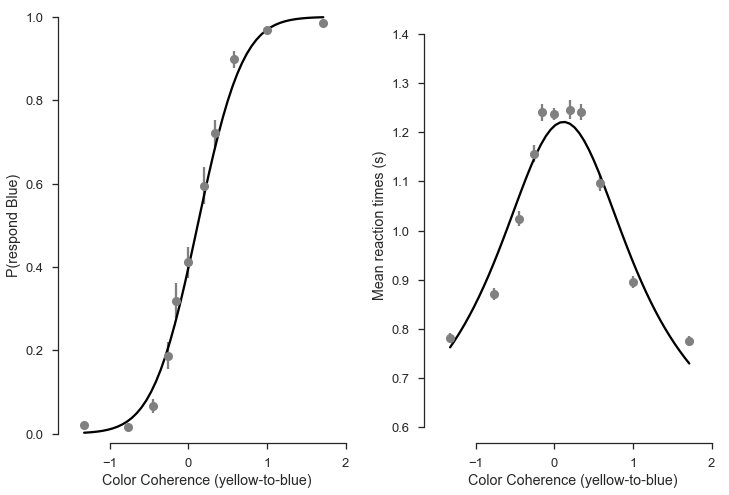

In [15]:
datadotsplot=np.column_stack([dots['color_coh'],dots['RT'],dots['choseblue'],dots['subjid']])
# Plot data with fits
plotDotsDataWithFit(datadotsplot, thetadots, dt=.0005)

### Color Dots choice data logistic regression

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choseblue ~ color_coh + (1 | subjid)
   Data: dots

     AIC      BIC   logLik deviance df.resid 
  4596.3   4616.5  -2295.2   4590.3     6197 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-101.793   -0.452   -0.012    0.411  156.662 

Random effects:
 Groups Name        Variance Std.Dev.
 subjid (Intercept) 0.6167   0.7853  
Number of obs: 6200, groups:  subjid, 30

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -0.2903     0.1481   -1.96     0.05 .  
color_coh     4.2193     0.1311   32.19   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
          (Intr)
color_coh -0.028


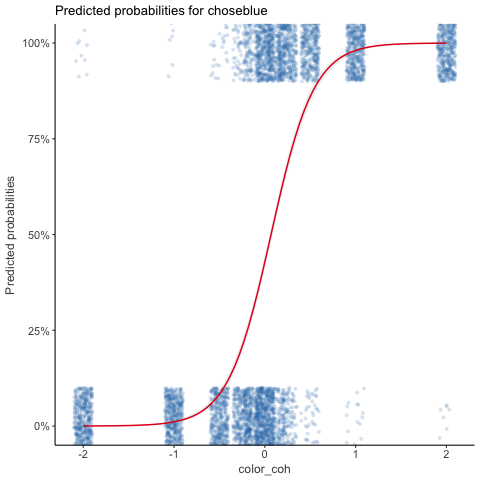

In [16]:
%%R -i dots
## there is no good package to run mixed effects logistic regression, using R's lme4 package
chosebluemod=glmer(choseblue ~ color_coh + (1|subjid), family='binomial', data=dots)
print(summary(chosebluemod))
sjp.setTheme(base = theme_classic())
sjp.glmer(chosebluemod,type='fe.slope',show.ci=T, show.values=T)

### Color dots RT data linear regression

In [17]:
# RT mixed effects linear model using python's statsmodels
dots=dots.assign(abscolorcoh=dots['color_coh'].abs())
dotsmd = smf.mixedlm('RT ~ abscolorcoh', dots, groups=dots['subjid'])
dotsmdf = dotsmd.fit()
print(dotsmdf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: RT        
No. Observations: 6200    Method:             REML      
No. Groups:       30      Scale:              0.1026    
Min. group size:  189     Likelihood:         -1802.8426
Max. group size:  210     Converged:          Yes       
Mean group size:  206.7                                 
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     1.227    0.029  42.955 0.000  1.171  1.283
abscolorcoh  -0.248    0.006 -41.624 0.000 -0.260 -0.236
groups RE     0.024    0.020                            



Linear mixed model fit by REML ['lmerMod']
Formula: RT ~ abscolorcoh + (1 | subjid)
   Data: dots

REML criterion at convergence: 3605.7

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-3.5464 -0.6795 -0.1375  0.5215  5.2757 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjid   (Intercept) 0.0235   0.1533  
 Residual             0.1026   0.3203  
Number of obs: 6200, groups:  subjid, 30

Fixed effects:
            Estimate Std. Error t value
(Intercept)  1.22668    0.02855   42.97
abscolorcoh -0.24809    0.00596  -41.62

Correlation of Fixed Effects:
            (Intr)
abscolorcoh -0.136


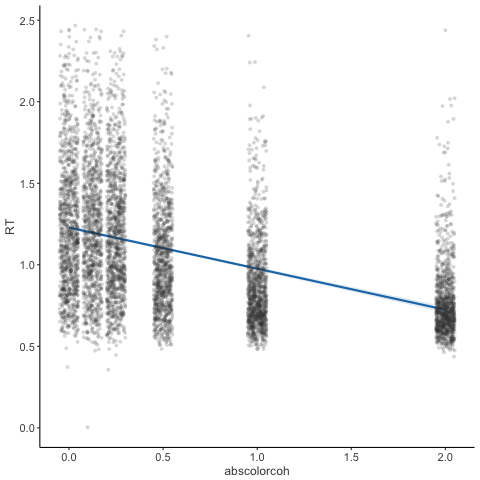

In [18]:
%%R -i dots
## compare the model using python's statsmodels (above) to R's lme4
dotsrtmod=lmer(RT ~ abscolorcoh + (1|subjid), data=dots)
print(summary(dotsrtmod))
sjp.lmer(dotsrtmod,type='fe.slope',show.ci=T, show.values=T, vars="abscolorcoh")

### Plot Dots data with fits per participant
#### Figure S1

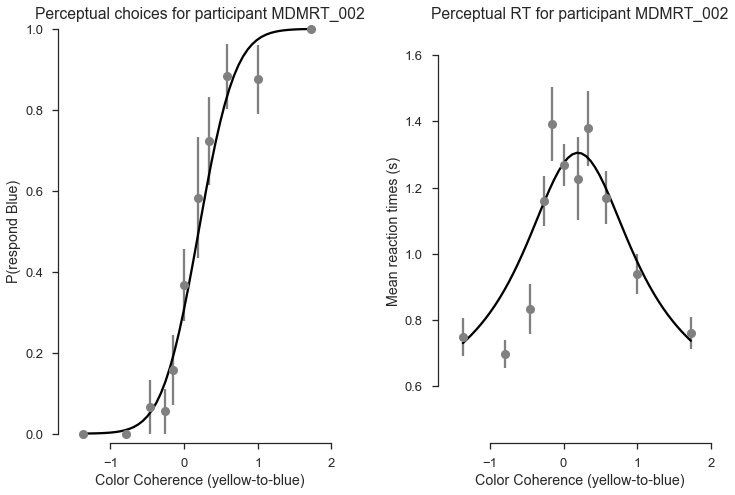

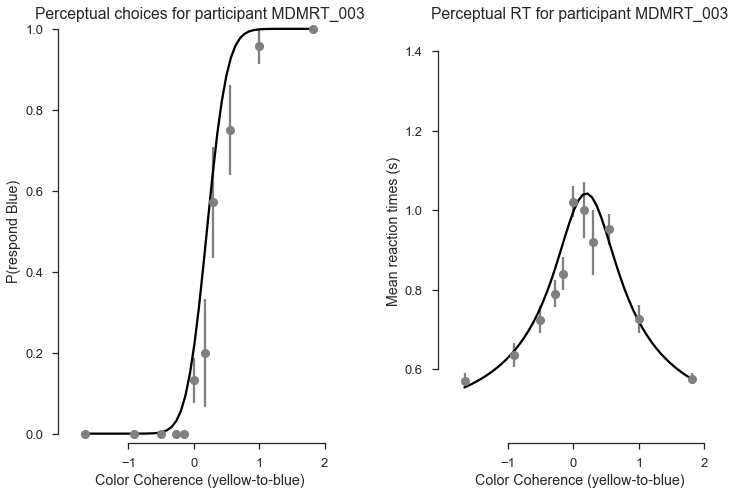

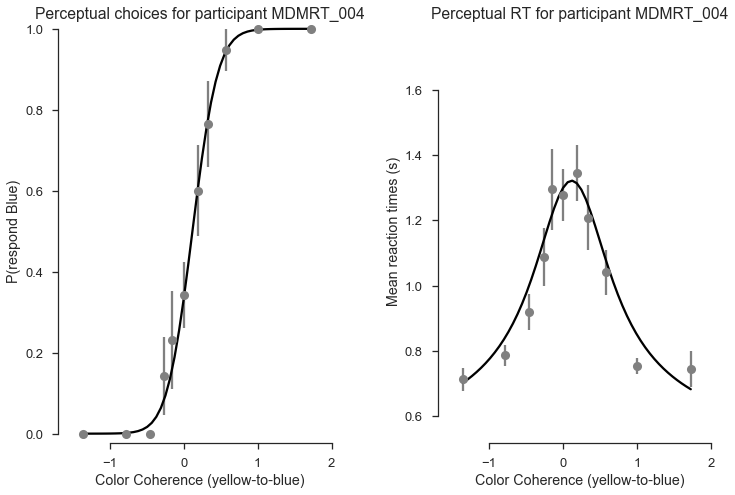

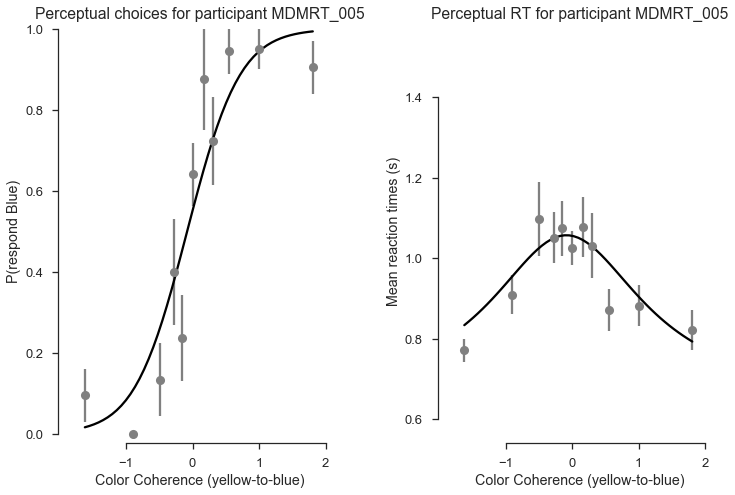

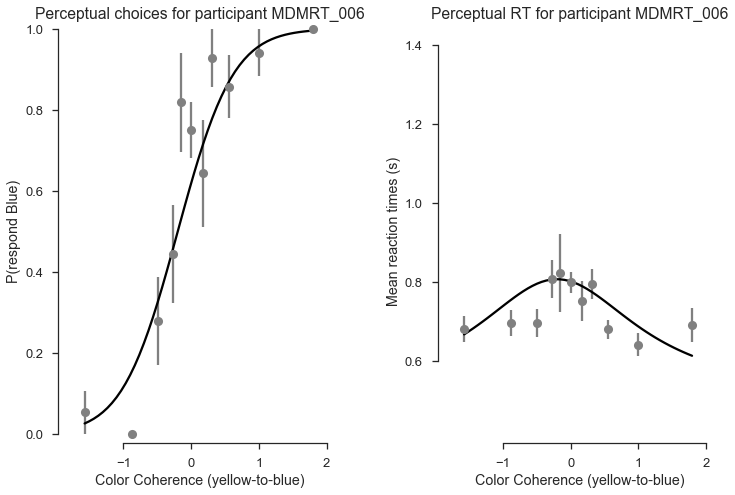

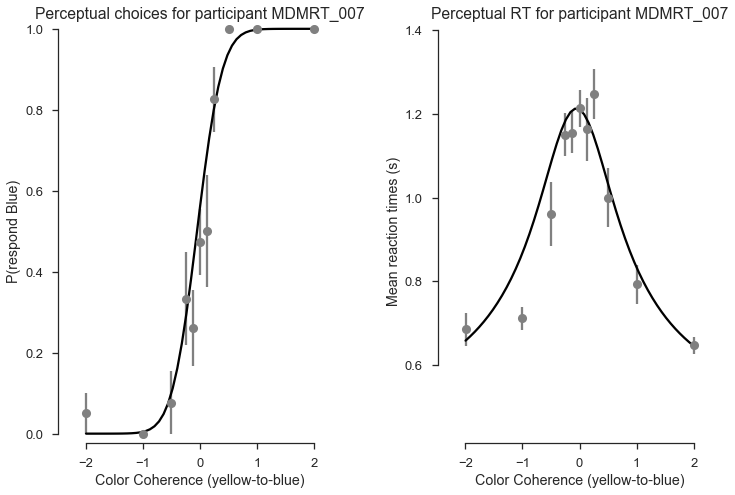

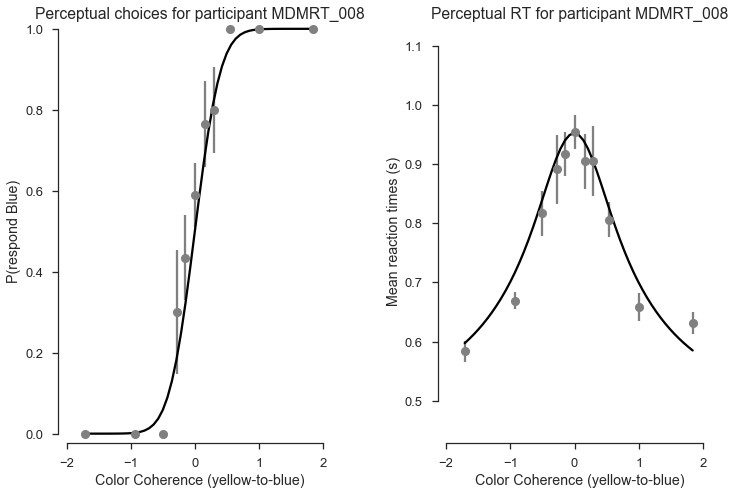

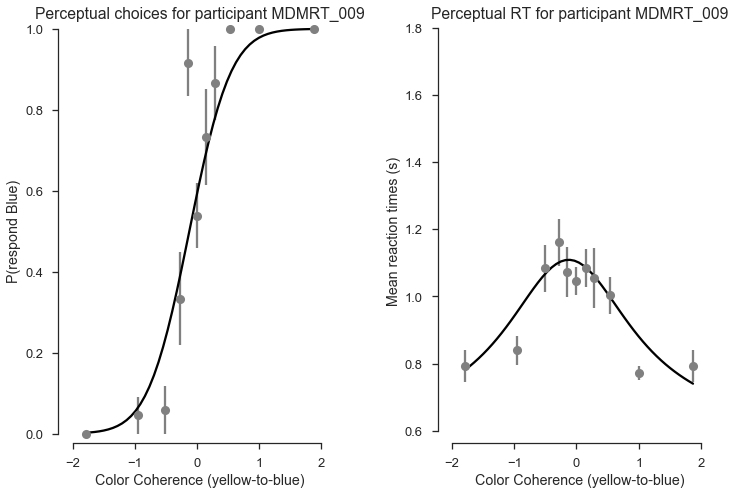

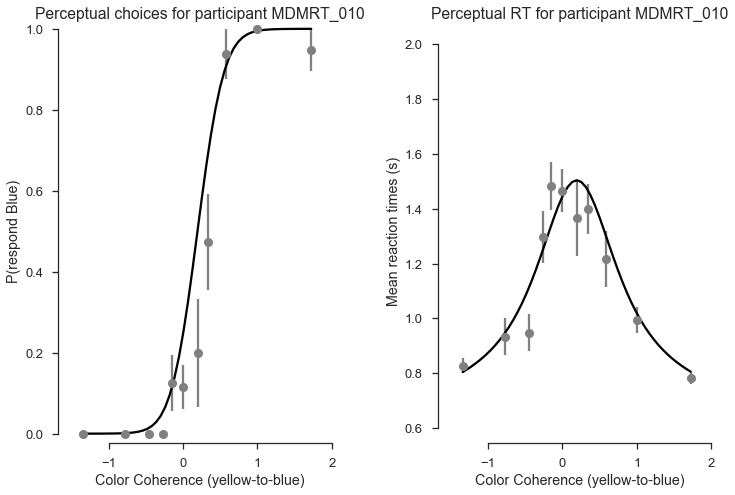

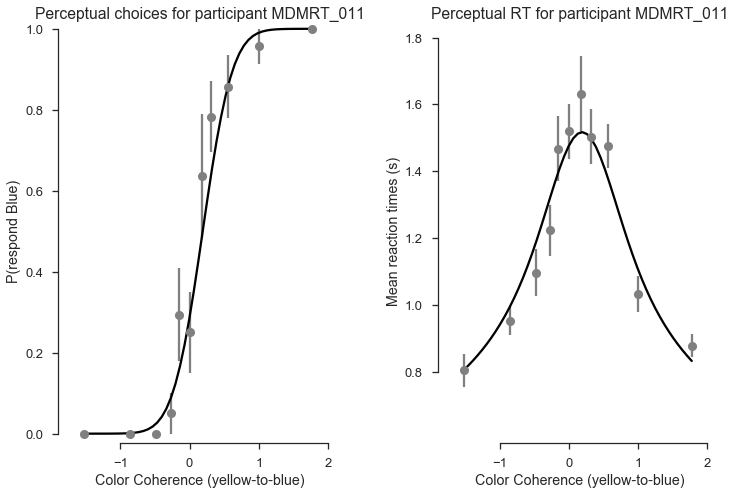

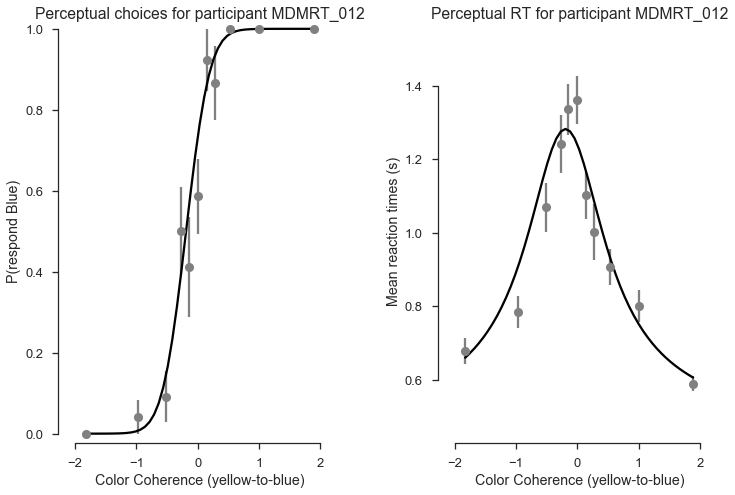

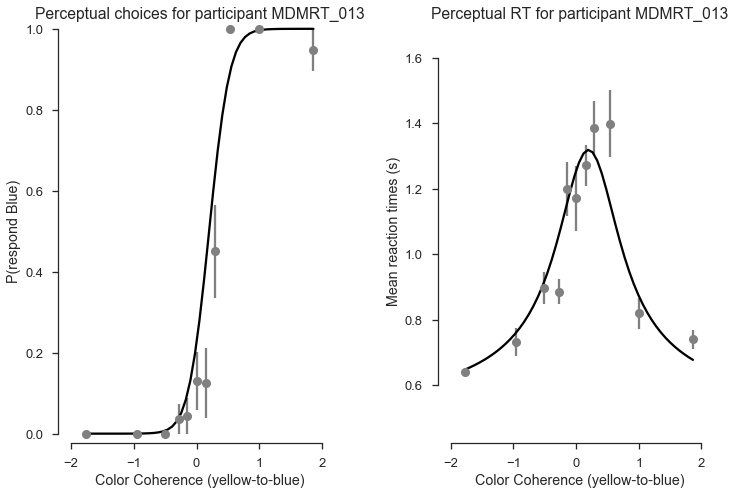

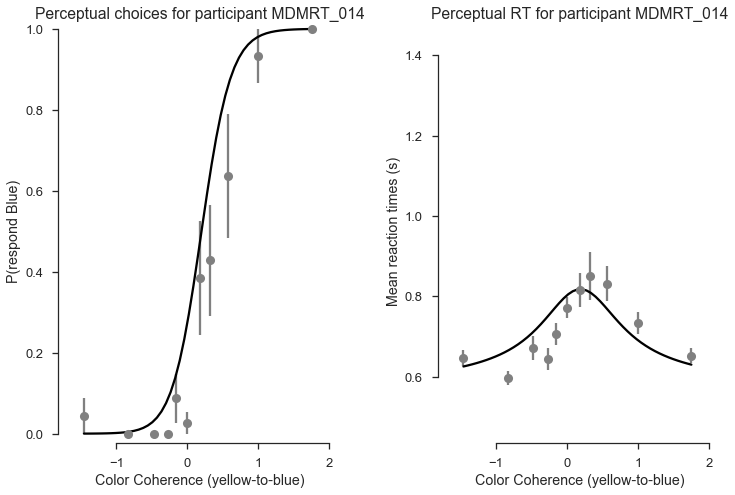

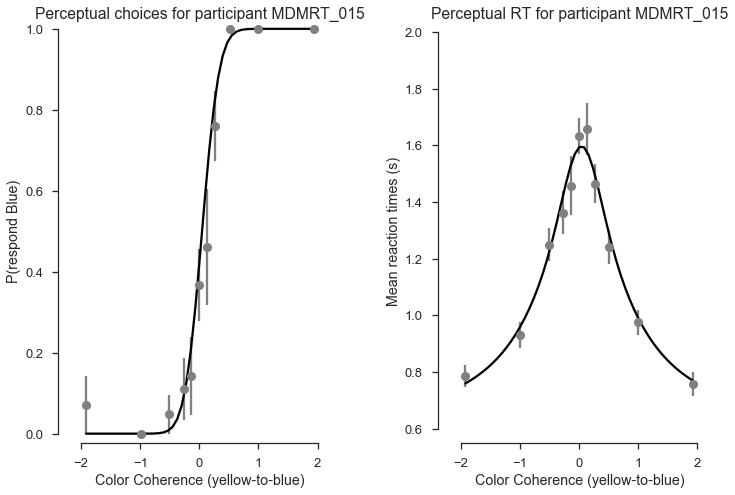

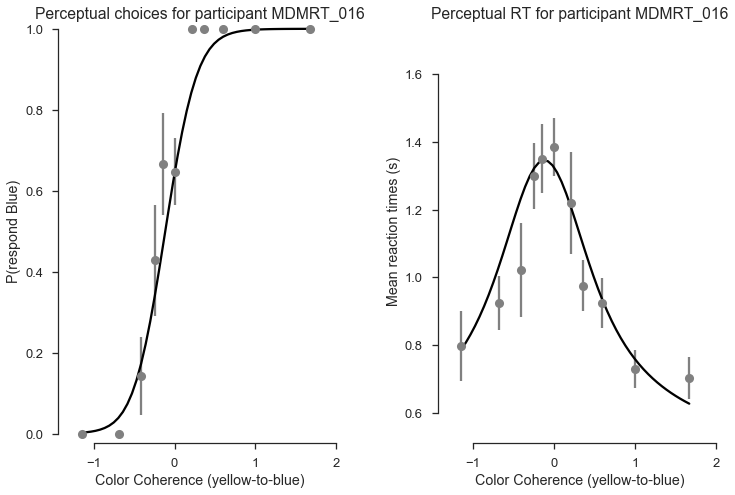

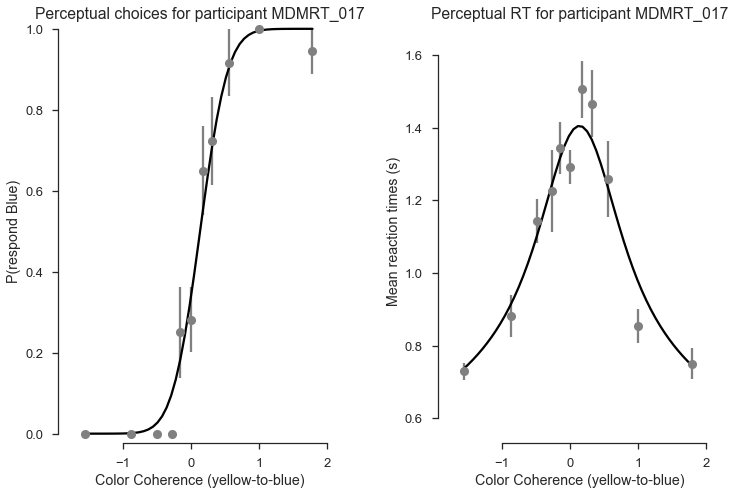

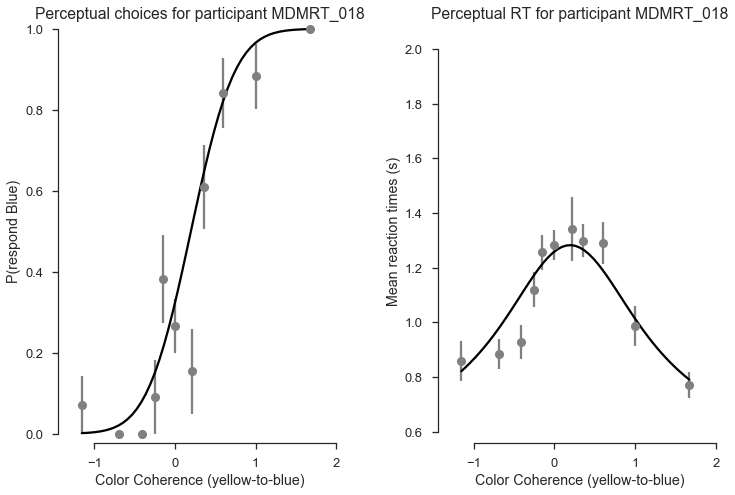

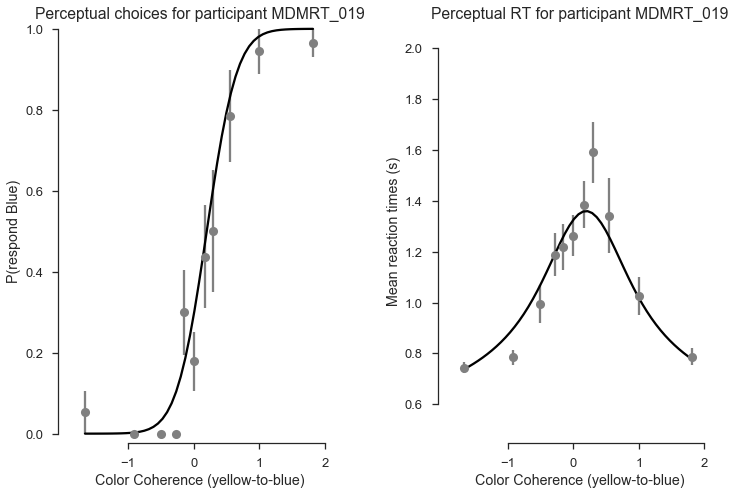

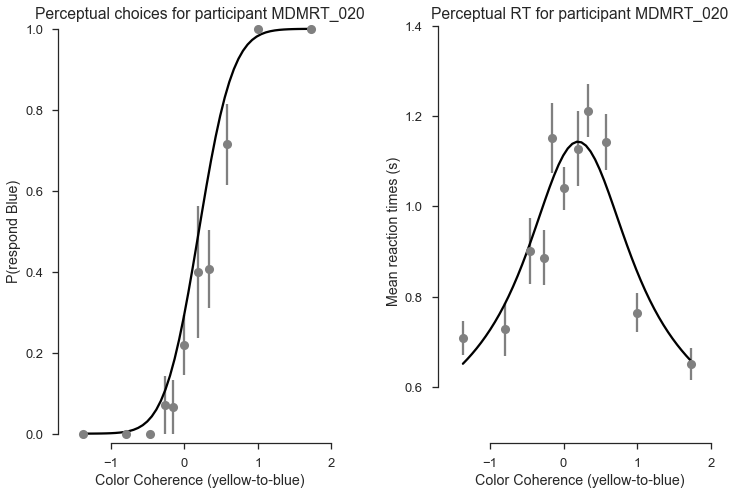

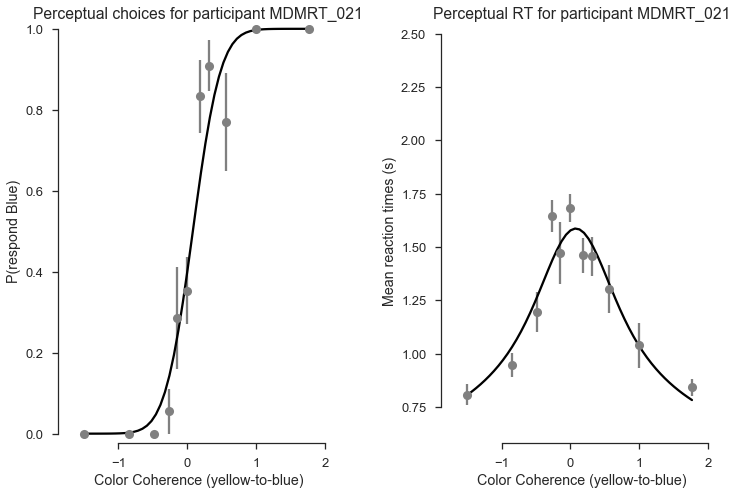

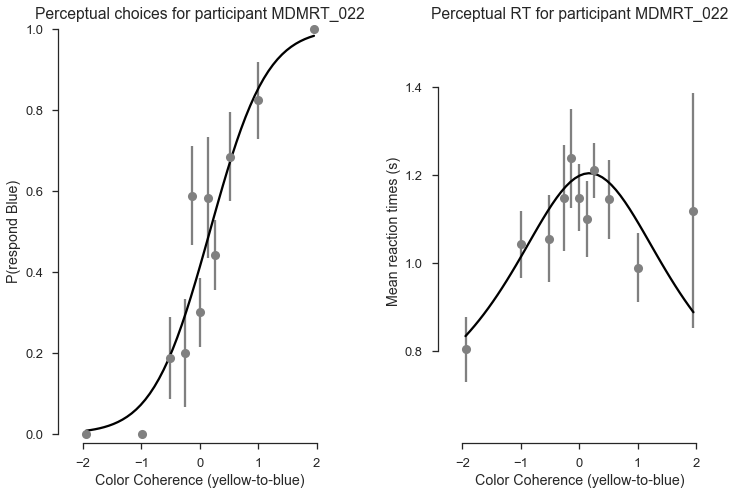

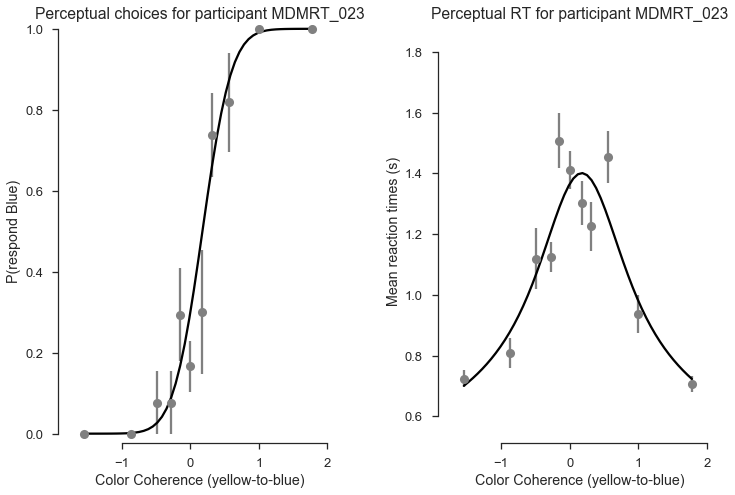

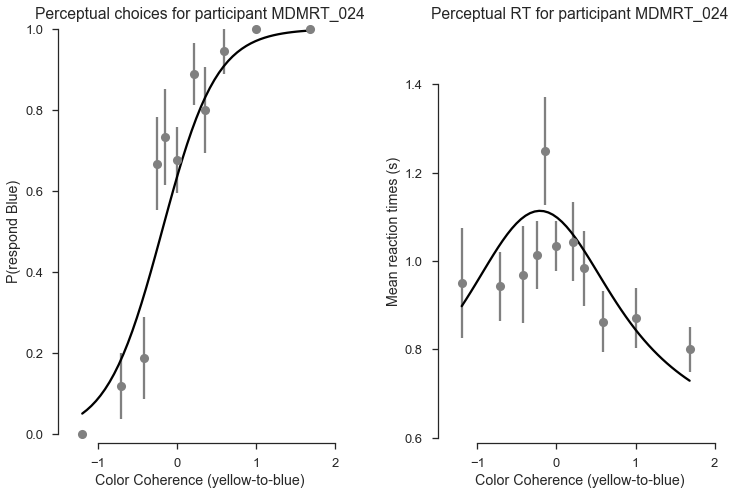

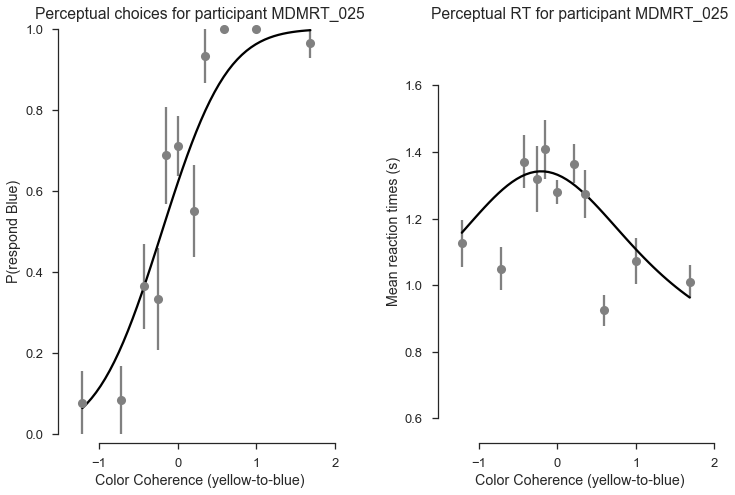

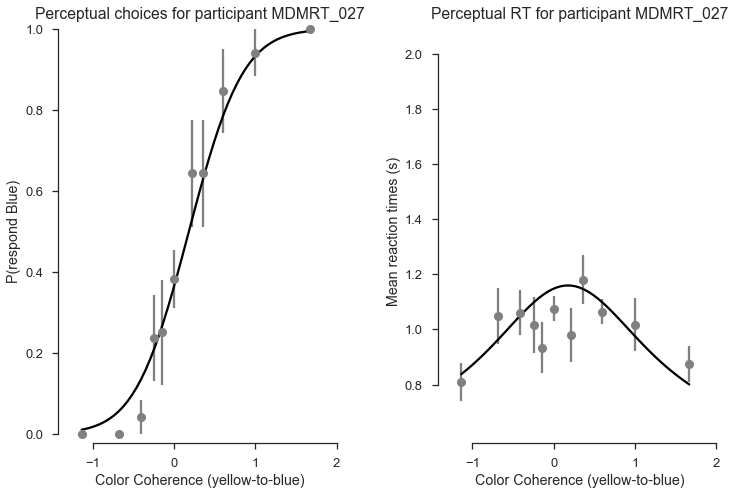

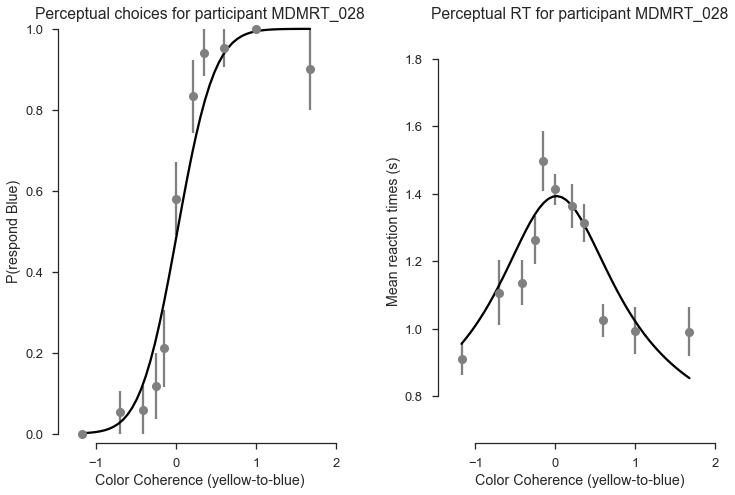

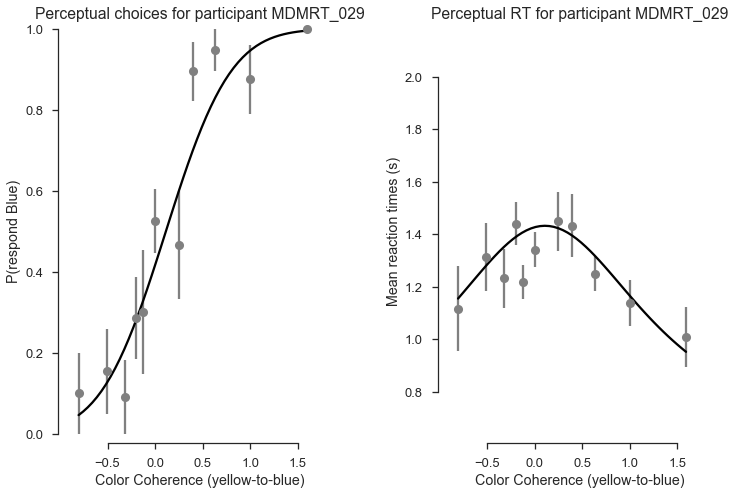

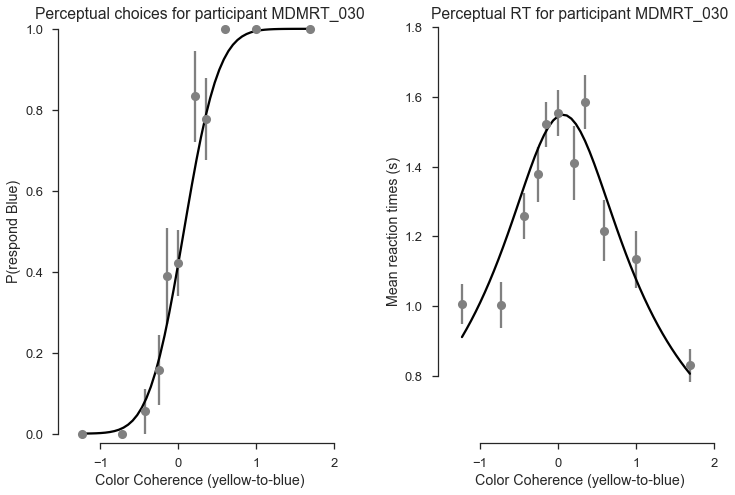

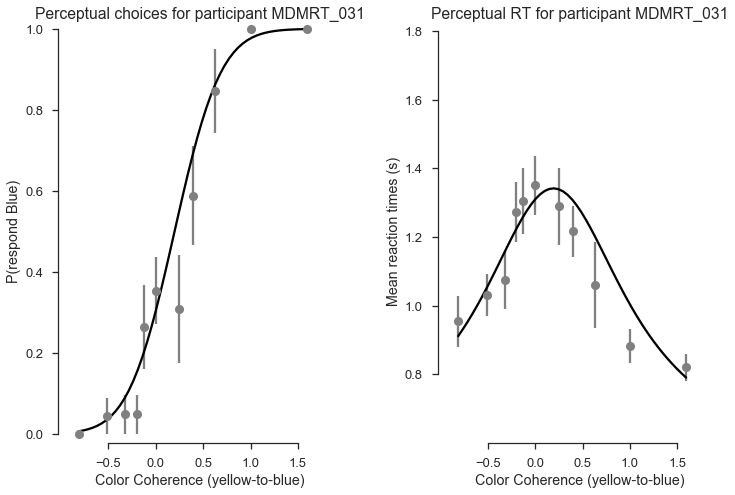

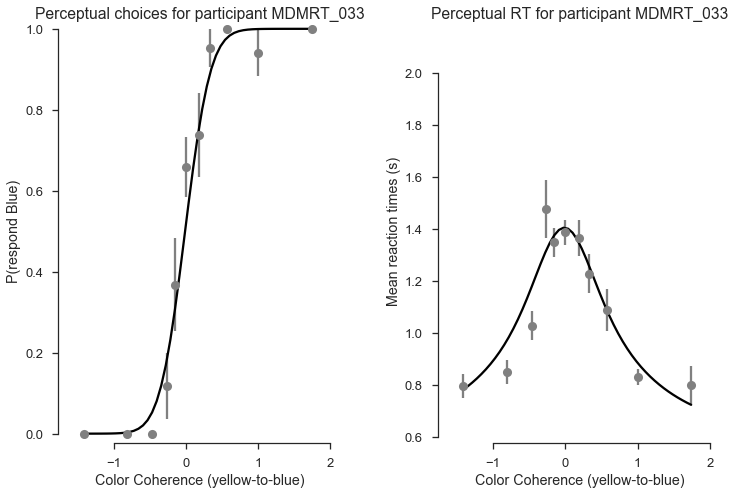

In [19]:
for s in dots.subjid.unique():
    dotsub=dots.loc[dots['subjid']==s]
    datadotsub=np.column_stack([dotsub['color_coh'],dotsub['RT'],dotsub['choseblue']])
    [thetadotssub,dotssubfopt]=fitData(datadotssub)
    # Plot data with fits
    plotDotsubDataWithFit(datadotsub, thetadotssub, s, dt=.005)
    outputfit(datadotsub, thetadotssub, s, 'dots', dt=.0005)

## Food Choice
### Load in all food choice task data

In [20]:
# make list of files
filelist=[]
for s in subjid:
    filelist=filelist+glob.glob(datapath+'MDMRT_'+str(s).zfill(3)+'_food_choice_run_*m.txt')

# load data into dataframe
food=pd.read_table(filelist[0],sep=" ")
filelist.remove(filelist[0])
for f in filelist:
    tmp=pd.read_table(f,sep=" ")
    food=pd.concat([food,tmp])

### Compile food choice data for fit

In [21]:
# only take valid trials
isvalidtrial=food['Response']!='x'
food=food[isvalidtrial]

# code chose right
food=food.assign(choseright=food['Response'] == '4$')

# calculate deltavalue
food=food.assign(deltaval=food['bidRight']-food['bidLeft'])

food['deltavalrnd']=food['deltaval'].round(1)
datafood=np.column_stack([food['deltavalrnd'],food['RT'],food['choseright']])


### Run fits on all trials and participants of food data

In [22]:
# fit to food
[thetafood,foodfopt]=fitData(datafood, dt=.0005)

### Plot all trials and participants of food data with fits
#### Figure 2B

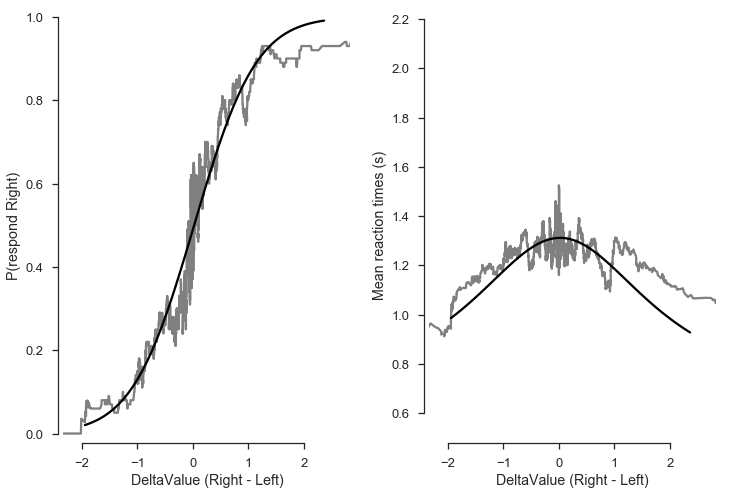

In [23]:
datafoodplot=np.column_stack([food['deltavalrnd'],food['RT'],food['choseright'],food['subjid'],food['deltaval']])
plotFoodDataWithFit(datafoodplot, thetafood, dt=.0005)

### Food choice data logistic regression

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: binomial  ( logit )
Formula: choseright ~ deltaval + (1 | subjid)
   Data: food

     AIC      BIC   logLik deviance df.resid 
  7726.2   7746.4  -3860.1   7720.2     6185 

Scaled residuals: 
     Min       1Q   Median       3Q      Max 
-13.1080  -0.9548  -0.1891   0.9808   6.2511 

Random effects:
 Groups Name        Variance Std.Dev.
 subjid (Intercept) 0.0188   0.1371  
Number of obs: 6188, groups:  subjid, 30

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -0.01918    0.03698  -0.519    0.604    
deltaval     1.78106    0.07907  22.525   <2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Correlation of Fixed Effects:
         (Intr)
deltaval 0.031 


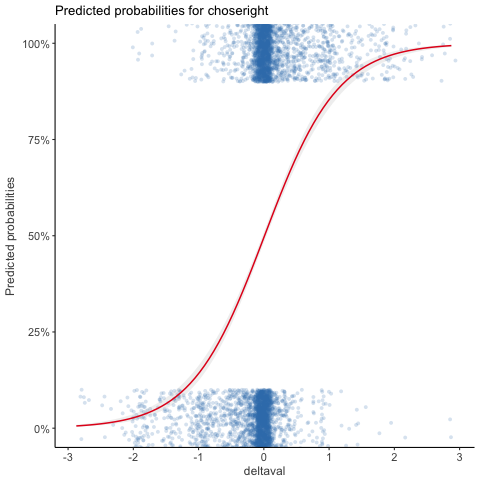

In [24]:
%%R -i food
choserightmod=glmer(choseright ~ deltaval + (1|subjid), family='binomial', data=food)
print(summary(choserightmod))
sjp.setTheme(base = theme_classic())
sjp.glmer(choserightmod,type='fe.slope',show.ci=T, show.values=T)

### Food RT data linear regression model

In [25]:
# RT mixed effects linear model
food=food.assign(absdeltaval=food['deltaval'].abs())
foodmd = smf.mixedlm('RT ~ absdeltaval', food, groups=food['subjid'])
foodmdf = foodmd.fit()
print(foodmdf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: RT        
No. Observations: 6188    Method:             REML      
No. Groups:       30      Scale:              0.1587    
Min. group size:  185     Likelihood:         -3152.0425
Max. group size:  210     Converged:          Yes       
Mean group size:  206.3                                 
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     1.315    0.040  32.930 0.000  1.237  1.394
absdeltaval  -0.109    0.011 -10.219 0.000 -0.130 -0.088
groups RE     0.047    0.031                            



Linear mixed model fit by REML ['lmerMod']
Formula: RT ~ absdeltaval + (1 | subjid)
   Data: food

REML criterion at convergence: 6304.1

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.7386 -0.6745 -0.1526  0.5108  4.4260 

Random effects:
 Groups   Name        Variance Std.Dev.
 subjid   (Intercept) 0.04682  0.2164  
 Residual             0.15871  0.3984  
Number of obs: 6188, groups:  subjid, 30

Fixed effects:
            Estimate Std. Error t value
(Intercept)  1.31526    0.03996   32.91
absdeltaval -0.10905    0.01067  -10.22

Correlation of Fixed Effects:
            (Intr)
absdeltaval -0.081


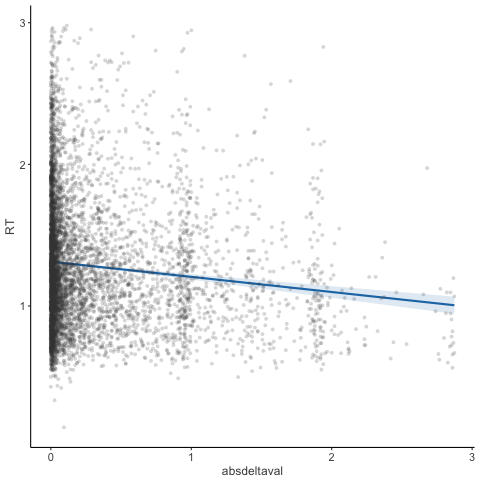

In [26]:
%%R -i food
## compare the model using python's statsmodels to R's lme4
foodrtmod=lmer(RT ~ absdeltaval + (1|subjid), data=food)
print(summary(foodrtmod))
sjp.lmer(foodrtmod,type='fe.slope',show.ci=T, show.values=T, vars='absdeltaval')

### Plot trials per participants of food data with fits
#### Figure S1

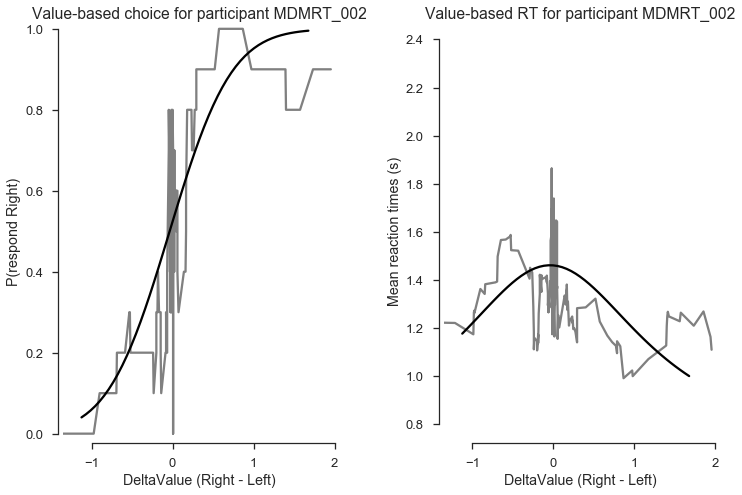

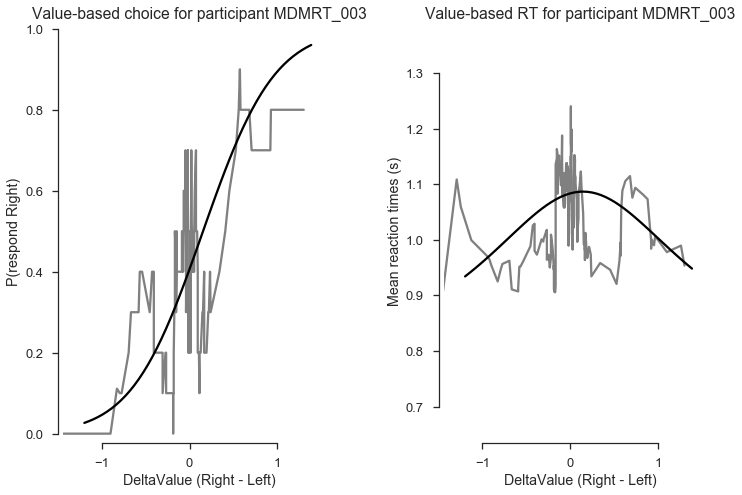

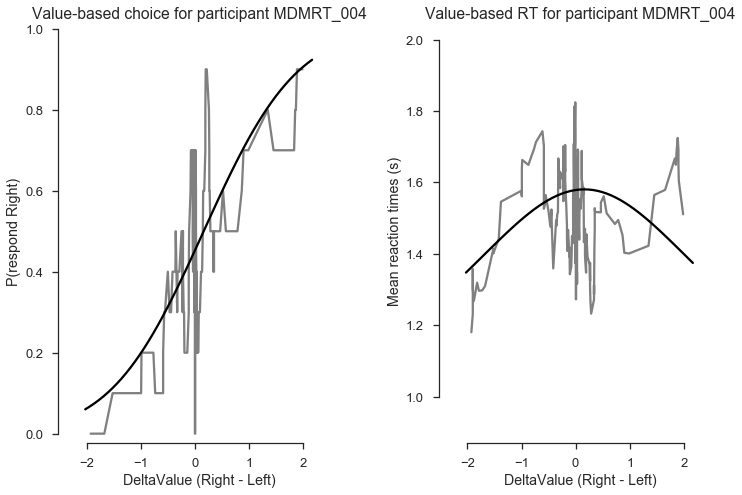

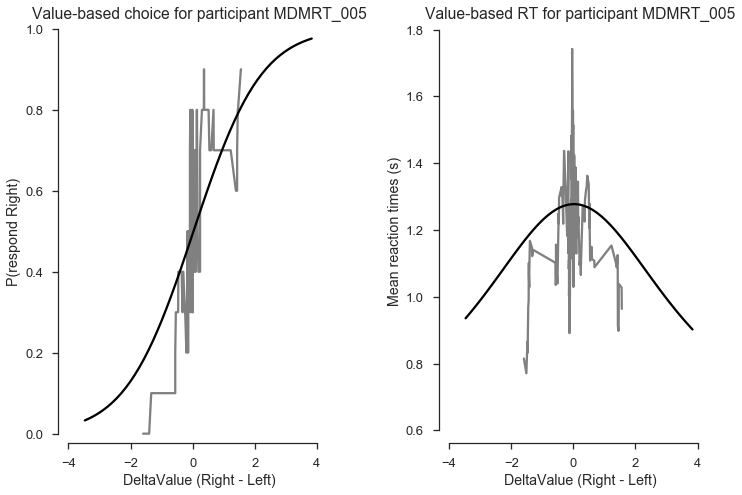

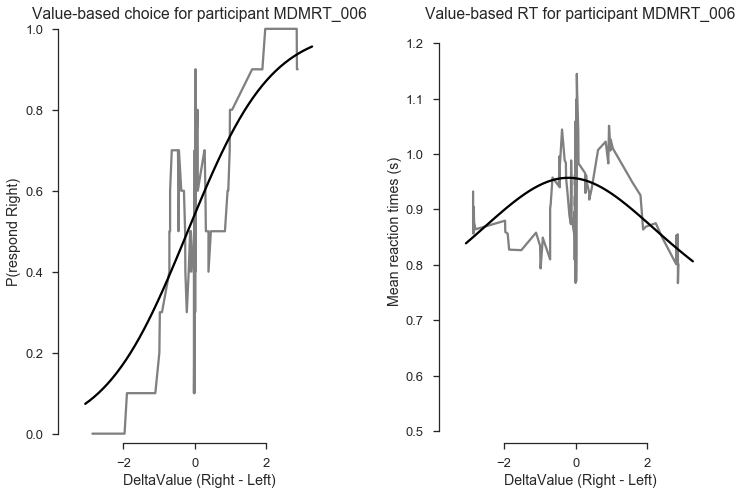

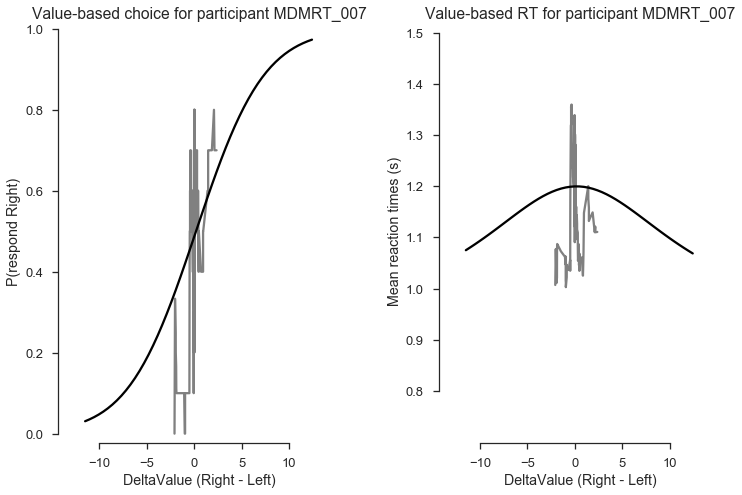

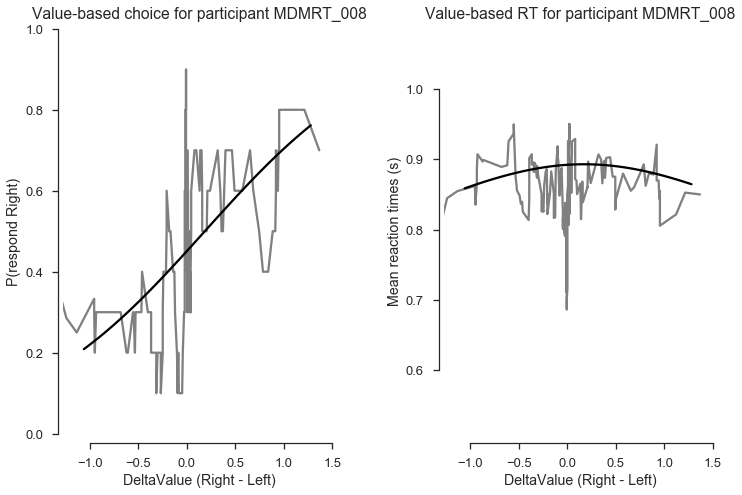

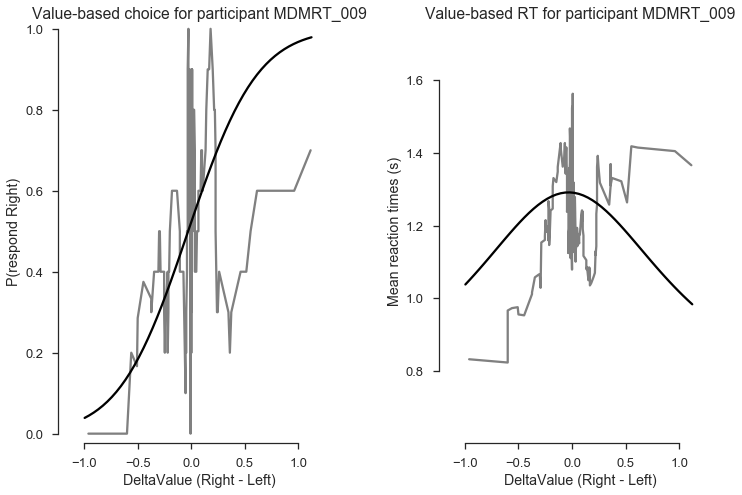

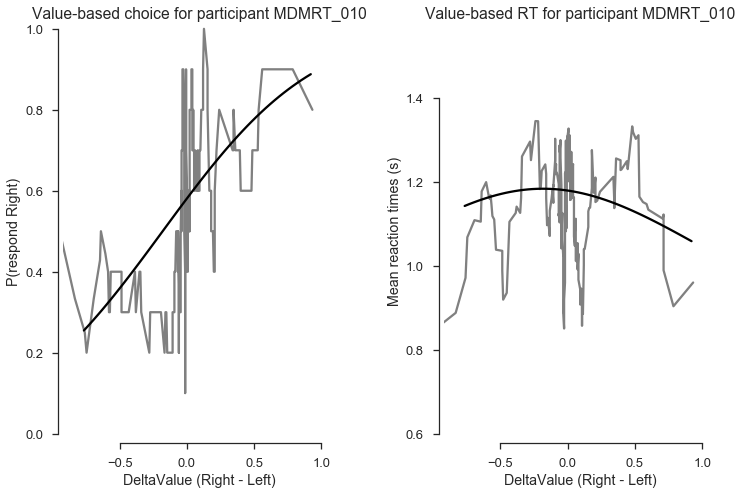

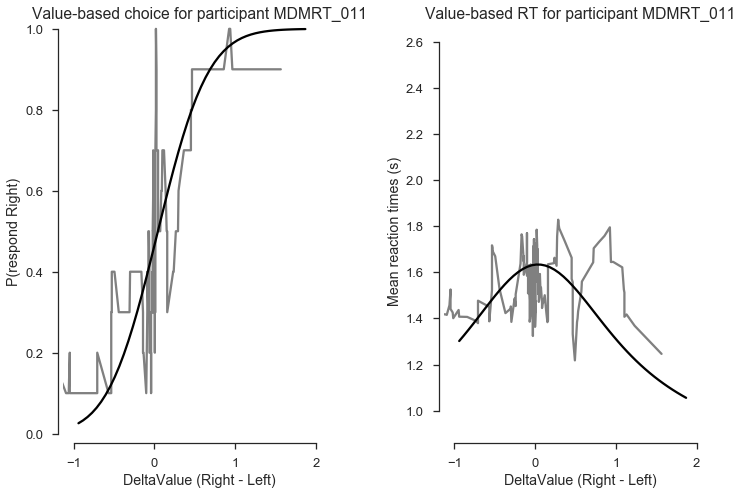

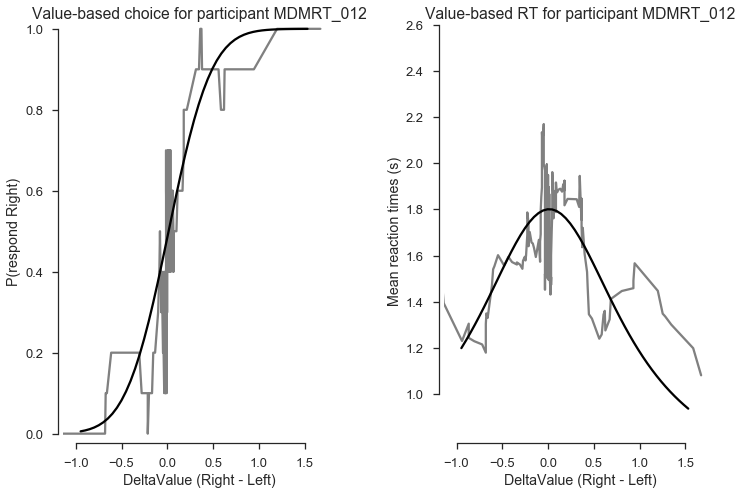

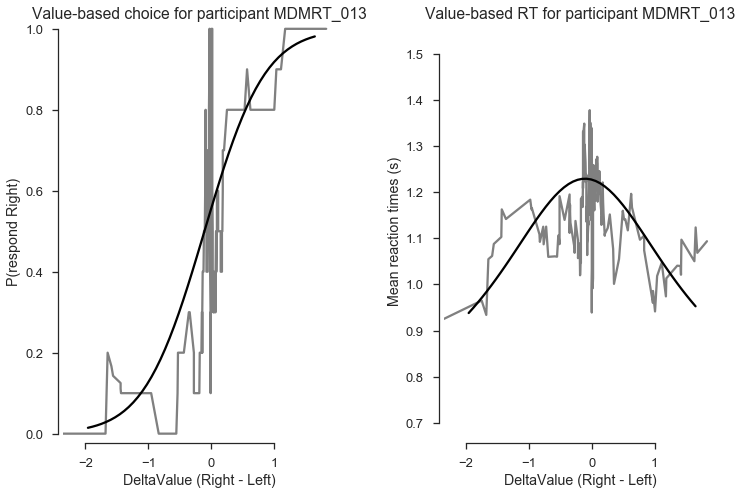

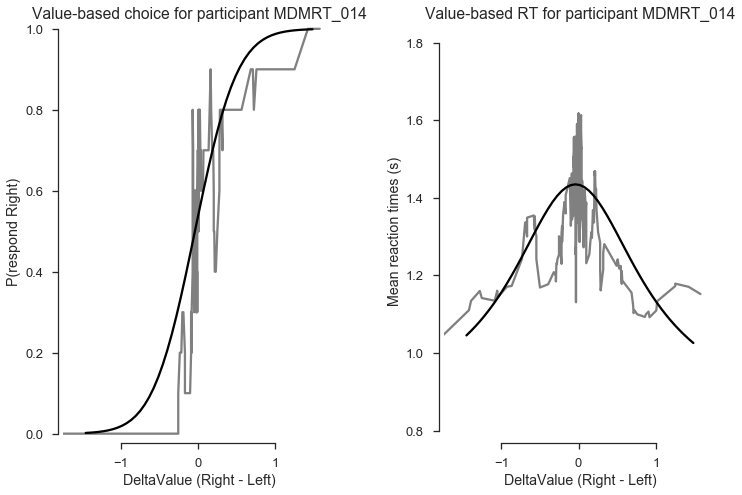

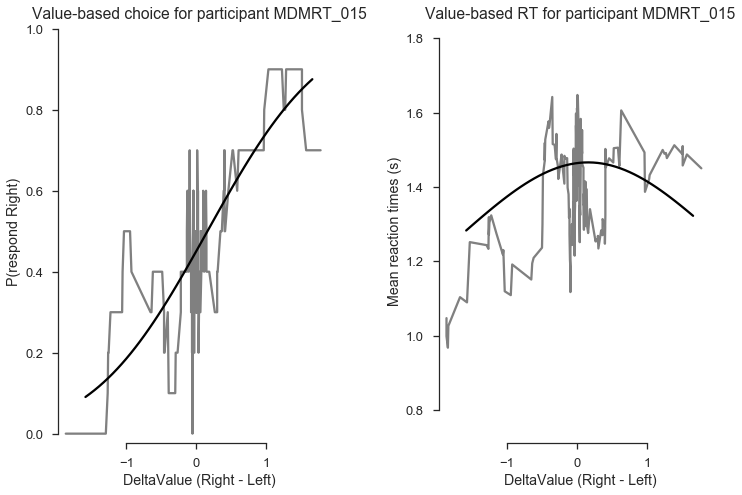

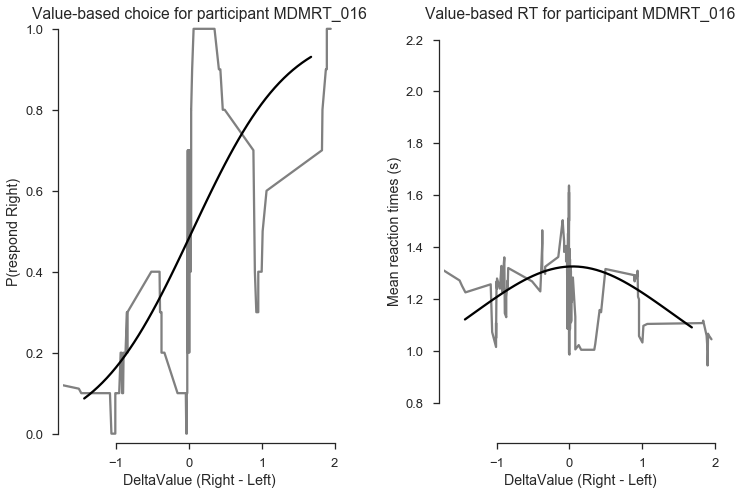

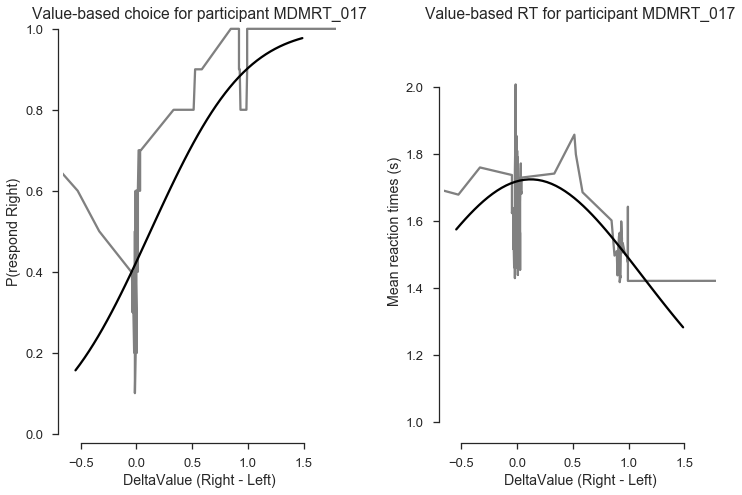

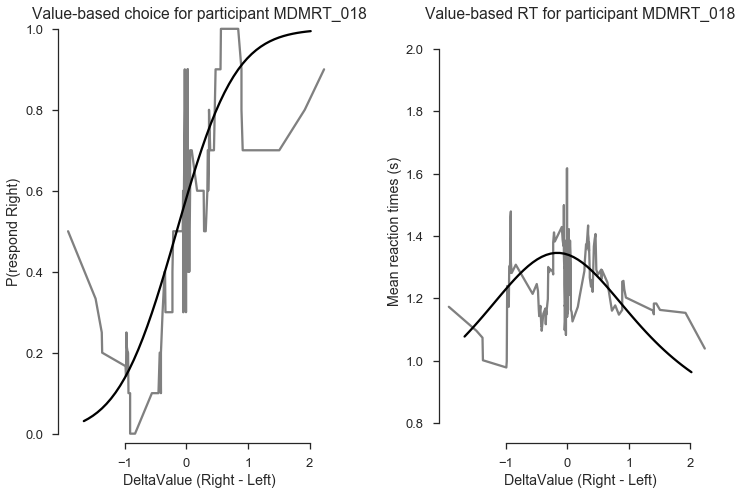

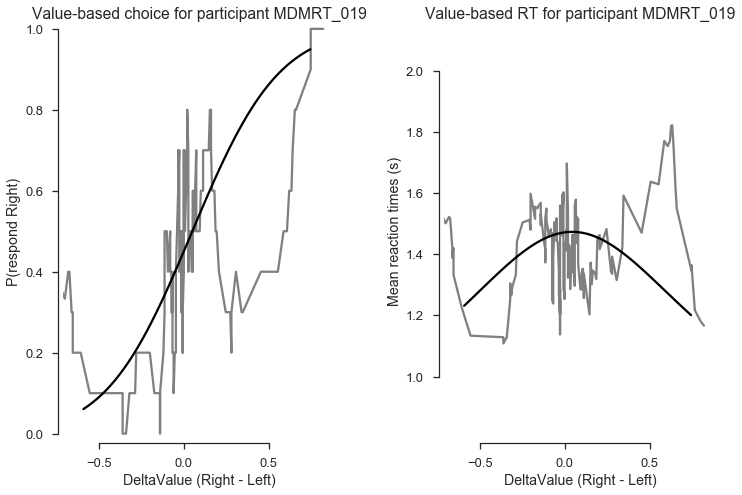

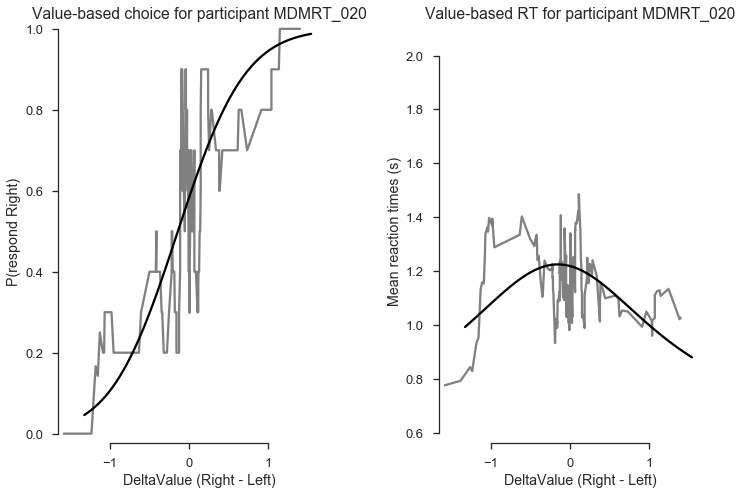

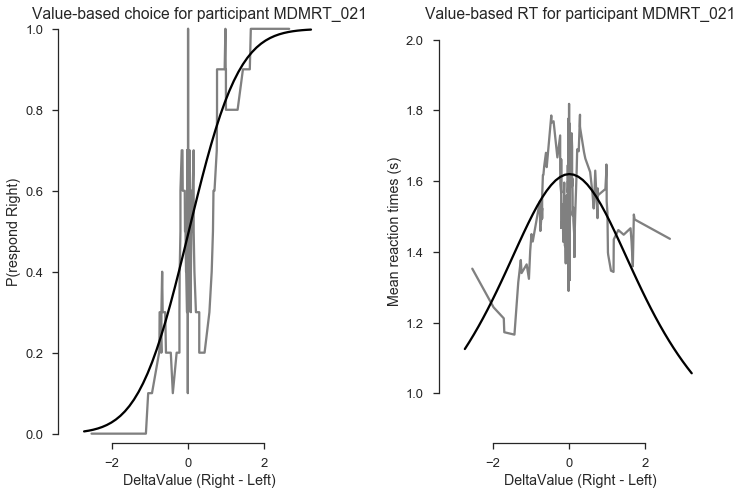

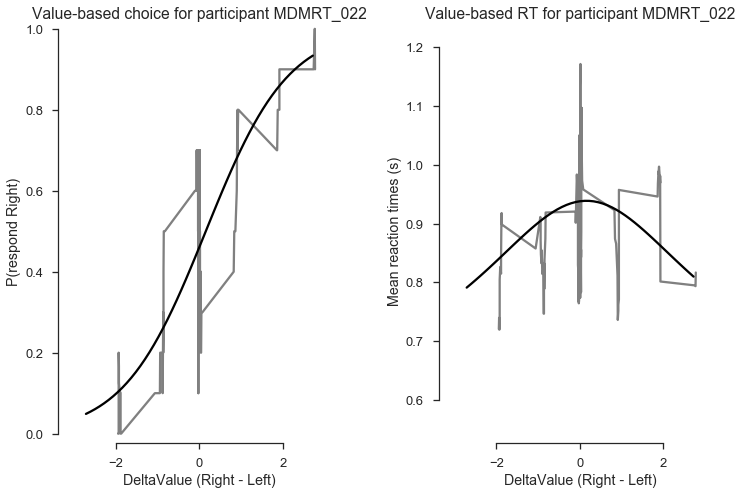

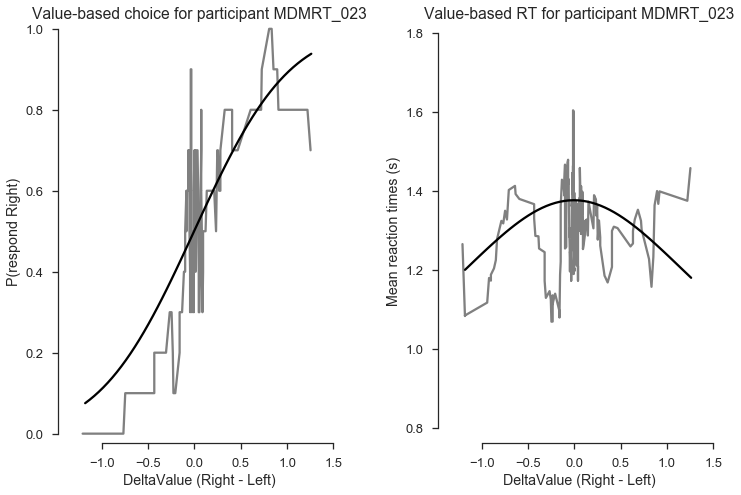

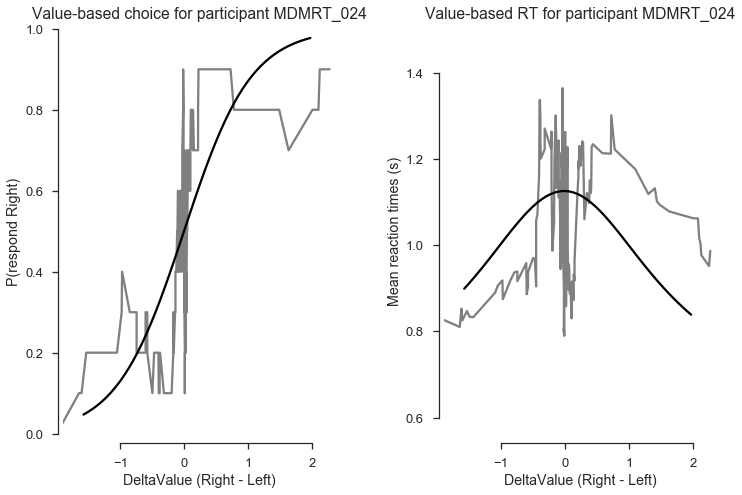

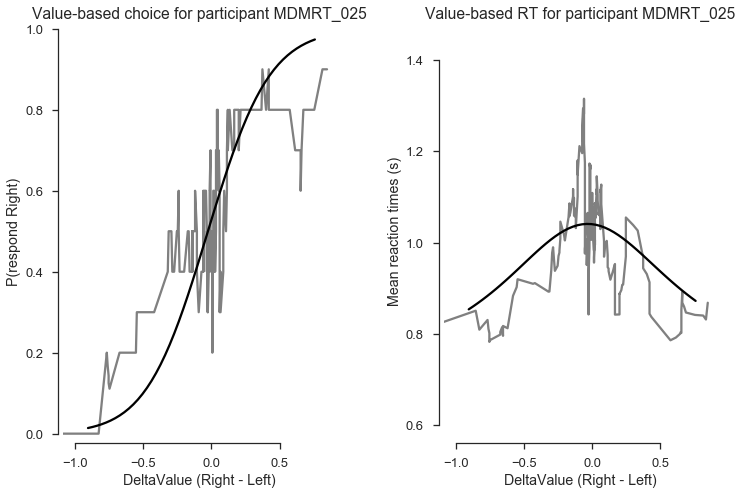

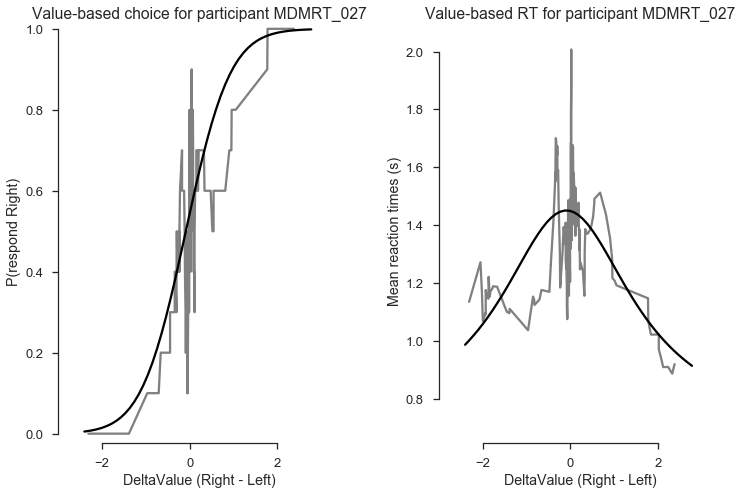

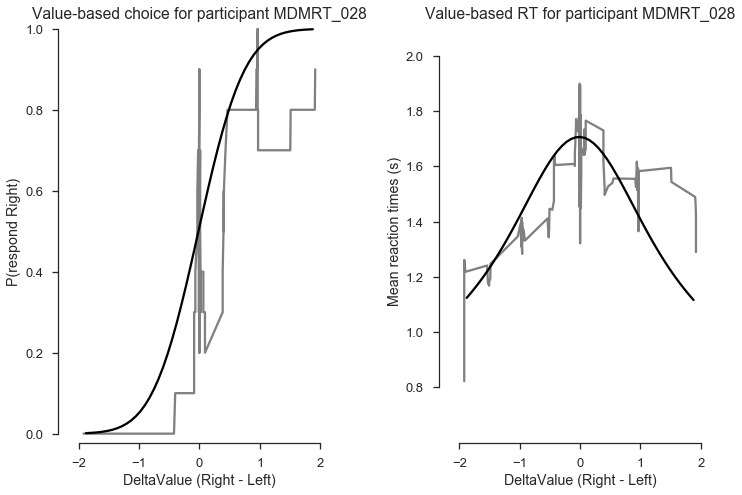

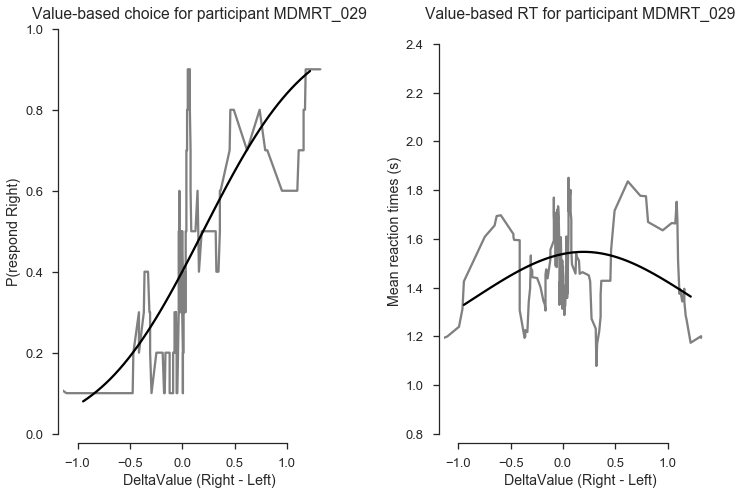

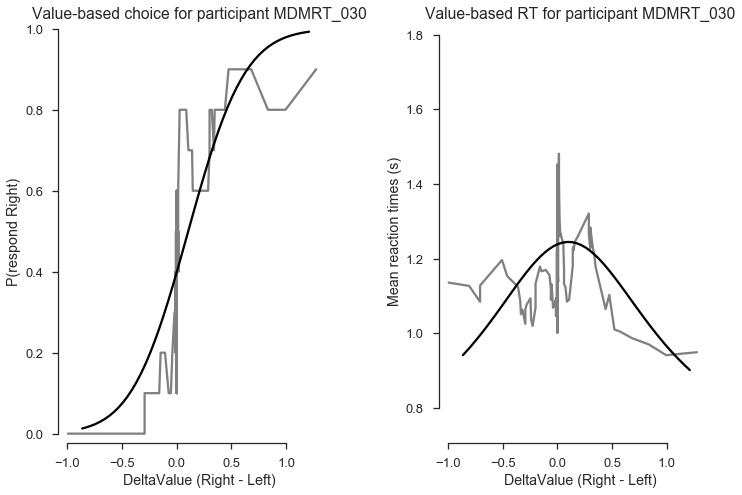

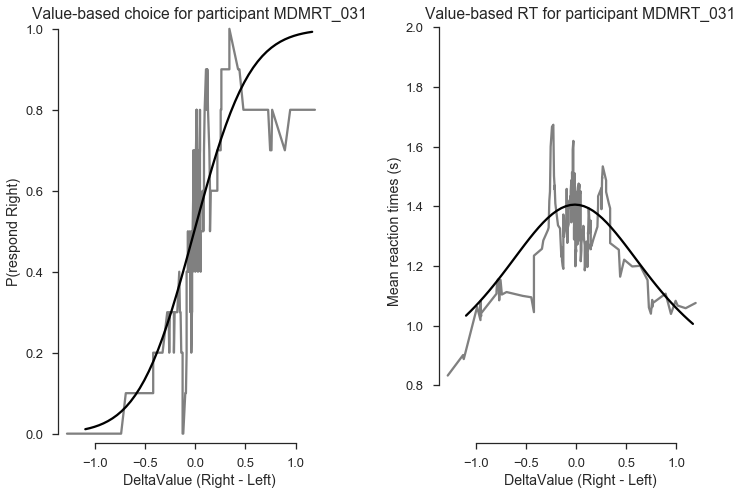

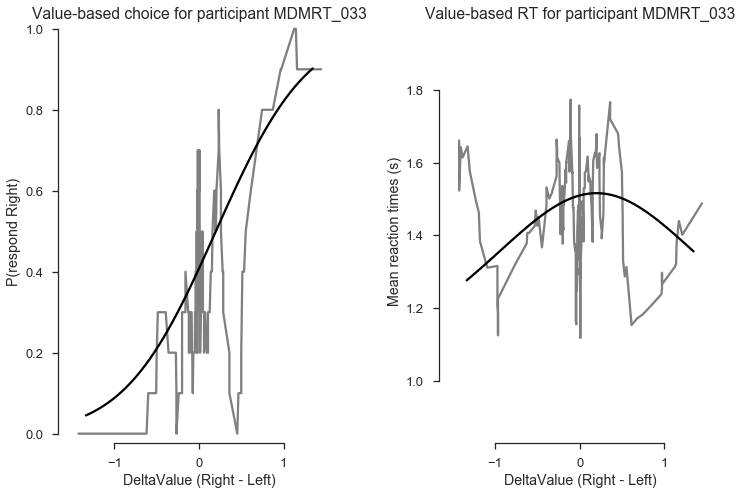

In [27]:
for s in food.subjid.unique():
    foodsub=food.loc[food['subjid']==s]
    datafoodsub=np.column_stack([foodsub['deltavalrnd'],foodsub['RT'],foodsub['choseright'],foodsub['deltaval']])
    [thetafoodsub,foodsubfopt]=fitData(foodsub)    
    # Plot data with fits
    plotFoodsubDataWithFit(datafoodsub, thetafoodsub, s, dt=.005)
    outputfit(datafoodsub, thetafoodsub, s, 'food', dt=.0005)

# Timing of value-based decisions is related to behavioral measures of memory performance
### Calculate d' per participant

In [28]:
# Load in memory behavioral data
# make list of files
filelist=[]
for s in subjid:
    filelist=filelist+glob.glob(datapath+'MDMRT_'+str(s).zfill(3)+'_memory_run_*m.txt')

# load data into dataframe
memory=pd.read_table(filelist[0],sep=" ")
filelist.remove(filelist[0])
for f in filelist:
    tmp=pd.read_table(f,sep=" ")
    memory=pd.concat([memory,tmp])
    
# Determine responded old or new depending on button order
memory['respondedold']=float('NaN')
memory['respondednew']=float('NaN')

leftold=memory['leftOld']==1
respondleft=memory['Response']=='3#'

rightold=memory['leftOld']==0
respondright=memory['Response']=='4$'

memory.loc[(leftold & respondleft) | (rightold & respondright),'respondedold']=1
memory.loc[(leftold & respondright) | (rightold & respondleft),'respondedold']=0

memory.loc[(leftold & respondleft) | (rightold & respondright),'respondednew']=0
memory.loc[(leftold & respondright) | (rightold & respondleft),'respondednew']=1

# Calculate dprime per participant
hitsfa=memory.groupby(['subjid','isold']).mean()['respondedold'].reset_index()
hits=hitsfa.loc[hitsfa.isold==1,'respondedold']
fa=hitsfa.loc[hitsfa.isold==0,'respondedold']

dprime=scipy.stats.norm.ppf(hits)-scipy.stats.norm.ppf(fa)


### Calculate difference in mean RT for Value-based - Perceptual per participant

In [29]:
# Calculate mean RT for food choice task per participant
foodmeanrt=food.groupby('subjid').mean()['RT'].reset_index()

# Calculate mean RT for food choice task per participant
dotsmeanrt=dots.groupby('subjid').mean()['RT'].reset_index()

# Calculate difference in mean RT for value-based - perceptual
meanrtdiff=foodmeanrt.RT-dotsmeanrt.RT


### Correlate mean RT difference vs. memory d' across participants
#### Figure 3B

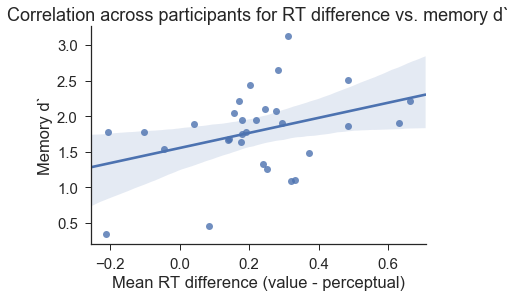

In [30]:
sns.set(font_scale=1.5)
sns.set_style("white")
sns.set_style("ticks")
plt.figure()
sns.regplot(meanrtdiff, dprime)
plt.xlabel(r'Mean RT difference (value - perceptual)')
plt.ylabel(r'Memory d`')
plt.title(r'Correlation across participants for RT difference vs. memory d`')
sns.despine()
plt.show()


## fMRI maps
### Memory Hits > Correct Rejections
#### Figure S2

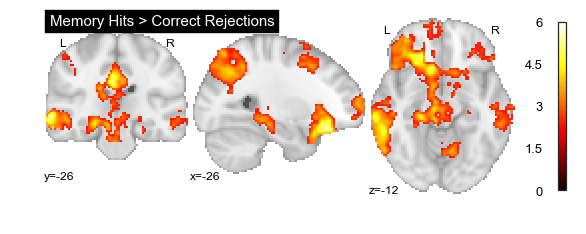

In [31]:
## path to imaging data
imgpath='MDMRT_scan'


## Map of Memory hits > correct rejections model001 task003 cope014 
memory_map=nilearn.image.load_img(imgpath +'/group/model001/task003/cope014.gfeat/cope1.feat/thresh_zstat1.nii.gz')

nilearn.plotting.plot_stat_map(memory_map,cut_coords=[-26,-26,-12],draw_cross=False, 
                               title="Memory Hits > Correct Rejections")
plt.show()


### Conjunction Map of (Value-based RT > Perceptual RT) & (Memory hits > correct rejections)
#### Figure 3A

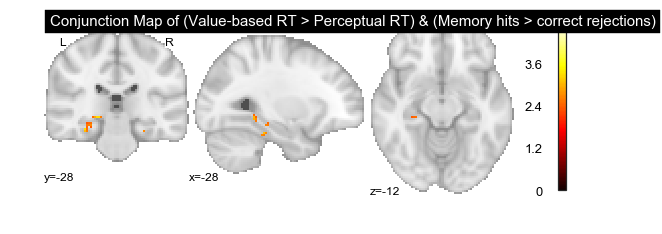

In [32]:
## Conjunction Map of (Value-based RT > Perceptual RT: model002 t1c2mint2c2 cope001) & (Memory hits > correct rejections model001 task003 cope014)

conjunction_map=nilearn.image.load_img(imgpath +'/group/model002/task1_v_task2/t1_rtall_v_t2_rtall_conj_memHitsvCR.gfeat/cope1.feat/thresh_zstat1.nii.gz')

nilearn.plotting.plot_stat_map(conjunction_map,cut_coords=[-28,-28,-12],draw_cross=False, 
                               title="Conjunction Map of (Value-based RT > Perceptual RT) & (Memory hits > correct rejections)")
plt.show()

### Map of Main effect (intercept) of Value-based onset > Perceptual onset
#### Figure S3A

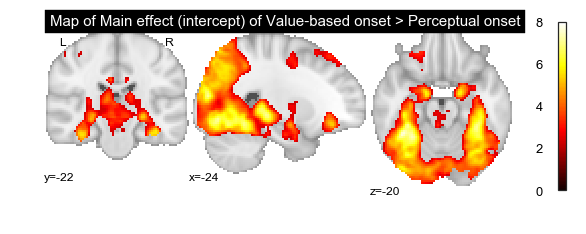

In [33]:
## Map of Main effect (intercept) of Value-based onset > Perceptual onset

t1vt2_onset_map=nilearn.image.load_img(imgpath +'/group/model002/task1_v_task2/t1c1mint2c1.gfeat/cope1.feat/thresh_zstat1.nii.gz')

nilearn.plotting.plot_stat_map(t1vt2_onset_map,cut_coords=[-24,-22,-20],draw_cross=False, 
                               title="Map of Main effect (intercept) of Value-based onset > Perceptual onset")
plt.show()


### Map of Value-based RT (range restricted) > Perceptual RT (range restricted)
#### Figure S3B

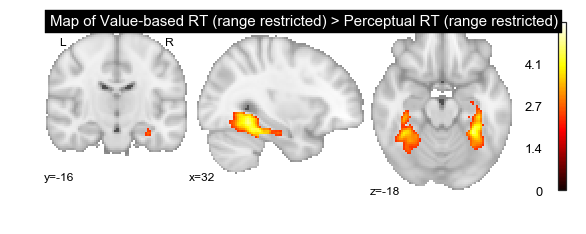

In [34]:
## Map of Value-based RT (range restricted) > Perceptual RT (range restricted) to RT range overlap between two tasks:

t1vt2rtrestricted_map=nilearn.image.load_img(imgpath +'/group/model003/task1_v_task2/t1c2vt2c2.gfeat/cope1.feat/thresh_zstat1.nii.gz')

nilearn.plotting.plot_stat_map(t1vt2rtrestricted_map,cut_coords=[32,-16,-18],draw_cross=False, 
                               title="Map of Value-based RT (range restricted) > Perceptual RT (range restricted)")
plt.show()

### Maps of VB RT, Perceptual RT, and VB RT > Perceptual RT
#### Figure S4

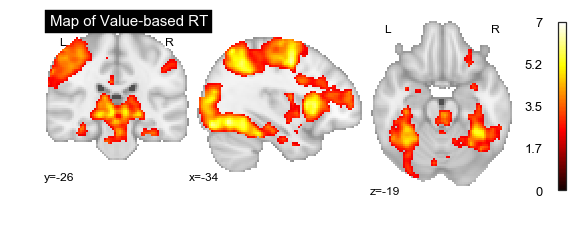

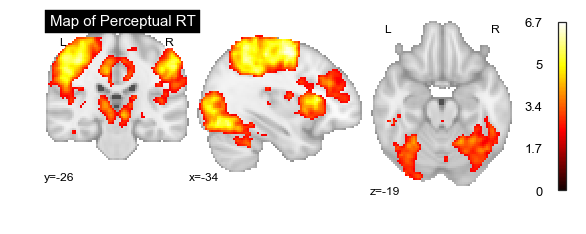

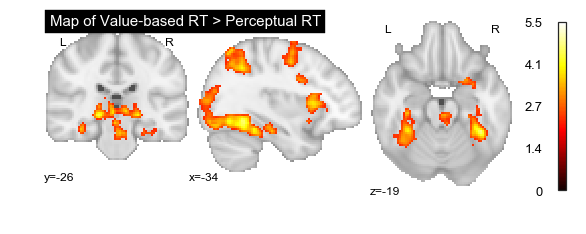

In [35]:
## Map of Value-based RT:
t1rt_map=nilearn.image.load_img(imgpath +'/group/model007/task001/cope014.gfeat/cope1.feat/thresh_zstat1.nii.gz')
nilearn.plotting.plot_stat_map(t1rt_map,cut_coords=[-34,-26,-19],draw_cross=False, 
                               title="Map of Value-based RT")

## Map of Perceptual RT:
t2rt_map=nilearn.image.load_img(imgpath +'/group/model007/task002/cope010.gfeat/cope1.feat/thresh_zstat1.nii.gz')
nilearn.plotting.plot_stat_map(t2rt_map,cut_coords=[-34,-26,-19],draw_cross=False, 
                               title="Map of Perceptual RT")

## Map of (Value-based RT > Perceptual RT: model007 t1c2mint2c2 cope001)
t1vt2rt_map=nilearn.image.load_img(imgpath +'/group/model007/task1_v_task2/t1_rtall_v_t2_rtall.gfeat/cope1.feat/thresh_zstat1.nii.gz')

nilearn.plotting.plot_stat_map(t1vt2rt_map,cut_coords=[-34,-26,-19],draw_cross=False, 
                               title="Map of Value-based RT > Perceptual RT")
plt.show()

### PPI with hippocapus seed for Fast > Slow VB decisions
#### Figure 3C

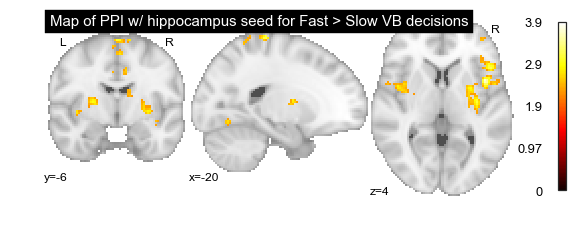

In [36]:
## PPI map with hippocampus seed for Fast > Slow VB decisions:
ppi_map=nilearn.image.load_img(imgpath +'/group/model010/task001/cope011.gfeat/cope1.feat/thresh_zstat1.nii.gz')
nilearn.plotting.plot_stat_map(ppi_map,cut_coords=[-20,-6,4],draw_cross=False, 
                               title="Map of PPI w/ hippocampus seed for Fast > Slow VB decisions")
plt.show()

## Revalued Values
### Calculate Revalued Values based on actual trial order

In [37]:
## Calculate revalued values

def fn_reval(delta_v,foodsub):
    # get number of trials
    ntrials=len(foodsub['subjid'])
    # make empty dataframe to populate with revalued values
    revalsub=pd.DataFrame(np.zeros((ntrials,2)),columns=['RevalueLeft','RevalueRight'])
    # get item names placed on left and right side of screen for all trials
    item=foodsub['ImageLeft']
    item=item.append(foodsub['ImageRight'])
    # get initial auction values for items on left and right for all trials
    value=foodsub['bidLeft']
    value=value.append(foodsub['bidRight'])
    # create a dataframe with item names and initial auction values
    tmp=pd.DataFrame({'item':item,'value':value})
    # create dataframe with 60 item names and initial auction values to be updated per trial
    value=tmp.groupby(['item'],as_index=False).mean()
    # go through trials to update values
    for t in range(ntrials):
        # get values for item on left and right from updated value dataframe
        valueleft=value[value['item']==foodsub.iloc[t]['ImageLeft']]['value']
        valueright=value[value['item']==foodsub.iloc[t]['ImageRight']]['value']
        # assign updated value for items on left and right on current trial
        revalsub.iloc[t]['RevalueLeft']= valueleft
        revalsub.iloc[t]['RevalueRight']= valueright
        # if right item chosen, increment value of item on right and decrement value of item on left
        if foodsub.iloc[t]['choseright']:
            value.loc[value['item']==foodsub.iloc[t]['ImageLeft'],'value']= valueleft - delta_v
            value.loc[value['item']==foodsub.iloc[t]['ImageRight'],'value']= valueright + delta_v
        # else if left item chosen, increment value of item on left and decrement value of item on right
        else:
            value.loc[value['item']==foodsub.iloc[t]['ImageLeft'],'value']= valueleft + delta_v
            value.loc[value['item']==foodsub.iloc[t]['ImageRight'],'value']= valueright - delta_v
    # calculate deltaval from revalued values
    revalsub['deltareval']=revalsub['RevalueRight'].values-revalsub['RevalueLeft'].values
    # choices and subject columns in ravalued dataframe
    revalsub['choseright']=foodsub['choseright'].values.astype('bool')
    revalsub['RT']=foodsub['RT'].values
    revalsub['ImageRight']=foodsub['ImageRight'].values
    revalsub['ImageLeft']=foodsub['ImageLeft'].values
    revalsub['subjid']=foodsub['subjid'].values
    # calculate goodness of fit to revalued values and output deviance
    mod=smf.glm('choseright ~ RevalueLeft + RevalueRight', data=revalsub,family = sm.families.Binomial())
    try:
        results = mod.fit()
        devsub=results.deviance
    except:
        pass
        devsub=9999
    return devsub, revalsub

def do_optim(s):
    tlow=-0.6
    thigh=0.6
    food=pd.read_csv('food.csv',header=0,index_col=0)
    uni_subj=food['subjid'].unique()
    foodsub=food[food['subjid']==uni_subj[s]]
    fn_fit = lambda x: fn_reval(x, foodsub)[0]
    # eval best delta_v:
    xopt=scipy.optimize.fminbound(func=fn_fit,x1=tlow,x2=thigh,disp=False)
    dev_opt=[uni_subj[s],fn_fit(xopt),xopt]
    return dev_opt


In [38]:
# run 30 participants in parallel
inputs = range(len(food['subjid'].unique()))
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(do_optim)(i) for i in inputs)
# convert output to dataframe to make life easier
dev_opt=pd.DataFrame(results,columns=['subjid','opt_dev','opt_deltav'])

### Caculate Revalued Values based on fake choices

In [39]:
# calculate the optimal delta_v if choices are sampled from a logistic
# seed
logit_seed=767655
np.random.seed(logit_seed)

## make fake choices
for s in food['subjid'].unique():
    foodsub=food[food['subjid']==s]
    mod=smf.glm('choseright ~ deltaval', data=foodsub,family = sm.families.Binomial())
    results = mod.fit()
    food.loc[food['subjid']==s,'pright_logistic']=results.predict()
foodfake=food
foodfake['choseright']=np.random.rand(len(food.index))<food['pright_logistic']

def do_optim_fake(s):
    tlow=-0.6
    thigh=0.6
    uni_subj=foodfake['subjid'].unique()
    foodsub=foodfake[foodfake['subjid']==uni_subj[s]]
    fn_fit = lambda x: fn_reval(x, foodsub)[0]
    # eval best delta_v:
    xopt=scipy.optimize.fminbound(func=fn_fit,x1=tlow,x2=thigh,disp=False)
    dev_opt=[uni_subj[s],fn_fit(xopt),xopt]
    return dev_opt


In [40]:
# run revaluation algoritm on fake choices on 30 participants in parallel
inputs = range(len(food['subjid'].unique()))
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(do_optim_fake)(i) for i in inputs)
# convert output to dataframe to make life easier
dev_opt_fake=pd.DataFrame(results,columns=['subjid','opt_dev','opt_deltav'])

#### Figure S6A

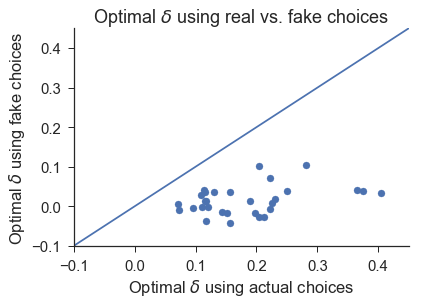

In [41]:
#Plot delta_v from revaluation algorith output using real vs. fake choices
sns.set(font_scale=1.5)
sns.set_style("white")
sns.set_style("ticks")
plt.figure()
plt.scatter(dev_opt['opt_deltav'],dev_opt_fake['opt_deltav'])
plt.xlabel(r'Optimal $\delta$ using actual choices')
plt.ylabel(r'Optimal $\delta$ using fake choices')
plt.title(r'Optimal $\delta$ using real vs. fake choices')
plt.axis([-.1, .45, -.1, .45])
plt.plot( [-.1,.45],[-.1,.45] )
sns.despine()
plt.show()

### Recalculate Revalued Values and Deviance based on Shuffled trial order

In [42]:
# make all trial shuffled dataframes
shuffle_seed=6622

np.random.seed(shuffle_seed)

def shuffledf(i):
    food=pd.read_csv('food.csv',header=0,index_col=0)
    foodshuffle=pd.DataFrame(columns=food.columns)
    for s in food['subjid'].unique():
        foodsub=food[food['subjid']==s]
        foodsubshuffle=foodsub.sample(frac=1).reset_index(drop=True)
        foodshuffle=foodshuffle.append(foodsubshuffle)
    foodshuffle.to_csv('shuffle/foodshuffle'+str(i)+'.csv')
    return

for i in range(1000):
    shuffledf(i)


In [43]:
def do_optim_shuffle(i):
    tlow=-0.6
    thigh=0.6
    food=pd.read_csv('shuffle/foodshuffle'+str(i)+'.csv',header=0,index_col=0)
    uni_subj=food['subjid'].unique()
    dev_opt=np.ones(len(uni_subj))*np.nan
    for s in range(len(uni_subj)):
        foodsub=food[food['subjid']==uni_subj[s]]
        fn_fit = lambda x: fn_reval(x, foodsub)[0]
        # eval best delta_v:
        xopt=scipy.optimize.fminbound(func=fn_fit,x1=tlow,x2=thigh,disp=False)
        dev_opt[s]=fn_fit(xopt)
    print('Done with iteration '+str(i)+'......')
    return [i, dev_opt.sum()]         

In [44]:
# run 1000 times SLOW
niter=1000
# run revaluation algoritm on shuffled trials
inputs = range(niter)
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(do_optim_shuffle)(i) for i in inputs)
## convert output to dataframe to make life easier
dev_opt_shuffle=pd.DataFrame(results,columns=['iter','opt_dev'])
dev_opt_shuffle.to_csv('dev_opt_shuffle.csv')

In [45]:
dev_opt_shuffle=pd.DataFrame(columns=['iter','subjid','opt_dev','opt_delta'])
for i in range(1000):
    tmp=pd.read_csv('shuffle/dev_opt_shuffle'+str(i)+'.csv')
    dev_opt_shuffle=dev_opt_shuffle.append(tmp)
dev_opt_shuffle.to_csv('dev_opt_shuffle.csv')

### Plot Deviance for logistic fit using original values, revalued values and revalued values following shuffled trial order
#### Figure S6B

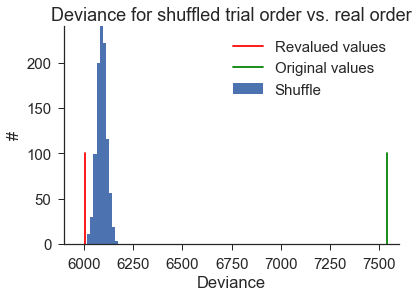

In [46]:
dev_opt_shuffle=pd.read_csv('dev_opt_shuffle.csv')
food=pd.read_csv('food.csv')

# get deviance for original values actual order
dev_opt_orig=[]
for s in food['subjid'].unique():
    foodsub=food[food['subjid']==s]
    tmp=fn_reval(0,foodsub)[0]
    dev_opt_orig.append(tmp)
    
# deviances for 1000 iterations of shuffled trial order
dev_opt_shuffle=pd.read_csv('dev_opt_shuffle.csv',header=0,index_col=0)
# deviance for revalued values actual order
dev_opt=pickle.load(open('dev_opt.p','rb'))
revaldev=sum(dev_opt['opt_dev'])
# deviance for original values actual order
origdev=sum(dev_opt_orig)

# Plot histogram of deviances for shuffled order
sns.set(font_scale=1.5)
sns.set_style("white")
sns.set_style("ticks")
plt.figure()
plt.hist(dev_opt_shuffle.groupby('iter')['opt_dev'].sum(),label='Shuffle')
plt.xlabel('Deviance')
plt.ylabel('#')
plt.title('Deviance for shuffled trial order vs. real order')
plt.plot([revaldev,revaldev],[0,100],'r-',label='Revalued values')
plt.plot([origdev,origdev],[0,100],'g-',label='Original values')
plt.axis([5900,7600,0,240])
plt.legend()
sns.despine()
plt.show()


### Plot revaluation δ for all shuffles of trial order

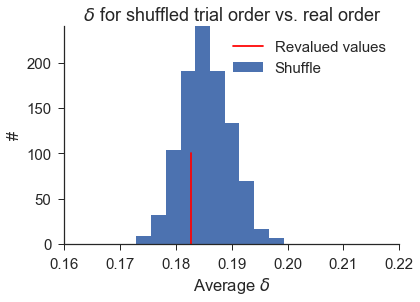

In [47]:
# Plot histogram of deltav for shuffled order
revaldeltav=np.mean(dev_opt['opt_deltav'])
sns.set(font_scale=1.5)
sns.set_style("white")
sns.set_style("ticks")
plt.figure()
plt.hist(dev_opt_shuffle.groupby('iter')['opt_delta'].mean(),label='Shuffle')
plt.xlabel(r'Average $\delta$')
plt.ylabel('#')
plt.title(r'$\delta$ for shuffled trial order vs. real order')
plt.plot([revaldeltav,revaldeltav],[0,100],'r-',label='Revalued values')
plt.axis([.16,.22,0,240])
plt.legend()
sns.despine()
plt.show()

### Fit DDM and plot choices and Reaction Times based on Revalued Values

In [48]:
## Plot Choices and RTs based on revised values
foodreval=pd.DataFrame(columns=['RevalueLeft','RevalueRight','deltareval','choseright','subjid'])
food=pd.read_csv('food.csv',header=0,index_col=0)
for s in food['subjid'].unique():
    dv=dev_opt['opt_deltav'][dev_opt['subjid']==s].values
    subfood=food[food['subjid']==s]
    tmp=fn_reval(dv,subfood)[1]
    #tmp=fn_reval(0,subfood)[1]
    foodreval=foodreval.append(tmp)

foodreval['choseright']=food['choseright'].values
foodreval['deltarevalrnd']=foodreval['deltareval'].round(1)
datafoodreval=np.column_stack([foodreval['deltarevalrnd'],foodreval['RT'],foodreval['choseright']])
datafoodrevalplot=np.column_stack([foodreval['deltarevalrnd'],foodreval['RT'],foodreval['choseright'],
                          foodreval['subjid'],foodreval['deltareval']])
datafoodreval=np.column_stack([foodreval['deltarevalrnd'],foodreval['RT'],foodreval['choseright']])

In [49]:
# run 30 participants in parallel
inputs = range(len(food['subjid'].unique()))
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(do_optim)(i) for i in inputs)
## convert output to dataframe to make life easier
dev_opt=pd.DataFrame(results,columns=['subjid','opt_dev','opt_deltav'])

foodreval=pd.DataFrame(columns=['RevalueLeft','RevalueRight','deltareval','choseright','subjid'])
for s in food['subjid'].unique():
    dv=dev_opt['opt_deltav'][dev_opt['subjid']==s].values
    subfood=food[food['subjid']==s]
    tmp=fn_reval(dv,subfood)[1]
    foodreval=foodreval.append(tmp)

foodreval['choseright']=food['choseright'].values

foodreval.to_csv("../R/MDMRT_scan_food_reval.csv")
dev_opt.to_csv("../R/MDMRT_scan_food_reval_dev_opt.csv")

In [51]:
# fit to reval
[thetafoodreval, foodrevalfopt]=fitData(datafoodreval, dt=.0005)

### Plot Choice and RT curves using revalued values with DDM fits
#### Figure 4A

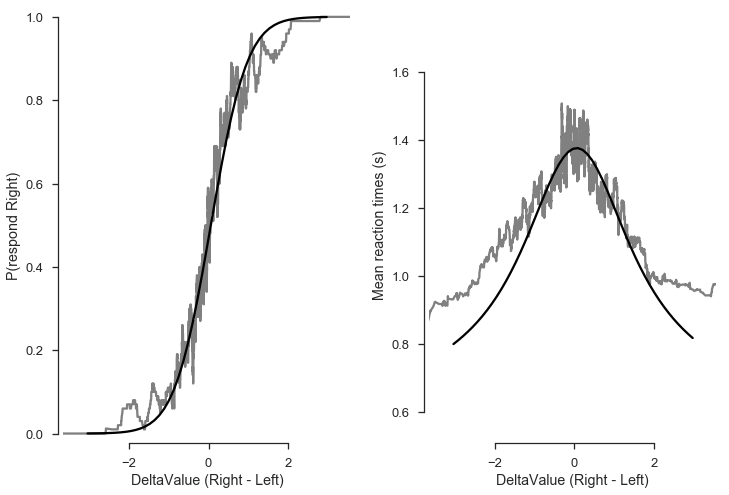

In [52]:
sns.set_style('ticks')
sns.set_context('talk')
plotFoodDataWithFit(datafoodrevalplot,thetafoodreval, dt=.0005)

### Plot all trials per participants of food ReVal with fits
#### Figure S5

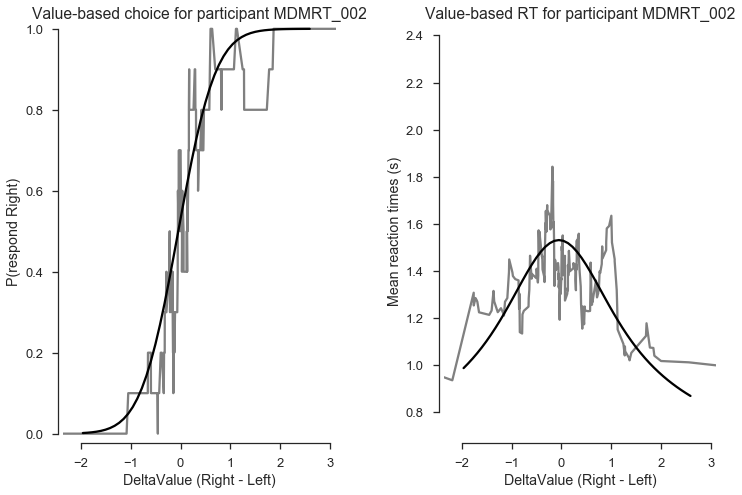

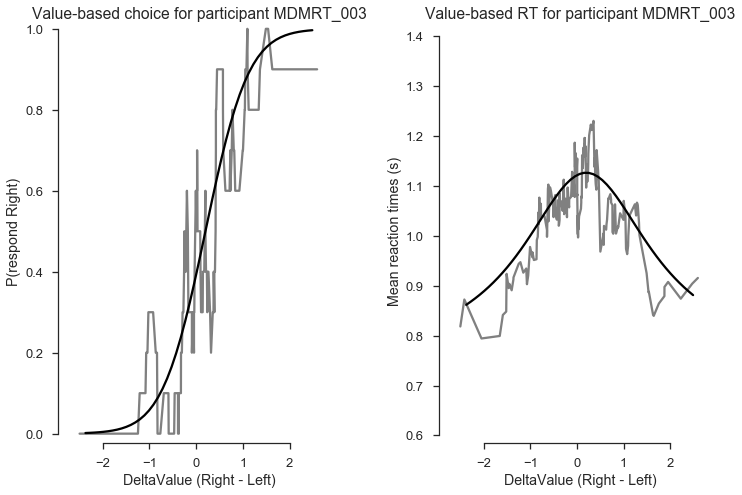

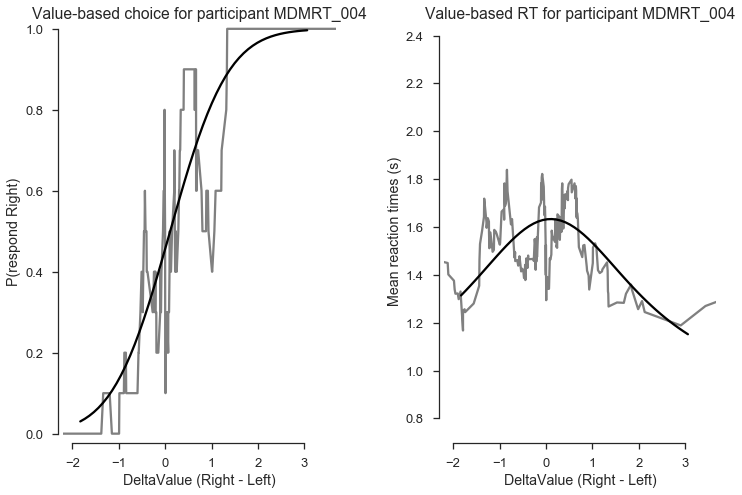

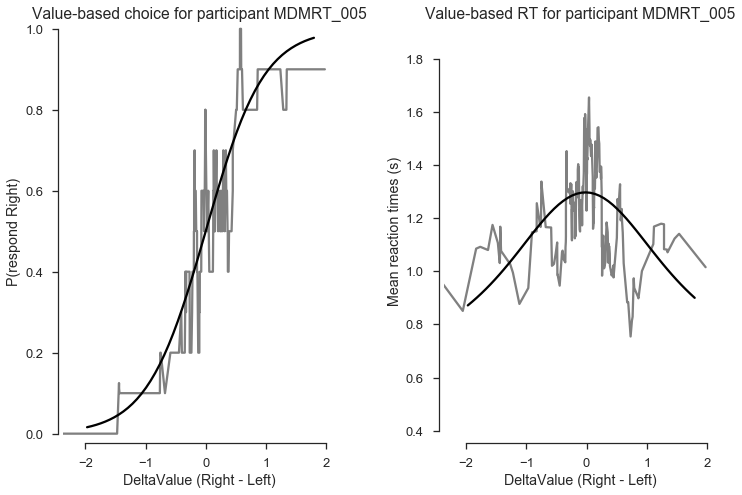

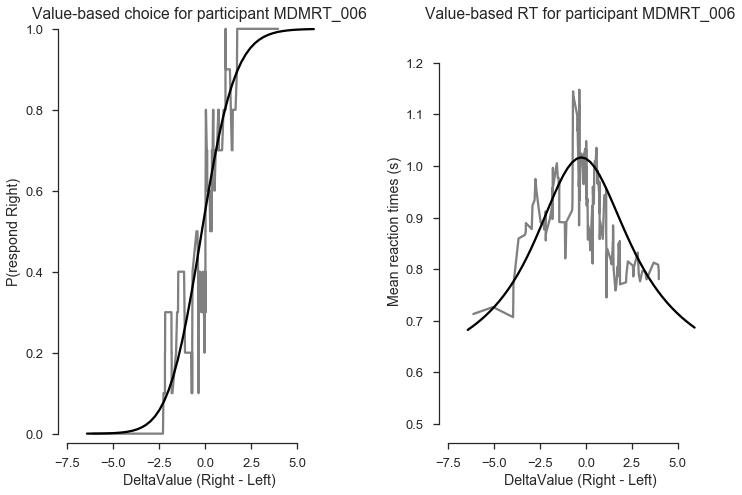

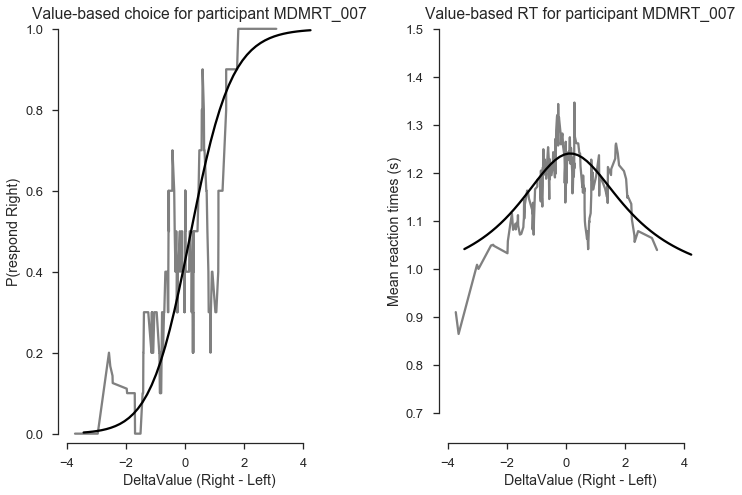

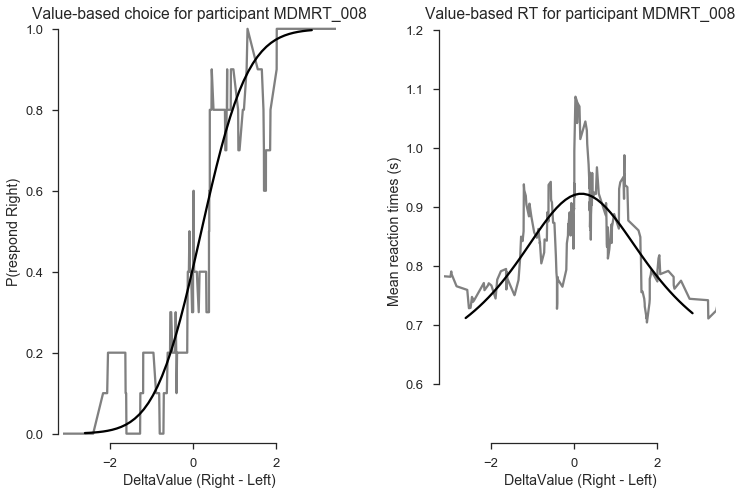

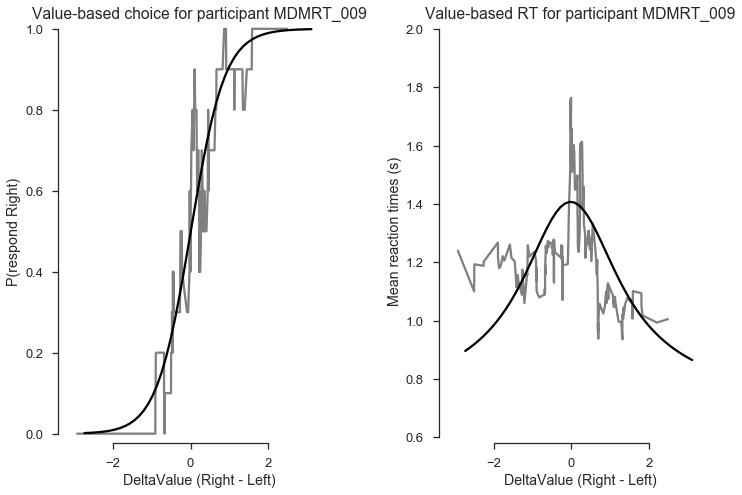

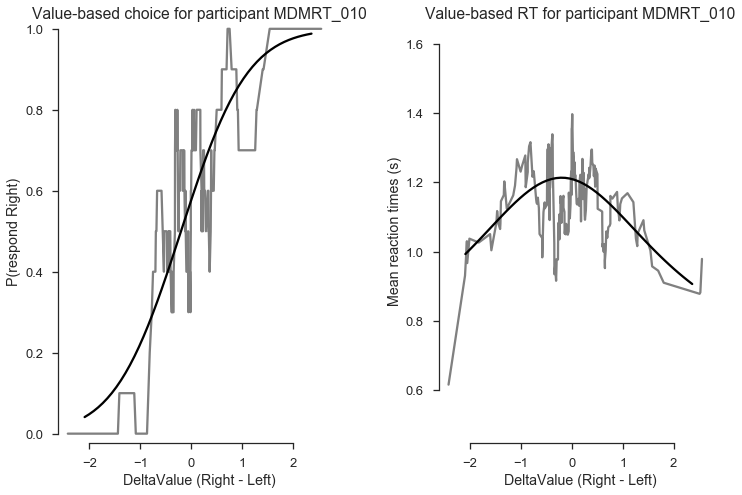

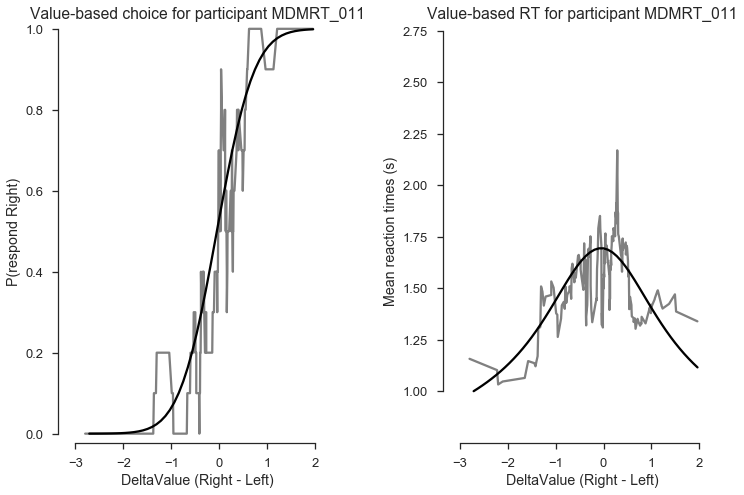

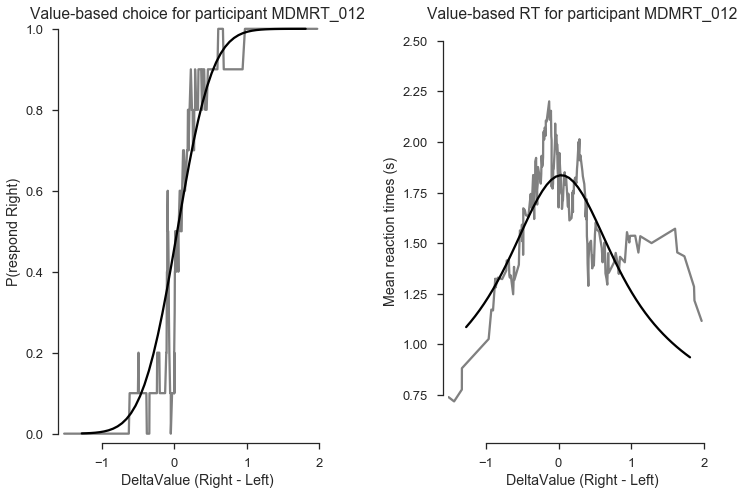

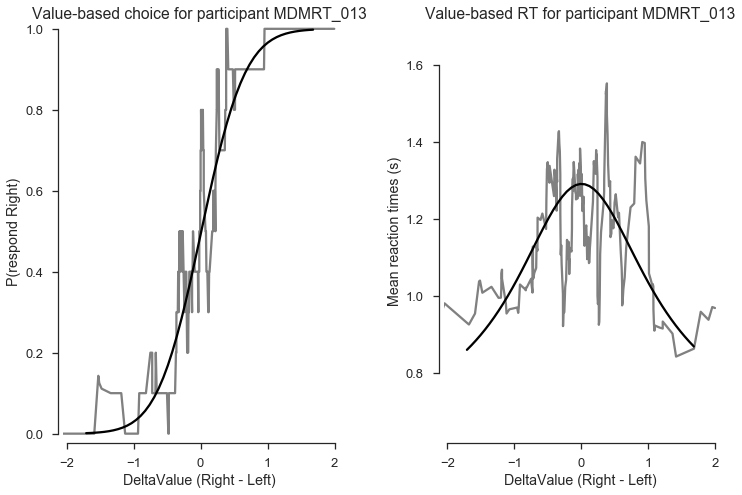

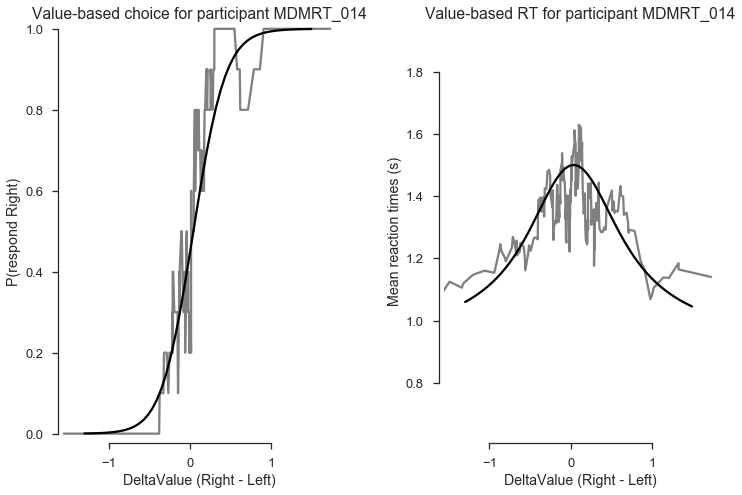

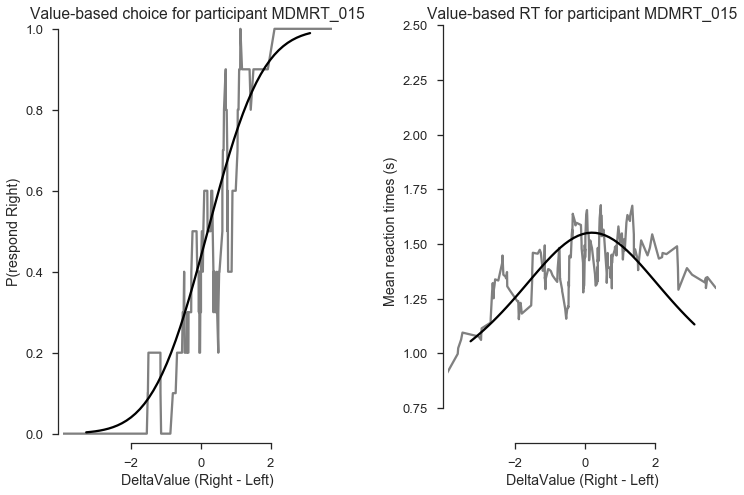

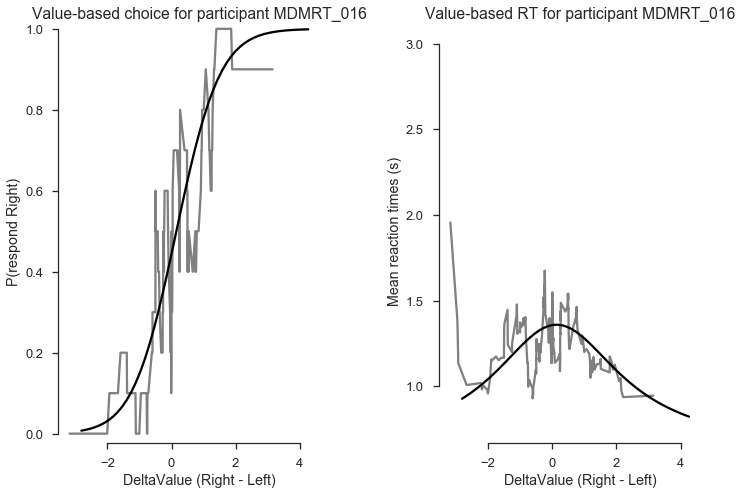

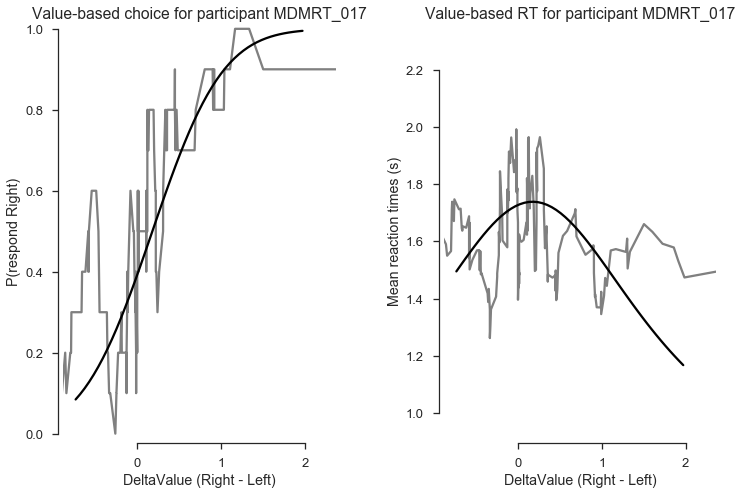

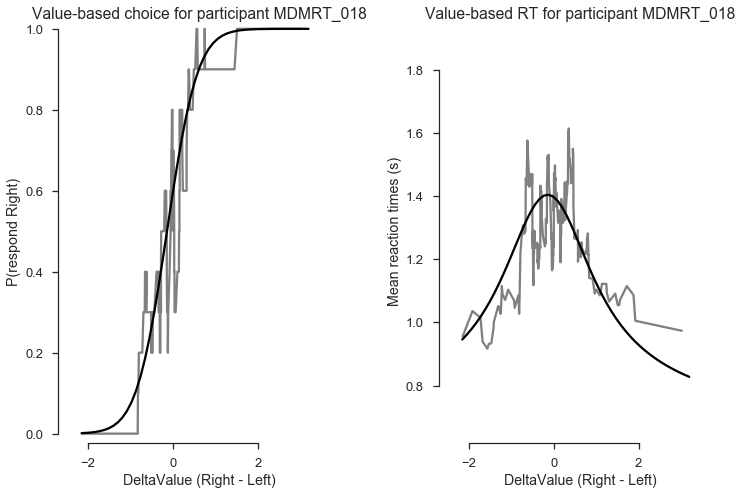

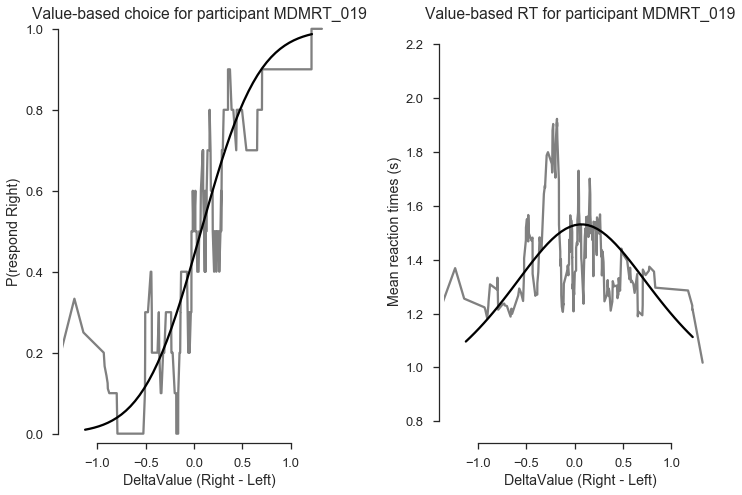

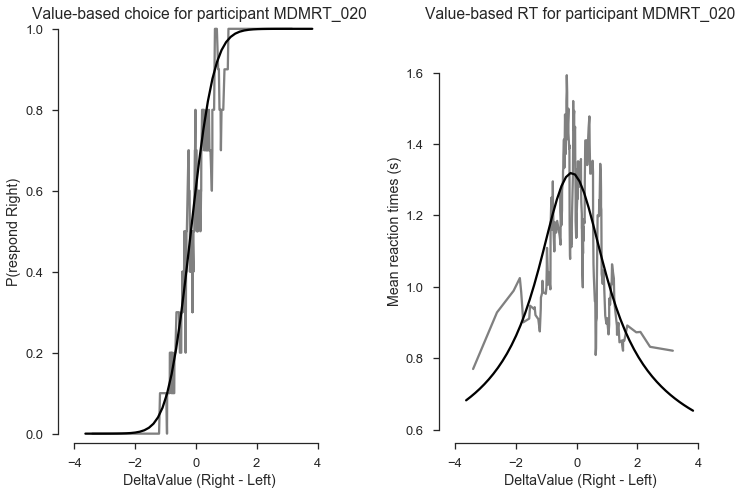

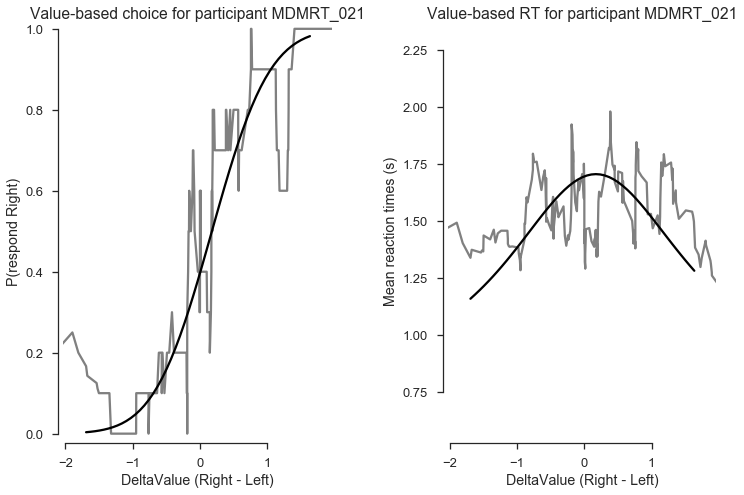

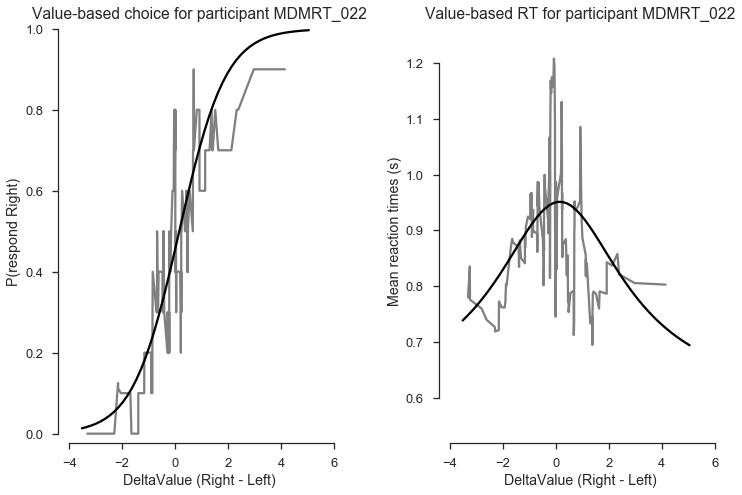

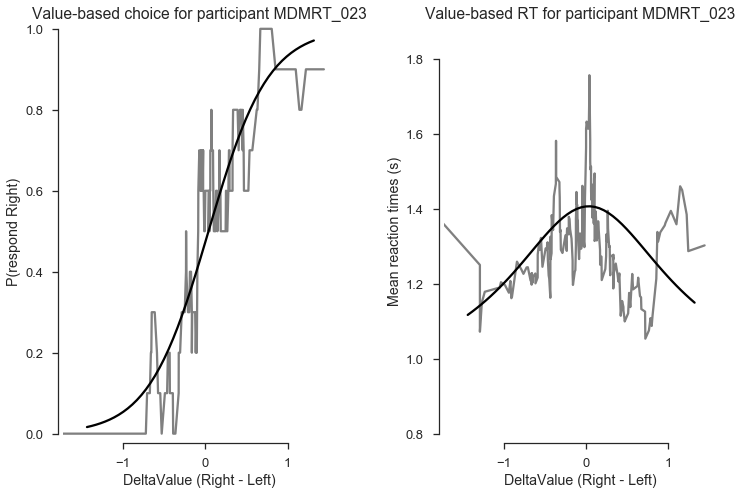

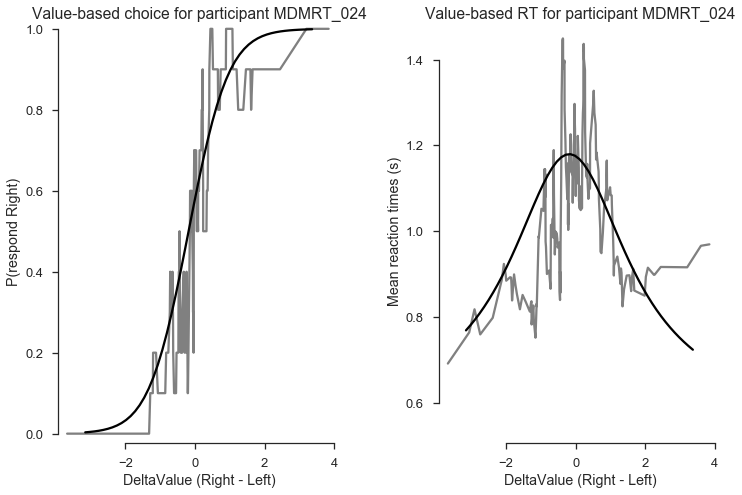

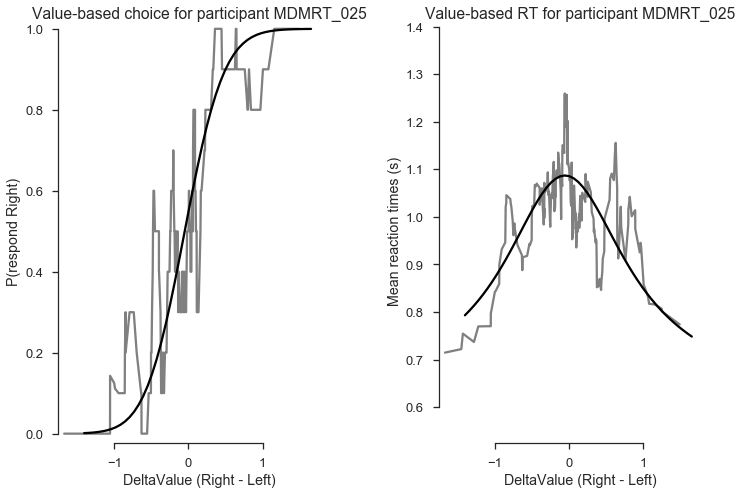

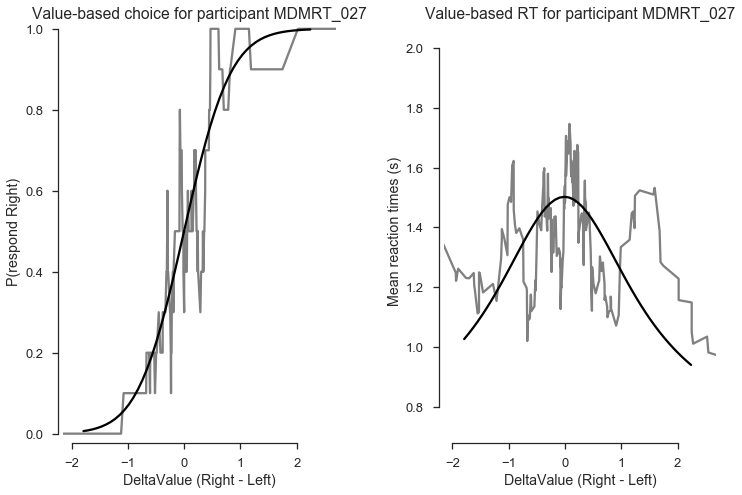

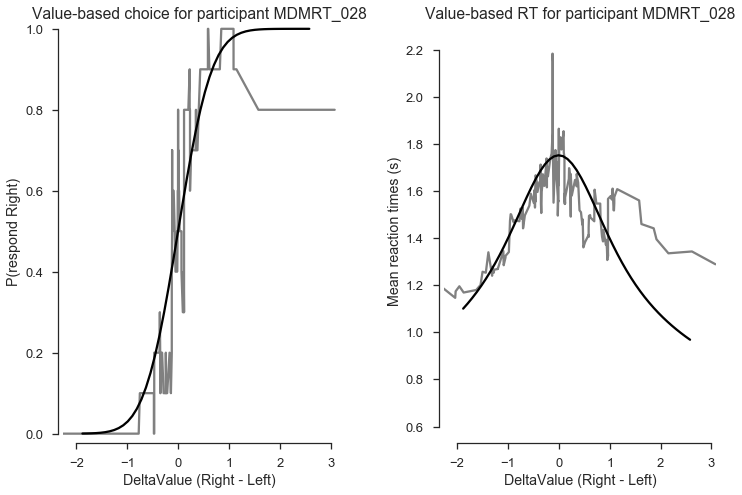

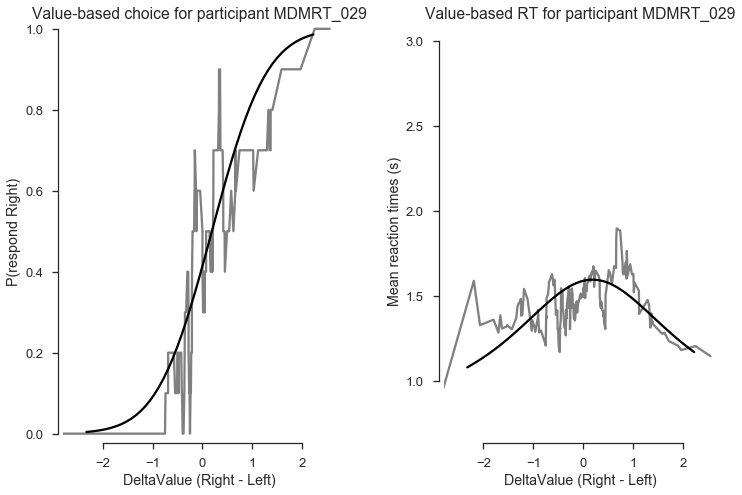

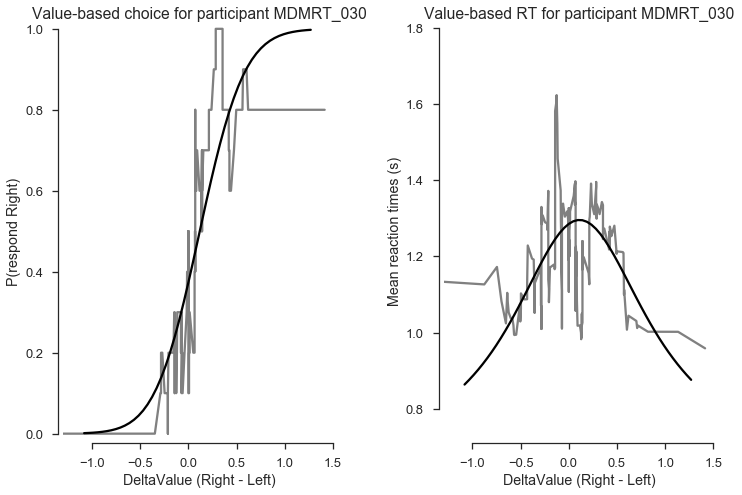

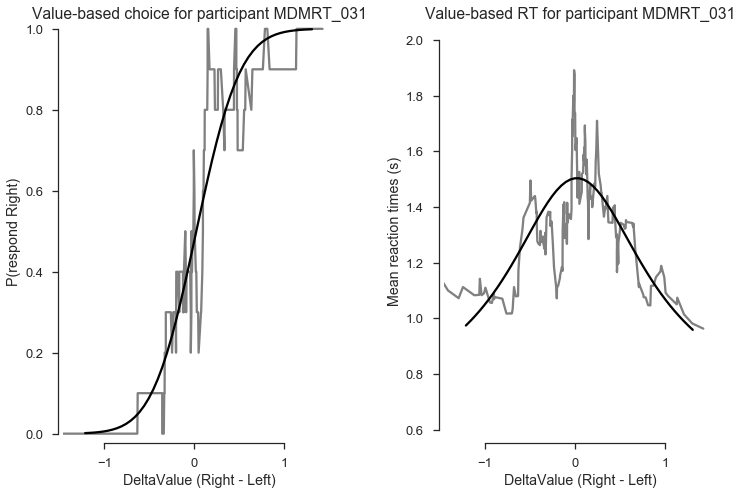

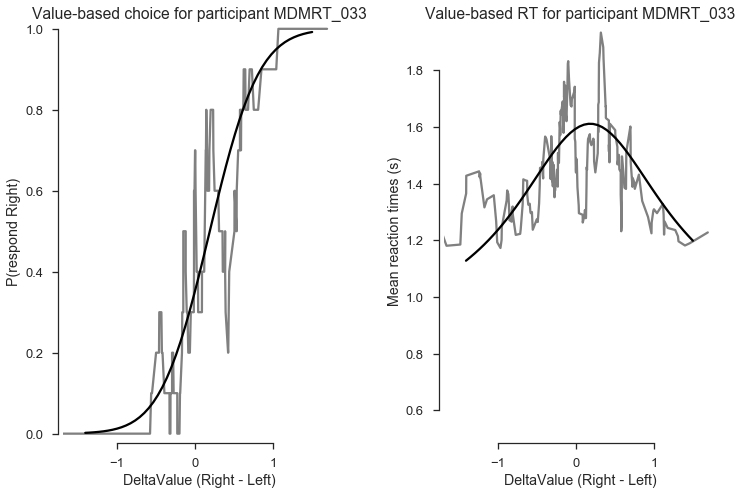

In [54]:
for s in foodreval.subjid.unique():
    foodrevalsub=foodreval.loc[foodreval['subjid']==s]
    datafoodrevalsub=np.column_stack([foodrevalsub['deltarevalrnd'],foodrevalsub['RT'],foodrevalsub['choseright'],
                                      foodrevalsub['deltareval']])
    [thetafoodrevalsub,foodrevalsubfopt]=fitData(foodrevalsub)    
    # Plot data with fits
    plotFoodsubDataWithFit(datafoodrevalsub, thetafoodrevalsub, s, dt=.005)
    outputfit(datafoodrevalsub, thetafoodrevalsub, s, 'foodreval', dt=.0005)

### Delta BIC for DDM fits based on original auction values vs. revalued values per participant
#### Figure 4B

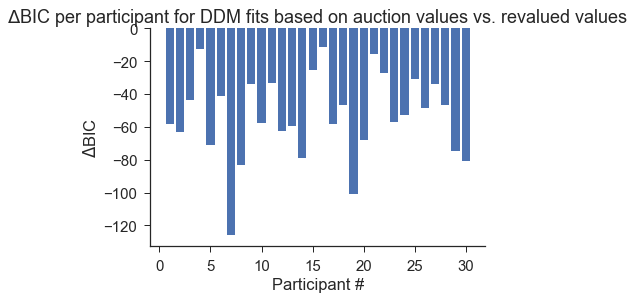

In [55]:
def calculateBIC(nll,n,k):
    bic=np.log(n)*k+2*nll
    return bic

thetafood=pd.read_csv('food_thetas_persub.csv')
thetafoodreval=pd.read_csv('foodreval_thetas_persub.csv')

foodreval = pickle.load(open( "foodreval.p", "rb" ))
food = pickle.load(open( "food.p", "rb" ))

k1=8 # 8 params for food
k2=9 # 9 params for foodreval
bic=[]
for s in food.subjid.unique():
    foodsub=food.loc[food['subjid']==s]
    n1=len(foodsub.subjid)
    foodrevalsub=foodreval.loc[foodreval['subjid']==s]
    n2=len(foodrevalsub.subjid)
    
    thetafoodall=thetafood[thetafood.subjid==s]
    nll1=thetafoodall.NLL
    thetafoodrevalall=thetafoodreval[thetafoodreval.subjid==s]
    nll2=thetafoodrevalall.NLL
    
    bic1=calculateBIC(nll1,n1,k1)
    bic2=calculateBIC(nll2,n2,k2)
    
    bic.append(float(bic2)-float(bic1))

# Plot histogram of deviances for shuffled order
#sns.set(font_scale=1.5)
#sns.set_style("white")
#sns.set_style("ticks")
plt.figure()
plt.bar(range(1,31),bic)
plt.xlabel('Participant #')
plt.ylabel(r'$\Delta$BIC')
plt.title(r'$\Delta$BIC per participant for DDM fits based on auction values vs. revalued values')
sns.despine()
plt.show()


### Map of effect of ReValued Value on BOLD
#### Figure 4C

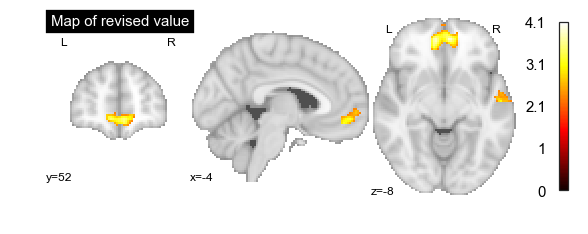

In [56]:
## Map of revised value in a model that also includes the original BDM value
revisedvalue_map=nilearn.image.load_img(imgpath+'MDMRT_scan/group/model038/task001/cope006.gfeat/cope1.feat/thresh_zstat1.nii.gz')
nilearn.plotting.plot_stat_map(revisedvalue_map,cut_coords=[-4,52,-8],draw_cross=False, 
                               title="Map of revised value")
plt.show()

## Folke et al.
### load in Folke et al. data

In [57]:
# load data for Folke et al.
folke=pd.read_csv('folke_choice.csv')

# calculate deltavalue
folke=folke.assign(deltaval=folke.ValueRight-folke.ValueLeft)

folke['deltavalrnd']=folke['deltaval'].round(1)
datafolke=np.column_stack([folke['deltavalrnd'],folke['rt'],folke['choseright']])
datafolkeplot=np.column_stack([folke['deltavalrnd'],folke['rt'],folke['choseright'],
                          folke['subjid'],folke['deltaval']])

### Fit DDM to Folke et al. data based on original data

In [58]:
# fit DDM to Folke et al. data
[thetafolke, folkefopt]=fitData(datafolke, dt=.0005)

### Plot average choice/rt curves and DDM fits for combined Folke et al. data across all trials/participants
#### Figure S6C inset green (no reval)

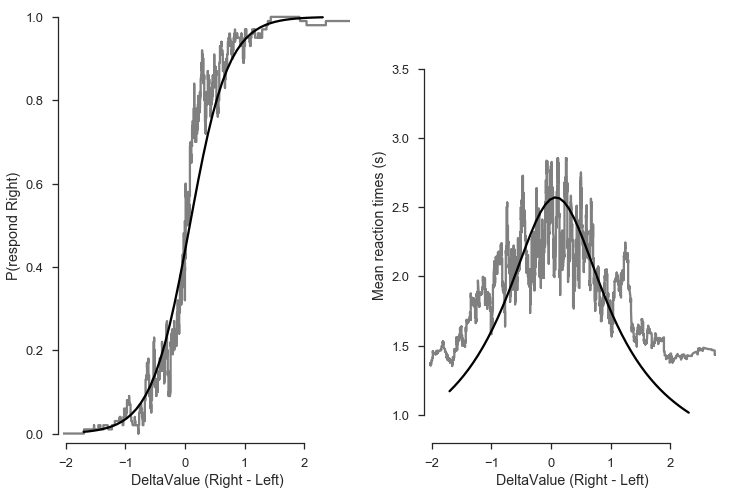

In [59]:
sns.set_style('ticks')
sns.set_context('talk')
plotFoodDataWithFit(datafolkeplot,thetafolke, dt=.0005)

### Calculate revalued values per Folke participant

In [60]:
def do_optim_folke(s):
    tlow=-0.6
    thigh=0.6
    folke=pd.read_csv('folke_choice.csv')
    #rename columns so names conform with columns in food dataframe so fn_reval will work properly
    folke=folke.assign(ImageLeft=folke.LeftItem)
    folke=folke.assign(ImageRight=folke.RightItem)
    folke=folke.assign(bidLeft=folke.ValueLeft)
    folke=folke.assign(bidRight=folke.ValueRight)
    folke=folke.assign(RT=folke.rt)
    uni_subj=folke['subjid'].unique()
    folkesub=folke[folke['subjid']==uni_subj[s]]
    fn_fit = lambda x: fn_reval(x, folkesub)[0]
    # eval best delta_v:
    xopt=scipy.optimize.fminbound(func=fn_fit,x1=tlow,x2=thigh,disp=False)
    dev_opt=[uni_subj[s],fn_fit(xopt),xopt]
    return dev_opt

# run revalueation algorithm on Folke participants in parallel
inputs = range(len(folke['subjid'].unique()))
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(do_optim_folke)(i) for i in inputs)
# convert output to dataframe to make life easier
dev_opt_folke=pd.DataFrame(results,columns=['subjid','opt_dev','opt_deltav'])

### Calculate revaluation for Folke participants based on fake choices

In [61]:
# calculate the optimal delta_v if choices are sampled from a logistic seed
logit_seed=783833
np.random.seed(logit_seed)

#rename columns so names conform with columns in food dataframe so fn_reval will work properly
folke=folke.assign(ImageLeft=folke.LeftItem)
folke=folke.assign(ImageRight=folke.RightItem)
folke=folke.assign(bidLeft=folke.ValueLeft)
folke=folke.assign(bidRight=folke.ValueRight)
folke=folke.assign(RT=folke.rt)
## make fake choices
for s in folke['subjid'].unique():
    folkesub=folke[folke['subjid']==s]
    mod=smf.glm('choseright ~ deltaval', data=folkesub,family = sm.families.Binomial())
    results = mod.fit()
    folke.loc[folke['subjid']==s,'pright_logistic']=results.predict()
folkefake=folke
folkefake['choseright']=np.random.rand(len(folke.index))<folke['pright_logistic']

def do_optim_folke_fake(s):
    tlow=-0.6
    thigh=0.6
    uni_subj=folkefake['subjid'].unique()
    folkesub=folkefake[folkefake['subjid']==uni_subj[s]]
    fn_fit = lambda x: fn_reval(x, folkesub)[0]
    # eval best delta_v:
    xopt=scipy.optimize.fminbound(func=fn_fit,x1=tlow,x2=thigh,disp=False)
    dev_opt=[uni_subj[s],fn_fit(xopt),xopt]
    return dev_opt

### Run revaluation algoritm on fake choices for Folke participants in parallel

In [62]:
inputs = range(len(folke['subjid'].unique()))
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(do_optim_folke_fake)(i) for i in inputs)
# convert output to dataframe to make life easier
dev_opt_folke_fake=pd.DataFrame(results,columns=['subjid','opt_dev','opt_deltav'])

### Plot δ from revaluation algorith output using real vs. fake choices

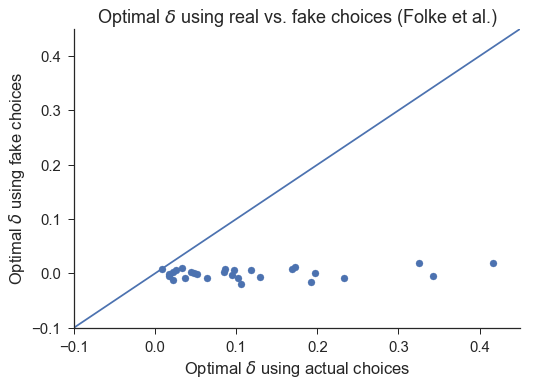

In [63]:
sns.set(font_scale=1.5)
sns.set_style("white")
sns.set_style("ticks")
plt.figure()
plt.scatter(dev_opt_folke['opt_deltav'],dev_opt_folke_fake['opt_deltav'])
plt.xlabel(r'Optimal $\delta$ using actual choices')
plt.ylabel(r'Optimal $\delta$ using fake choices')
plt.title(r'Optimal $\delta$ using real vs. fake choices (Folke et al.)')
plt.axis([-.1, .45, -.1, .45])
plt.plot( [-.1,.45],[-.1,.45] )
sns.despine()
plt.show()

### Refit Folke et al. DDMs using revalued values

In [65]:
def fn_reval(delta_v,foodsub):
    # get number of trials
    ntrials=len(foodsub['subjid'])
    # make empty dataframe to populate with revalued values
    revalsub=pd.DataFrame(np.zeros((ntrials,2)),columns=['RevalueLeft','RevalueRight'])
    # get item names placed on left and right side of screen for all trials
    item=foodsub['ImageLeft']
    item=item.append(foodsub['ImageRight'])
    # get initial auction values for items on left and right for all trials
    value=foodsub['bidLeft']
    value=value.append(foodsub['bidRight'])
    # create a dataframe with item names and initial auction values
    tmp=pd.DataFrame({'item':item,'value':value})
    # create dataframe with 60 item names and initial auction values to be updated per trial
    value=tmp.groupby(['item'],as_index=False).mean()
    # go through trials to update values
    for t in range(ntrials):
        # get values for item on left and right from updated value dataframe
        valueleft=value[value['item']==foodsub.iloc[t]['ImageLeft']]['value']
        valueright=value[value['item']==foodsub.iloc[t]['ImageRight']]['value']
        # assign updated value for items on left and right on current trial
        revalsub.iloc[t]['RevalueLeft']= valueleft
        revalsub.iloc[t]['RevalueRight']= valueright
        # if right item chosen, increment value of item on right and decrement value of item on left
        if foodsub.iloc[t]['choseright']:
            value.loc[value['item']==foodsub.iloc[t]['ImageLeft'],'value']= valueleft - delta_v
            value.loc[value['item']==foodsub.iloc[t]['ImageRight'],'value']= valueright + delta_v
        # else if left item chosen, increment value of item on left and decrement value of item on right
        else:
            value.loc[value['item']==foodsub.iloc[t]['ImageLeft'],'value']= valueleft + delta_v
            value.loc[value['item']==foodsub.iloc[t]['ImageRight'],'value']= valueright - delta_v
    # calculate deltaval from revalued values
    revalsub['deltareval']=revalsub['RevalueRight'].values-revalsub['RevalueLeft'].values
    # choices and subject columns in ravalued dataframe
    revalsub['choseright']=foodsub['choseright'].values.astype('bool')
    revalsub['RT']=foodsub['RT'].values
    revalsub['ImageRight']=foodsub['ImageRight'].values
    revalsub['ImageLeft']=foodsub['ImageLeft'].values
    revalsub['subjid']=foodsub['subjid'].values
    # calculate goodness of fit to revalued values and output deviance
    mod=smf.glm('choseright ~ RevalueLeft + RevalueRight', data=revalsub,family = sm.families.Binomial())
    try:
        results = mod.fit()
        devsub=results.deviance
    except:
        pass
        devsub=9999
    return devsub, revalsub

folke=pd.read_csv('folke_choice.csv')
dev_opt_folke=pickle.load(open('dev_opt_folke.p','rb'))

## Plot Choices and RTs based on revised values
folkereval=pd.DataFrame(columns=['RevalueLeft','RevalueRight','deltareval','choseright','subjid'])

folke=folke.assign(ImageLeft=folke.LeftItem)
folke=folke.assign(ImageRight=folke.RightItem)
folke=folke.assign(bidLeft=folke.ValueLeft)
folke=folke.assign(bidRight=folke.ValueRight)
folke=folke.assign(RT=folke.rt)

for s in folke['subjid'].unique():
    dv=dev_opt_folke['opt_deltav'][dev_opt_folke['subjid']==s].values
    subfolke=folke[folke['subjid']==s]
    tmp=fn_reval(dv,subfolke)[1]
    folkereval=folkereval.append(tmp)

#folkereval['choseright']=folke['choseright'].values
folkereval['deltarevalrnd']=folkereval['deltareval'].round(1)
datafolkereval=np.column_stack([folkereval['deltarevalrnd'],folkereval['RT'],folkereval.choseright.astype('bool')])
datafolkerevalplot=np.column_stack([folkereval['deltarevalrnd'],folkereval['RT'],folkereval['choseright'],
                          folkereval['subjid'],folkereval['deltareval']])

In [66]:
# fit DDM to Folke et al. data
[thetafolkereval, folkerevalfopt]=fitData(datafolkereval, dt=.005)

/Users/akram/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: overflow encountered in multiply
/Users/akram/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:79: RuntimeWarning: invalid value encountered in multiply
/Users/akram/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:96: RuntimeWarning: invalid value encountered in less
/Users/akram/anaconda2/lib/python2.7/site-packages/numpy/fft/fftpack.py:288: RuntimeWarning: invalid value encountered in multiply
  return output * (1 / (sqrt(n) if unitary else n))
/Users/akram/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:85: RuntimeWarning: invalid value encountered in multiply
/Users/akram/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:86: RuntimeWarning: invalid value encountered in multiply
/Users/akram/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:87: RuntimeWarning: invalid value encountered in multiply
/Users/akram/anaconda2/lib/python2.7/sit

### Plot average choice/rt curves and DDM fits for combines Folke et al. data across all trials/participants after revaluation
#### Figure S6C inset red (reval)

/Users/akram/anaconda2/lib/python2.7/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/Users/akram/anaconda2/lib/python2.7/site-packages/matplotlib/transforms.py:963: ComplexWarning: Casting complex values to real discards the imaginary part
  self._points[:, 0] = interval


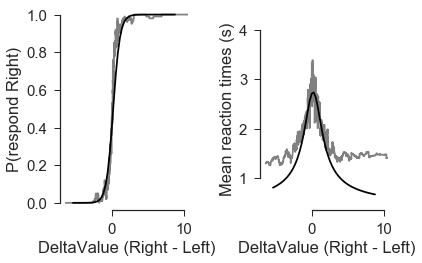

In [67]:
#Plot Folke et al. reval data with fit
plotFoodDataWithFit(datafolkerevalplot,thetafolkereval, dt=.005)

### Shuffle Folke et al. trial order 1000 times

In [68]:
# make all trial shuffled dataframes
shuffle_seed=9354

np.random.seed(shuffle_seed)

def shuffledf(i):
    folke=pd.read_csv('/Users/akram/Dropbox/MDMRT/Tasks/MDMRT_scan/Manuscript/Figures/folke_choice.csv')
    folkeshuffle=pd.DataFrame(columns=folke.columns)
    for s in folke['subjid'].unique():
        folkesub=folke[folke['subjid']==s]
        folkesubshuffle=folkesub.sample(frac=1).reset_index(drop=True)
        folkeshuffle=folkeshuffle.append(folkesubshuffle)
    folkeshuffle.to_csv('folkeshuffle'+str(i)+'.csv')
    return

niter=1000
inputs = range(niter)
num_cores = multiprocessing.cpu_count()
results=Parallel(n_jobs=num_cores)(delayed(shuffledf)(i) for i in inputs)

### Run revaluation algorithm on each of the shuffled Folke et al. datasets

In [69]:
def do_optim_folke_shuffle(i):
    tlow=-0.6
    thigh=0.6
    folke=pd.read_csv('folkeshuffle'+str(i)+'.csv',header=0,index_col=0)
    folke=folke.assign(ImageLeft=folke.LeftItem)
    folke=folke.assign(ImageRight=folke.RightItem)
    folke=folke.assign(bidLeft=folke.ValueLeft)
    folke=folke.assign(bidRight=folke.ValueRight)
    folke=folke.assign(RT=folke.rt)
    uni_subj=folke['subjid'].unique()
    dev_opt=np.ones(len(uni_subj))*np.nan
    for s in range(len(uni_subj)):
        folkesub=folke[folke['subjid']==uni_subj[s]]
        fn_fit = lambda x: fn_reval(x, folkesub)[0]
        # eval best delta_v:
        xopt=scipy.optimize.fminbound(func=fn_fit,x1=tlow,x2=thigh,disp=False)
        dev_opt[s]=fn_fit(xopt)
    print('Done with iteration '+str(i)+'......')
    return [i, dev_opt.sum()]

In [70]:
# run 1000 times SLOW
niter=1000
# run revaluation algoritm on shuffled trials
inputs = range(niter)
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(do_optim_folke_shuffle)(i) for i in inputs)
## convert output to dataframe to make life easier
dev_opt_folke_shuffle=pd.DataFrame(results,columns=['iter','opt_dev'])

### Plot Deviance for logistic fit for Folke et al. data using original values, revalued values and revalued values following shuffled trial order
#### Figure S6C

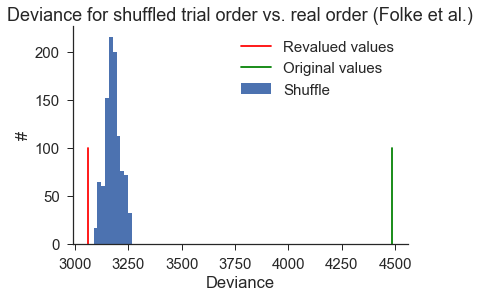

In [71]:
# get deviance for original values actual order
dev_opt_folke_orig=[]
for s in folke['subjid'].unique():
    folkesub=folke[folke['subjid']==s]
    tmp=fn_reval(0,folkesub)[0]
    dev_opt_folke_orig.append(tmp)
    
# deviances for 1000 iterations of shuffled trial order
dev_opt_folke = pickle.load( open( "folke/dev_opt_folke.p", "rb" ) )
dev_opt_folke_shuffle=pickle.load(open("folke/dev_opt_folke_shuffle.p",'rb'))

# deviance for revalued values actual order
revaldev=sum(dev_opt_folke['opt_dev'])

# deviance for original values actual order
origdev=sum(dev_opt_folke_orig)

# Plot histogram of deviances for shuffled order
sns.set(font_scale=1.5)
sns.set_style("white")
sns.set_style("ticks")
plt.figure()
plt.hist(dev_opt_folke_shuffle['opt_dev'],label='Shuffle')
plt.xlabel('Deviance')
plt.ylabel('#')
plt.title('Deviance for shuffled trial order vs. real order (Folke et al.)')
plt.plot([revaldev,revaldev],[0,100],'r-',label='Revalued values')
plt.plot([origdev,origdev],[0,100],'g-',label='Original values')
#plt.axis([5900,7600,0,240])
plt.legend()
sns.despine()
plt.show()

## Simulate artifactual revaluation
### Simulate values ~ $N(V_{revlast},σ$), then fit logistic to real choices and BDM values, then predict choices based on simulated values

In [72]:
def fn_value_sim(sigmavhat,sigmavsim,foodsub):
    np.random.seed(8976)
    # get number of trials
    ntrials=len(foodsub['subjid'])
    # make empty dataframe to populate with revalued values
    # get item names placed on left and right side of screen for all trials
    item=foodsub['ImageLeft']
    item=item.append(foodsub['ImageRight'])
    # get initial auction values for items on left and right for all trials
    vprime=foodsub['RevalueLeft']
    vprime=vprime.append(foodsub['RevalueRight'])
    trial=foodsub.index
    trial=trial.append(foodsub.index)
    # create a dataframe with item names and initial auction values
    tmp=pd.DataFrame({'item':item,'vprime':vprime,'trial':trial})
    tmp=tmp.assign(vhat=np.empty(len(tmp.index)))
    
    for i in tmp['item']:
        tmp2=tmp.loc[tmp['item']==i]
        tmp.loc[tmp['item']==i,'vprimelast'] = tmp2.loc[max(tmp2['trial']),'vprime']
    
    # create dataframe with 60 item names and initial auction values to be updated per trial
    value=tmp.groupby('item',as_index=False).mean()
    value=value.assign(vhat=np.clip(np.random.normal(value.vprime,sigmavhat),min(value.vprimelast),max(value.vprimelast)))
    value=value.assign(vsim=np.clip(np.random.normal(value.vhat,sigmavsim),min(value.vhat),max(value.vhat)))

    foodsub=foodsub.assign(VprimelastLeft=np.empty(len(foodsub['subjid'])))
    foodsub=foodsub.assign(VprimelastRight=np.empty(len(foodsub['subjid'])))
    foodsub=foodsub.assign(VhatLeft=np.empty(len(foodsub['subjid'])))
    foodsub=foodsub.assign(VhatRight=np.empty(len(foodsub['subjid'])))
    foodsub=foodsub.assign(VsimLeft=np.empty(len(foodsub['subjid'])))
    foodsub=foodsub.assign(VsimRight=np.empty(len(foodsub['subjid'])))
    
    for i in value['item']:
        foodsub.loc[foodsub['ImageLeft']==i,'VprimelastLeft']=value.loc[value['item']==i,'vprimelast'].values[0]
        foodsub.loc[foodsub['ImageLeft']==i,'VprimelastRight']=value.loc[value['item']==i,'vprimelast'].values[0]
        foodsub.loc[foodsub['ImageLeft']==i,'VhatLeft']=value.loc[value['item']==i,'vhat'].values[0]
        foodsub.loc[foodsub['ImageRight']==i,'VhatRight']=value.loc[value['item']==i,'vhat'].values[0]
        foodsub.loc[foodsub['ImageLeft']==i,'VsimLeft']=value.loc[value['item']==i,'vsim'].values[0]
        foodsub.loc[foodsub['ImageRight']==i,'VsimRight']=value.loc[value['item']==i,'vsim'].values[0]

    foodsub=foodsub.assign(deltaVhat=foodsub['VhatRight']-foodsub['VhatLeft'])
    foodsub=foodsub.assign(deltaVsim=foodsub['VsimRight']-foodsub['VsimLeft'])
    
    
    mod=smf.glm('choseright ~ deltareval', data=foodsub,family = sm.families.Binomial())
    results = mod.fit()
    dval=foodsub['deltareval']
    foodsub=foodsub.assign(deltareval=foodsub['deltaVhat'])
    foodsub=foodsub.assign(pright_logistic=results.predict(foodsub['deltareval'])) 
    foodsub=foodsub.assign(choserightsim=np.random.rand(len(foodsub.index))<foodsub['pright_logistic'])
    foodsub=foodsub.assign(choserightsim=foodsub['choserightsim'].astype('int'))
    foodsub=foodsub.assign(deltareval=dval)

    mod=smf.glm('choseright ~ deltareval', data=foodsub,family = sm.families.Binomial())
    results = mod.fit()
    
    mod2=smf.glm('choserightsim ~ deltaVhat', data=foodsub,family = sm.families.Binomial())
    results2 = mod2.fit()

    deltadevleft=results2.deviance-results.deviance
    
    mod3=smf.glm('choseright ~ deltaval', data=foodsub,family = sm.families.Binomial())
    results3 = mod3.fit()
    mod4=smf.glm('choserightsim ~ deltaVsim', data=foodsub,family = sm.families.Binomial())
    results4 = mod4.fit()

    deltadevright=results4.deviance-results3.deviance

    return [deltadevleft, deltadevright, foodsub]


### optimize σ as to match deviance for real data

In [73]:
def do_get_sigmas(s):
    seed=np.random.rand(30)*10000
    seed=seed.astype('int')
    np.random.seed(seed[s])
    
    food=pd.read_csv('foodreval.csv')
    uni_subs=food.subjid.unique()
    sub=uni_subs[s]
    foodsub=food[food['subjid']==sub]
    
    t2=.1
    tvals=np.linspace(0.1,5.,50)
    sigma=np.array([False]*len(tvals))    
    i=0
    for t1 in tvals:
        tmp2=[]
        for j in range(20):
            tmp2.append(fn_value_sim(t1,t2,foodsub)[0])
        if np.sum(np.array(tmp2)>0)>1:
            sigma[i]=True
            break
        i=i+1
    sigmavhat=tvals[sigma][0]
    sigma=np.array([False]*len(tvals)) 
    i=0
    for t2 in tvals:
        tmp2=[]
        for j in range(20):
            tmp2.append(fn_value_sim(sigmavhat,t2,foodsub)[1])

        if np.sum(np.array(tmp2)>0)>1:
            sigma[i]=True
            break
        i=i+1
    sigmavsim=tvals[sigma][0]
    tmp=pd.DataFrame({'subjid':[sub], 'sigmavhat':[sigmavhat],'sigmavsim':[sigmavsim]})
    print('Done with subject '+sub+'.....')
    return tmp


def get_sigmavhat(t1,*params):
    s, r = params
    food=pd.read_csv('foodreval.csv')
    uni_subs=food.subjid.unique()
    sub=uni_subs[s]
    foodsub=food[food['subjid']==sub]
    dev1=fn_value_sim(t1,.1,foodsub)[0]
    return np.abs(dev1)

def do_get_sigmavhat(i):
    rrange=(slice(0.001,2),slice(0.001,2))
    tmp=scipy.optimize.brute(get_sigmavhat_brute, rrange, args=[i], full_output=True,finish=scipy.optimize.fmin)
    return np.append(tmp[0],sub)


# run get original deviance from 100 iterations of V_hat-simulated choices in parallel
inputs = range(30)
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(do_get_sigmavhat)(i) for i in inputs)

sigmas=pd.concat(results)
 
sigmas.to_csv('foodsimvprimelast_sigmas.csv')

### Genrate 100 datasets for $\hat{V}$ and choices

In [74]:
def do_make_foodsimvprimelastiter(i):    
    np.random.seed(2543)
    seed=np.random.rand(100)*10000
    seed=seed.astype('int')
    np.random.seed(seed[i])
    sigmas=pd.read_csv('foodsimvprimelast_sigmas.csv')
    food=pd.read_csv('foodreval.csv')
    food=food.assign(choseright=food['choseright'].astype('int'))
    foodsim=pd.DataFrame(columns=[u'Unnamed: 0', u'ImageLeft', u'ImageRight', u'RT', u'RevalueLeft',
                                  u'RevalueRight', u'choseright', u'deltareval', u'subjid', u'bidLeft',
                                  u'bidRight', u'deltaval'])

    for s in food.subjid.unique():
        sigmavhat=sigmas.loc[sigmas['subjid']==s,'sigmavhat'].values
        sigmavsim=sigmas.loc[sigmas['subjid']==s,'sigmavsim'].values
        foodsub=food[food['subjid']==s]
        [deltadevleft,deltadevright,tmp]=fn_value_sim(sigmavhat,sigmavsim,foodsub)
        foodsim=foodsim.append(tmp)
        
    print('Done with iteration '+str(i)+'.....')
    foodsim.to_csv('foodsimvprimelastiter'+str(i)+'.csv')

inputs = range(100)
num_cores = multiprocessing.cpu_count()
Parallel(n_jobs=num_cores)(delayed(do_make_foodsimvprimelastiter)(i) for i in inputs)

### Calculate various deviance scores

In [75]:
def get_orig_dev_revallast(foodsub):
    mod=smf.glm('choseright ~ VhatLeft + VhatRight', data=foodsub,family = sm.families.Binomial())
    try:
        results = mod.fit()
        devsub=results.deviance
    except:
        pass
        devsub=9999
    return devsub

def get_orig_dev_reval(foodsub):
    mod=smf.glm('choseright ~ RevalueLeft + RevalueRight', data=foodsub,family = sm.families.Binomial())
    try:
        results = mod.fit()
        devsub=results.deviance
    except:
        pass
        devsub=9999
    return devsub

def get_orig_dev(foodsub):
    mod=smf.glm('choseright ~ bidLeft + bidRight', data=foodsub,family = sm.families.Binomial())
    try:
        results = mod.fit()
        devsub=results.deviance
    except:
        pass
        devsub=9999
    return devsub

food=pd.read_csv('simvprimelast/foodsimvprimelastiter0.csv',header=0,index_col=0)
uni_subj=food['subjid'].unique()
dev_orig_revallast=pd.DataFrame(columns=['orig_dev_revallast','orig_dev_reval','orig_dev','subjid'])
for s in uni_subj:
        foodsub=food[food['subjid']==s]
        subdevrevallast=get_orig_dev_revallast(foodsub)
        subdevreval=get_orig_dev_reval(foodsub)
        subdevorig=get_orig_dev(foodsub)
        tmp=pd.DataFrame({'subjid':[s],'orig_dev_revallast':[subdevrevallast],
                          'orig_dev_reval':[subdevreval],'orig_dev':[subdevorig]})
        dev_orig_revallast=dev_orig_revallast.append(tmp)

def get_orig_dev_Vhatsimch(foodsub):
    mod=smf.glm('choserightsim ~ VhatLeft + VhatRight', data=foodsub,family = sm.families.Binomial())
    try:
        results = mod.fit()
        devsub=results.deviance
    except:
        pass
        devsub=9999
    return devsub

def get_orig_dev_Vsimchsim(foodsub):
    mod=smf.glm('choserightsim ~ VsimLeft + VsimRight', data=foodsub,family = sm.families.Binomial())
    try:
        results = mod.fit()
        devsub=results.deviance
    except:
        pass
        devsub=9999
    return devsub

dev_orig_revallastsim=pd.DataFrame(columns=['iter','subjid','orig_dev_vhatsimch','orig_dev_vsimchsim'])
for i in range(100):
    food=pd.read_csv('simvprimelast/foodsimvprimelastiter'+str(i)+'.csv',header=0,index_col=0)
    uni_subj=food['subjid'].unique()
    for s in uni_subj:
        foodsub=food[food['subjid']==s]
        subdevvhatsimch=get_orig_dev_Vhatsimch(foodsub)
        subdevvhsimchsim=get_orig_dev_Vsimchsim(foodsub)
        tmp=pd.DataFrame({'iter':[i],'subjid':[s],'orig_dev_vhatsimch':[subdevvhatsimch],
                          'orig_dev_vsimchsim':[subdevvhsimchsim]})
        dev_orig_revallastsim=dev_orig_revallastsim.append(tmp)

## Set up revaluation function to update $V_{sim}$ based on $V_{sim}$-derived choices

In [76]:
## Calculate revalued values

def fn_reval_sim(delta_v,foodsub):
    # get number of trials
    ntrials=len(foodsub['subjid'])
    # make empty dataframe to populate with revalued values
    revalsub=pd.DataFrame(np.zeros((ntrials,2)),columns=['RevalueLeftsim','RevalueRightsim'])
    # get item names placed on left and right side of screen for all trials
    item=foodsub['ImageLeft']
    item=item.append(foodsub['ImageRight'])
    # get initial auction values for items on left and right for all trials
    value=foodsub['VsimLeft']
    value=value.append(foodsub['VsimRight'])
    # create a dataframe with item names and initial auction values
    tmp=pd.DataFrame({'item':item,'value':value})
    # create dataframe with 60 item names and initial auction values to be updated per trial
    value=tmp.groupby(['item'],as_index=False).mean()
    # go through trials to update values
    for t in range(ntrials):
        # get values for item on left and right from updated value dataframe
        valueleft=value[value['item']==foodsub.iloc[t]['ImageLeft']]['value']
        valueright=value[value['item']==foodsub.iloc[t]['ImageRight']]['value']
        # assign updated value for items on left and right on current trial
        revalsub.iloc[t]['RevalueLeftsim']= valueleft
        revalsub.iloc[t]['RevalueRightsim']= valueright
        # if right item chosen, increment value of item on right and decrement value of item on left
        if foodsub.iloc[t]['choserightsim']:
            value.loc[value['item']==foodsub.iloc[t]['ImageLeft'],'value']= valueleft - delta_v
            value.loc[value['item']==foodsub.iloc[t]['ImageRight'],'value']= valueright + delta_v
        # else if left item chosen, increment value of item on left and decrement value of item on right
        else:
            value.loc[value['item']==foodsub.iloc[t]['ImageLeft'],'value']= valueleft + delta_v
            value.loc[value['item']==foodsub.iloc[t]['ImageRight'],'value']= valueright - delta_v
    # calculate deltaval from revalued values
    revalsub['deltarevalsim']=revalsub['RevalueRightsim'].values-revalsub['RevalueLeftsim'].values
    # choices and subject columns in ravalued dataframe
    revalsub['choserightsim']=foodsub['choserightsim'].values.astype('bool')
    revalsub['RT']=foodsub['RT'].values
    revalsub['ImageRight']=foodsub['ImageRight'].values
    revalsub['ImageLeft']=foodsub['ImageLeft'].values
    revalsub['subjid']=foodsub['subjid'].values
    # calculate goodness of fit to revalued values and output deviance
    mod=smf.glm('choserightsim ~ RevalueLeftsim + RevalueRightsim', data=revalsub,family = sm.families.Binomial())
    try:
        results = mod.fit()
        devsub=results.deviance
    except:
        pass
        devsub=9999
    return devsub, revalsub

def do_optim_sim(i):
    tlow=-.6
    thigh=.6
    foodsim=pd.read_csv('foodsimvprimelastiter'+str(i)+'.csv',header=0,index_col=0)
    uni_subj=food['subjid'].unique()
    dev_opt_sim=pd.DataFrame(columns=['iter','opt_deltav','opt_dev','subjid'])
    ind=i*len(uni_subj)
    for s in uni_subj:
        foodsub=foodsim[food['subjid']==s]
        fn_fit = lambda x: fn_reval_sim(x, foodsub)[0]
        # eval best delta_v:
        xopt=scipy.optimize.fminbound(func=fn_fit,x1=tlow,x2=thigh,disp=False)
        tmp=pd.DataFrame({'subjid':s,'iter':i,'opt_dev':fn_fit(xopt),'opt_deltav':xopt}, index=[ind])
        ind=ind+1
        dev_opt_sim=dev_opt_sim.append(tmp)
    return dev_opt_sim


## run revaluation function for simulated choices and simulated values on all participants in parallel

In [77]:
# run revaluation on BDM values from 100 iterations of V_hat-simulated choices in parallel
inputs = range(100)
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(do_optim_sim)(i) for i in inputs)
# convert output to dataframe to make life easier
dev_opt_sim=pd.concat(results)
pickle.dump(dev_opt_sim,open('dev_opt_valuesimvprimelastiter.p','wb'))

### generate 100 shuffles per simulated dataset

In [78]:
# make all trial shuffled dataframes
shuffle_seed=8220

np.random.seed(shuffle_seed)

def shuffledf(i):
    food=pd.read_csv('simvprimelast/foodsimvprimelastiter'+str(i)+'.csv',header=0,index_col=0)
    for j in range(100):
        foodshuffle=pd.DataFrame(columns=food.columns)
        for s in food['subjid'].unique():
            foodsub=food[food['subjid']==s]
            foodsubshuffle=foodsub.sample(frac=1).reset_index(drop=True)
            foodshuffle=foodshuffle.append(foodsubshuffle)
        foodshuffle.to_csv('simvprimelast/foodsimvprimelastiter'+str(i)+'shuffle'+str(j)+'.csv')
    return

for i in range(100):
    shuffledf(i)

### Run revaluation on each of 100 shuffled datasets of each of the 100 simulated datasets

In [79]:
def do_optim_simshuffle(i,j):
    tlow=-1
    thigh=1
    food=pd.read_csv('simvprimelast/foodsimvprimelastiter'+str(i)+'shuffle'+str(j)+'.csv',header=0,index_col=0)
    uni_subj=food['subjid'].unique()
    dev_opt=np.ones(len(uni_subj))*np.nan
    deltav_opt=np.ones(len(uni_subj))*np.nan
    subs=[]
    iters =[]
    for s in range(len(uni_subj)):
        foodsub=food[food['subjid']==uni_subj[s]]
        fn_fit = lambda x: fn_reval_sim(x, foodsub)[0]
        # eval best delta_v:
        xopt=scipy.optimize.fminbound(func=fn_fit,x1=tlow,x2=thigh,disp=False)
        dev_opt[s]=fn_fit(xopt)
        deltav_opt[s]=xopt
        subs.append(uni_subj[s])
        iters.append(i)
    return pd.DataFrame(np.transpose([iters, subs, dev_opt, deltav_opt]),columns=['iter','subjid','opt_dev','opt_deltav'])

# run revaluation 10000 times SLOW.
for i in range(100):
    for j in range(100):
        # run revaluation algoritm on shuffled trials
        dev_opt_simshuffle=do_optim_simshuffle(i,j)
        dev_opt_simshuffle.to_csv('simvprimelast_shuffle/dev_opt_simvprimelast_iter'+str(i)+'shuffle'+str(j)+'.csv')

### Compile shuffled simulates data outputs

In [80]:
dev_opt_sim_shuffle=pd.DataFrame([],columns=['Unnamed: 0','iter','shuffle','subjid','opt_dev','opt_deltav'])
for i in range(100):
    for j in range(100):
        tmp=pd.read_csv('simvprimelast/dev_opt_simvprimelast_iter'+str(i)+'shuffle'+str(j)+'.csv')
        dev_opt_sim_shuffle=dev_opt_sim_shuffle.append(tmp)
        
pickle.dump(dev_opt_sim_shuffle,open('dev_opt_sim_shuffle.p','wb'))

### Plot the distributions of deviance for simulated and shuffled simulated data along with deviance from real data
#### Figure S6D

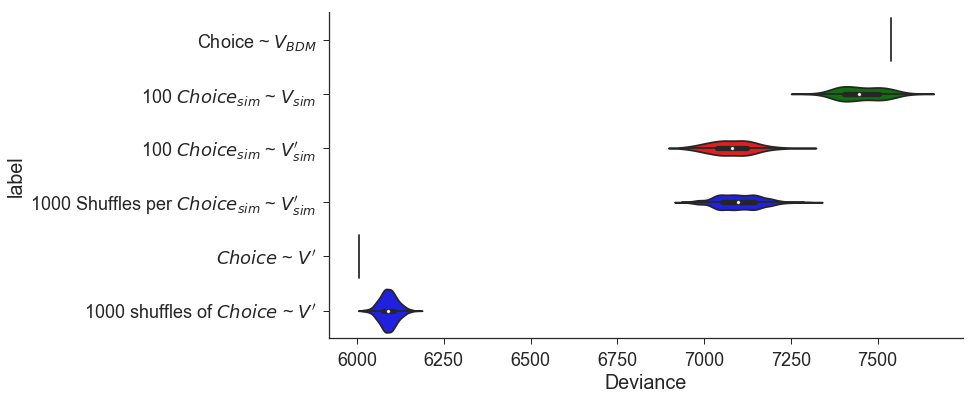

In [81]:
## get deviance for original values actual order
dev_opt_orig=[]
for s in food['subjid'].unique():
    foodsub=food[food['subjid']==s]
    tmp=fn_reval(0,foodsub)[0]
    dev_opt_orig.append(tmp)

# deviance for original values actual order
origdev=sum(dev_opt_orig)

# deviance for revalued values actual order
dev_opt=pickle.load(open('dev_opt.p','rb'))
revaldev=sum(dev_opt['opt_dev'])

# deviances before reval for 100 simulated datasets
dev_orig_sim=pickle.load(open('dev_orig_vprimelastsimiter.p','rb'))

# deviances for reval for 100 simulated datasets
dev_opt_sim=pickle.load(open('dev_opt_sim.p','rb'))

# deviances for 100 iterations of shuffled trial order for each of the 100 simulated datasets
dev_opt_sim_shuffle=pickle.load(open('dev_opt_sim_shuffle.p','rb'))

# deviances for 1000 iterations of shuffled trial order for real data
dev_opt_shuffle=pd.read_csv('dev_opt_shuffle.csv',header=0,index_col=0)

y1=origdev
y2=dev_orig_sim.groupby('iter')['orig_dev_vsim'].sum().values
y3=dev_opt_sim.groupby('iter')['opt_dev'].sum().values
y4=dev_opt_sim_shuffle.groupby(['iter','shuffle'])['opt_dev'].sum().values
y5=revaldev#+600
y6=dev_opt_shuffle.groupby('iter')['opt_dev'].sum().values#+600


x1='Choice ~ $V_{BDM}$'
x2=np.repeat('100 $Choice_{sim}$ ~ $V_{sim}$',len(y2))
x3=np.repeat('100 $Choice_{sim}$ ~ $V^\prime_{sim}$',len(y3))
x4=np.repeat('1000 Shuffles per $Choice_{sim}$ ~ $V^\prime_{sim}$',len(y4))
x5='$Choice$ ~ $V^\prime$'
x6=np.repeat('1000 shuffles of $Choice$ ~ $V^\prime$',len(y6))

d1=pd.DataFrame({'label':[x1],'Deviance':[y1]})
d2=pd.DataFrame({'label':x2,'Deviance':y2})
d3=pd.DataFrame({'label':x3,'Deviance':y3})
d4=pd.DataFrame({'label':x4,'Deviance':y4})
d5=pd.DataFrame({'label':[x5],'Deviance':[y5]})
d6=pd.DataFrame({'label':x6,'Deviance':y6})

tmp=pd.concat([d1,d2,d3,d4,d5,d6])
sns.set(font_scale=1.8)
sns.set_style("white")
sns.set_style("ticks")
plt.figure(figsize=(14,6))
sns.violinplot(x='Deviance',y='label',data=tmp,palette={'Choice ~ $V_{BDM}$':'g',
                                                        '100 $Choice_{sim}$ ~ $V_{sim}$':'g',
                                                        '$Choice$ ~ $V^\prime$':'r',
                                                      '100 $Choice_{sim}$ ~ $V^\prime_{sim}$':'r',
                                                      '1000 Shuffles per $Choice_{sim}$ ~ $V^\prime_{sim}$':'b',
                                                       '1000 shuffles of $Choice$ ~ $V^\prime$':'b'})

sns.despine()
plt.tight_layout()
plt.show()

# Evidence for the construction of value
## The value update $\delta$ for short RT differs than that for long RTs
### Calculate two $\delta$ values based on a median split on RT

In [82]:
## Calculate revalued values

def fn_reval_rt_split(theta,foodsub):
    medianrt=np.median(foodsub.RT)
    deltavlo,deltavhi = theta
    # get number of trials
    ntrials=len(foodsub['subjid'])
    # make empty dataframe to populate with revalued values
    revalsub=pd.DataFrame(np.zeros((ntrials,2)),columns=['RevalueLeft','RevalueRight'])
    # get item names placed on left and right side of screen for all trials
    item=foodsub['ImageLeft']
    item=item.append(foodsub['ImageRight'])
    # get initial auction values for items on left and right for all trials
    value=foodsub['bidLeft']
    value=value.append(foodsub['bidRight'])
    # create a dataframe with item names and initial auction values
    tmp=pd.DataFrame({'item':item,'value':value})
    # create dataframe with 60 item names and initial auction values to be updated per trial
    value=tmp.groupby(['item'],as_index=False).mean()
    # go through trials to update values
    for t in range(ntrials):
        # get values for item on left and right from updated value dataframe
        valueleft=value[value['item']==foodsub.iloc[t]['ImageLeft']]['value']
        valueright=value[value['item']==foodsub.iloc[t]['ImageRight']]['value']
        # assign updated value for items on left and right on current trial
        revalsub.iloc[t]['RevalueLeft']= valueleft
        revalsub.iloc[t]['RevalueRight']= valueright
        
        rt=foodsub.iloc[t]['RT']
        if rt < medianrt:
            delta_v=deltavlo
        else:
            delta_v=deltavhi
            
        # if right item chosen, increment value of item on right and decrement value of item on left
        if foodsub.iloc[t]['choseright']:
            value.loc[value['item']==foodsub.iloc[t]['ImageLeft'],'value']= valueleft - delta_v
            value.loc[value['item']==foodsub.iloc[t]['ImageRight'],'value']= valueright + delta_v
        # else if left item chosen, increment value of item on left and decrement value of item on right
        else:
            value.loc[value['item']==foodsub.iloc[t]['ImageLeft'],'value']= valueleft + delta_v
            value.loc[value['item']==foodsub.iloc[t]['ImageRight'],'value']= valueright - delta_v
    # calculate deltaval from revalued values
    revalsub['deltareval']=revalsub['RevalueRight'].values-revalsub['RevalueLeft'].values
    # choices and subject columns in ravalued dataframe
    revalsub['choseright']=foodsub['choseright'].values.astype('bool')
    revalsub['RT']=foodsub['RT'].values
    revalsub['ImageRight']=foodsub['ImageRight'].values
    revalsub['ImageLeft']=foodsub['ImageLeft'].values
    revalsub['subjid']=foodsub['subjid'].values
    # calculate goodness of fit to revalued values and output deviance
    mod=smf.glm('choseright ~ RevalueLeft + RevalueRight', data=revalsub,family = sm.families.Binomial())
    try:
        results = mod.fit()
        devsub=results.deviance
    except:
        pass
        devsub=9999
    return devsub

def do_optim_rt_split(s):
    tlow=[-0.6,-0.6]
    thigh=[0.6,0.6]
    food=pd.read_csv('food.csv',header=0,index_col=0)
    uni_subj=food['subjid'].unique()
    foodsub=food[food['subjid']==uni_subj[s]]
    # eval best delta_v:
    theta_init=[0,0]
    theta, xopt = fminbnd.fminbnd(fn_reval_rt_split,theta_init,args=[foodsub],LB=tlow,UB=thigh,disp=False)

    dev_opt=[uni_subj[s],theta[0],theta[1],xopt]
    return dev_opt


### Run the median RT split revaluation on 30 participants

In [83]:
# run 30 participants in parallel
inputs = range(len(food['subjid'].unique()))
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(do_optim_rt_split)(i) for i in inputs)
# convert output to dataframe to make life easier
dev_opt_rt_split=pd.DataFrame(results,columns=['subjid','opt_deltavlo','opt_deltavhi','dev'])

### Plot the $\delta_{fastRT}$ versus $\delta_{longRT}$ across the 30 participants
#### Figure S7A

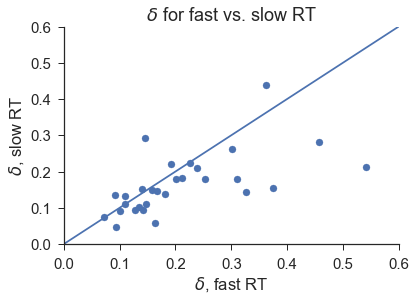

In [84]:
#Plot delta_v from revaluation algorith output using real vs. fake choices
sns.set(font_scale=1.5)
sns.set_style("white")
sns.set_style("ticks")
plt.figure()
plt.scatter(dev_opt_rt_split.opt_deltavlo,dev_opt_rt_split.opt_deltavhi)
plt.xlabel(r'$\delta$, fast RT')
plt.ylabel(r'$\delta$, slow RT')
plt.title(r'$\delta$ for fast vs. slow RT')
plt.axis([0, .6, 0, .6])
plt.plot( [0,.6],[0,.6] )
sns.despine()
plt.show()

## Choice consistency when faced with the same choice problem is related to the number of intervening trials containing the chosen item
### Calculate P(Chose consistent) and count the number of times the chosen item appears between repetitions of the same pair
#### Figure S7B

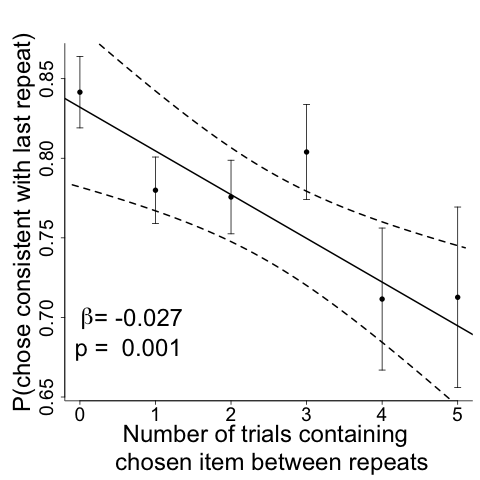

In [85]:
%%R 

load("../R/MDMRT_scan_food_extended.RData")

food$trial=food$runtrial
food$trial[food$run==2]=food$trial[food$run==2]+70
food$trial[food$run==3]=food$trial[food$run==3]+140

for (s in levels(food$subjid)){
  tmp=subset(food,food$subjid==s & food$repeated==1)
  for (p in tmp$PairNumber){
    if (p>60 & p<91){
      add=60
    }else if (p>120 & p<151){
      add=-60
    }else if (p>90 & p<121){
      add=90
    }else if (p>180 & p<211){
      add=-90
    }
    
    tmp2=subset(food,food$subjid==s & food$PairNumber==p+add)
    tmp2$firstrepeat=1
    tmp2$secondrepeat=0
    tmp3=subset(tmp,tmp$subjid==s & tmp$PairNumber==p)
    tmp3$firstrepeat=0
    tmp3$secondrepeat=1
    tmp3$PairNumber=tmp2$PairNumber
    

    food$numtrials[food$subjid==s & food$PairNumber==p]=tmp3$trial-tmp2$trial
    
    if (tmp2$Response=='3#'){
      chosenitem=tmp2$ImageLeft
      unchosenitem=tmp2$ImageRight
    } else if (tmp2$Response[1]=='4$'){
      chosenitem=tmp2$ImageRight
      unchosenitem=tmp2$ImageLeft
    } else {
      chosenitem=NA
      unchosenitem=NA
    }
    
    tmp4=subset(food,food$subjid==s & (food$ImageLeft==chosenitem | food$ImageRight==chosenitem) & food$trial>=tmp2$trial & food$trial<=tmp3$trial)
    food$chosenintervening[food$subjid==s & food$PairNumber==p]=length(tmp4$trial)-2
    
    tmp5=subset(food,food$subjid==s & (food$ImageLeft==unchosenitem | food$ImageRight==unchosenitem) & food$trial>=tmp2$trial & food$trial<=tmp3$trial)
    food$unchosenintervening[food$subjid==s & food$PairNumber==p]=length(tmp5$trial)-2
    
  }
}

mchosenintervening=aggregate(choseconsistentwithlastrepeat ~ chosenintervening + subjid ,data=food, mean)
munchosenintervening=aggregate(choseconsistentwithlastrepeat ~ unchosenintervening + subjid ,data=food, mean)

m1=tapply(food$choseconsistentwithlastrepeat,food$chosenintervening, mean)
se1=tapply(mchosenintervening$choseconsistentwithlastrepeat,mchosenintervening$chosenintervening, std.error)

par(mar=c(5.5,4.5,3,0.5), mgp=c(2.2,.6,0),oma=c(0,0,0,0),cex.lab=2,cex.axis=1.6,cex.main=2,tck=-.01)
errbar(0:5,m1,m1+se1,m1-se1,xlab="", ylab="P(chose consistent with last repeat)",bty='l')
mtext("Number of trials containing \n chosen item between repeats",1, at=2.5,line=4,cex=2)
lmmod1=lm(choseconsistentwithlastrepeat ~ chosenintervening, data=mchosenintervening)
abline(lmmod1,lwd=2)
chosenintervening<-seq(-0.1,5.1,.1)
prd<-predict(lmmod1,newdata=data.frame(x=chosenintervening),interval = c("confidence"), 
             level = 0.95,type="response")
lines(chosenintervening,prd[,2],lty=2,lwd=2)
lines(chosenintervening,prd[,3],lty=2,lwd=2)
summ=summary(lmmod1)
b=round(lmmod1$coefficients["chosenintervening"],3)
p=round(summ$coefficients["chosenintervening","Pr(>|t|)"],3)
text(.1,.7,expression(beta),cex=2)
text(.78,.7,paste("=",b),cex=2)
text(.64,.68, paste("p = ",p),cex=2)


## Comparison of post-decisional and pre-decisional (during deliberation) accounts of revaluation
### First recalculate revalued valued such that $\delta$ affects the current trial, not the next trial where the item appears
### here we will simply shift the $V_{rev}$s rather than refit $\delta$
### so we will have $\delta_{pre}$ = $\delta_{post}$

In [86]:
def fn_shift_vprime(foodsub):
    ntrials=len(foodsub['subjid'])
    # make empty dataframe to populate with revalued values
    # get item names placed on left and right side of screen for all trials
    item=foodsub['ImageLeft']
    item=item.append(foodsub['ImageRight'])
    # get initial auction values for items on left and right for all trials
    vprime=foodsub['RevalueLeft']
    vprime=vprime.append(foodsub['RevalueRight'])
    onright=np.append(np.repeat(0,len(foodsub.index)),np.repeat(1,len(foodsub.index)))
    choseright=foodsub['choseright']
    choseright=choseright.append(choseright)
    trial=foodsub.index
    trial=trial.append(foodsub.index)
    # create a dataframe with item names and initial auction values
    tmp=pd.DataFrame({'item':item,'vprime':vprime,'trial':trial,'onright':onright,'choseright':choseright})
    foodsub=foodsub.assign(revalLeftShifted=np.repeat(0,len(foodsub.index)))
    foodsub=foodsub.assign(revalRightShifted=np.repeat(0,len(foodsub.index)))
    
    for i in tmp['item']:
        tmp2=tmp.loc[tmp['item']==i]
        tmp2=tmp2.sort_index()
        delta=np.abs(tmp2.iloc[0].vprime-tmp2.iloc[1].vprime)
        st1=tmp2.loc[tmp2.trial==max(tmp2.trial),'choseright']
        st2=tmp2.loc[tmp2.trial==max(tmp2.trial),'onright']==1
        if  st1.values[0] & st2.values[0]:
            last=tmp2.loc[tmp2.trial==max(tmp2.trial),'vprime']+delta
        elif ~st1.values[0] & ~st2.values[0]:
            last=tmp2.loc[tmp2.trial==max(tmp2.trial),'vprime']+delta
        else:
            last=tmp2.loc[tmp2.trial==max(tmp2.trial),'vprime']-delta
        vp=tmp2['vprime']
        tmp2=tmp2.assign(vprime=np.append(vp[1:],last))
        foodsub.loc[foodsub['ImageLeft']==i,'revalLeftShifted']=tmp2.loc[tmp2['onright']==0,'vprime']
        foodsub.loc[foodsub['ImageRight']==i,'revalRightShifted']=tmp2.loc[tmp2['onright']==1,'vprime']
    return foodsub

food=pd.read_csv('foodreval.csv')
foodrevalshifted=pd.DataFrame(columns=[u'Unnamed: 0', u'Unnamed: 0.1', u'ImageLeft', u'ImageRight', u'RT',
       u'RevalueLeft', u'RevalueRight', u'choseright', u'deltareval',
       u'subjid', u'bidLeft', u'bidRight', u'deltaval', u'revalLeftShifted',
       u'revalRightShifted'])

for s in food.subjid.unique():
    foodsub=food[food['subjid']==s]
    tmp=fn_shift_vprime(foodsub)
    foodrevalshifted=foodrevalshifted.append(tmp)
    
foodrevalshifted=foodrevalshifted.assign(deltarevalshifted=foodrevalshifted['revalRightShifted']-foodrevalshifted['revalLeftShifted'])
foodrevalshifted=foodrevalshifted.assign(deltavalrnd=foodrevalshifted['deltarevalshifted'].round(1))
foodrevalshifted.to_csv('foodrevalshifted.csv')

### Fit DDM for $V_{rev_{same}}$ for all participants

In [88]:
def do_fit_foodsub(i):
    food=pd.read_csv('foodrevalshifted.csv')
    uni_sub=food.subjid.unique()
    s=uni_sub[i]
    foodsub=food[food['subjid']==s]
    datafood=np.column_stack([foodsub['deltavalrnd'],foodsub['RT'],foodsub['choseright']])
    [thetafoodsub,fopt]=fitData(datafood)
    tmp=thetafoodsub.tolist()
    tmp.append(fopt)
    tmp.append(s)
    datafood=np.column_stack([foodsub['deltavalrnd'],foodsub['RT'],foodsub['choseright'],foodsub['deltarevalshifted']])
    plotFoodsubDataWithFit(datafood, thetafoodsub, s, dt=.005)
    return tmp

# run fits in parallel
inputs = range(len(foodrevalshifted['subjid'].unique()))
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(do_fit_foodsub)(i) for i in inputs)
    
thetafoodrevalsameallsub=pd.DataFrame(results,columns=['k', 'B0', 'Bdel', 'B2', 'tnd', 'tnd_sd', 'stim_strength_bias', 'y0', 'plaw','nll','subjid'])
pickle.dump(thetafoodrevalsameallsub,open("thetafoodrevalsameallsub.p","wb"))

### Define function to calculate NLL for what ought to be the correct bound given $\Delta V$

In [89]:
def calculateNegLLweightedcorrect(theta, stim_strengths, rt, ci, dt=0.0005):
    """
    Given a  diffusion to bound model with quadratically collapsing bounds
    parametrized by theta, compute the negative log likelihood of the data

    Parameters
    ----------
    theta : 8 element list or array containing the DTB parameters
            k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0

    stim_strengths : array of stimulus strengths, length equal to # trials

    rt : array of reaction times, length equal to # trials

    ci : array of choices (0, 1: 1 is correct choice for positive
         stim_strengths), length equal to # trials

    dt : float, temporal resolution, in seconds, to use when propagating

    Returns
    -------
    neglogll : float, negative log likelihood of the data

    """

    global T, It, STIM_STRENGTH, Ic

    # unpack parameters
    k, B0, Bdel, B2, tnd, tnd_sd, stim_strength_bias, y0, plaw = theta
    
    logit = sm.Logit(ci.astype('int'), zip(stim_strengths,np.repeat(1,len(ci))))
    logitresults=logit.fit()
    logitbias=logitresults.params[1]/logitresults.params[0]
    
    correctup=stim_strengths>logitbias
    correctlo=stim_strengths<logitbias

    stim_strengths = stim_strengths.astype("complex") ** plaw
    u_stim_strengths = np.unique(stim_strengths)
    
    # propagate expects drift to be 2d so that it can tile properly
    drifts, t, Bup, Blo, y, yinit = discretize(
        theta, u_stim_strengths, np.max(rt), dt)

    # propagate density
    D = propagate(drifts, t, Bup, Blo, y, yinit)

    # convolve distribution of exit times with Gaussian distribution of tnd
    r = norm.pdf(t, tnd, tnd_sd) * dt
    P_UP = np.zeros([D['up']['pdf_t'].shape[0] + r.shape[0] - 1,
                     D['up']['pdf_t'].shape[1]])
    P_LO = np.zeros([D['lo']['pdf_t'].shape[0] + r.shape[0] - 1,
                     D['up']['pdf_t'].shape[1]])
    P_BOTH = np.zeros([D['both']['pdf_t'].shape[0] + r.shape[0] - 1,
                     D['both']['pdf_t'].shape[1]])
    for i in xrange(len(u_stim_strengths)):
        P_UP[:, i] = fftconvolve(D['up']['pdf_t'][:, i], r.flatten())
        P_LO[:, i] = fftconvolve(D['lo']['pdf_t'][:, i], r.flatten())
        P_BOTH[:, i] = fftconvolve(D['both']['pdf_t'][:, i], r.flatten())

    
    # find time index of each trial
    T = np.tile(t, [1, len(rt)])
    It = np.sum(~(T >= rt), axis=0) - 1

    # find stim_strength index of each trial
    C = np.tile(np.atleast_2d(u_stim_strengths), [len(stim_strengths), 1])
    Ic = np.sum(C <= np.atleast_2d(stim_strengths).T, axis=1) - 1

    p_up = P_UP[It, Ic]
    p_lo = P_LO[It, Ic]

    #divideby=(p_up+p_lo)
    
    #p_up = p_up/divideby
    #p_lo = p_lo/divideby

    p_both = P_BOTH[It, Ic]
    p_up = np.clip(p_up, eps, 1 - eps)
    p_lo = np.clip(p_lo, eps, 1 - eps)
    p_both = np.clip(p_both, eps, 1 - eps)

    #ppred = p_up * ci + p_lo * np.logical_not(ci)
    #ppred = p_up * correctup + p_lo * correctlo
   
    ppredcorrectraw = p_up*correctup+p_lo*correctlo

    # need this to sum to 1
    ppredcorrect = (p_up*correctup+p_lo*correctlo)/sum(p_up*correctup+p_lo*correctlo)
    ppredincorrect = (p_up*correctlo+p_lo*correctup)/sum(p_up*correctlo+p_lo*correctup)
    #ppred = p_both
    
    negloglcorrect = -np.sum(np.log(ppredcorrect))
    negloglincorrect = -np.sum(np.log(ppredincorrect))

    return negloglcorrect, ppredcorrect, ppredcorrectraw, negloglincorrect, ppredincorrect

### This could still be slightly biased because of $\Delta V$s that switch sign from a post- to a pre- (or during) decision account
### So here, we will get rid of trials where the sign of $\Delta V$ flips to calculate NLL

In [90]:
thetafoodrevalnext=pd.read_csv('foodreval_thetas_persub.csv')
thetafoodrevalsame=pickle.load(open("thetafoodrevalsameallsub.p","rb"))

foodreval = pd.read_csv("foodreval.csv")
foodrevalsame = pd.read_csv("foodrevalshifted.csv")

def do_calcnll_weightedcorrect(i):
    # a few global variables that speed up optimization
    T = None
    It = None
    STIM_STRENGTH = None
    Ic = None
    s=foodreval.subjid.unique()[i]
    foodrevalnextsub=foodreval.loc[foodreval.subjid==s]
    foodrevalsamesub=foodrevalsame.loc[foodrevalsame.subjid==s]
    thetanext=thetafoodrevalnext.loc[thetafoodrevalnext.subjid==s].values[0][2:11]
    thetasame=thetafoodrevalsame.loc[thetafoodrevalsame.subjid==s].values[0][1:10]
    [foptnextcorrect,pprednextcorrect,pprednextcorrectraw, foptnextincorrect,pprednextincorrect]=calculateNegLLweightedcorrect(thetanext, foodrevalnextsub.deltareval.values, foodrevalnextsub.RT.values,
                                    foodrevalnextsub.choseright.values, dt=0.0005)
    [foptsamecorrect,ppredsamecorrect,ppredsamecorrectraw, foptsameincorrect,ppredsameincorrect]=calculateNegLLweightedcorrect(thetasame, foodrevalsamesub.deltarevalshifted.values, foodrevalsamesub.RT.values,
                                    foodrevalsamesub.choseright.values, dt=0.0005)

    nosignflip=np.sign(foodrevalnextsub.deltareval.values) == np.sign(foodrevalsamesub.deltarevalshifted.values)
    pprednextcorrectnosignflip=pprednextcorrectraw[nosignflip]/sum(pprednextcorrectraw[nosignflip])
    foptnextcorrectnosignflip=-np.sum(np.log(pprednextcorrectnosignflip))
    ppredsamecorrectnosignflip=ppredsamecorrectraw[nosignflip]/sum(ppredsamecorrectraw[nosignflip])
    foptsamecorrectnosignflip=-np.sum(np.log(ppredsamecorrectnosignflip))
    
    df=pd.DataFrame({'subjid':[s],'foptnextcorrect':[foptnextcorrect],'foptsamecorrect':[foptsamecorrect],'foptnextincorrect':[foptnextincorrect],'foptsameincorrect':[foptsameincorrect], 
                     'foptnextcorrectnosignflip':[foptnextcorrectnosignflip],'foptsamecorrectnosignflip':[foptsamecorrectnosignflip]})
    return df

# run fits in parallel
inputs = range(len(foodreval['subjid'].unique()))
num_cores = multiprocessing.cpu_count()
results = Parallel(n_jobs=num_cores)(delayed(do_calcnll_weightedcorrect)(i) for i in inputs)
    
foptweightby_correct_incorrect=pd.concat(results)
pickle.dump(foptweightby_correct_incorrect,open("foptweightby_correct_incorrect.p","wb"))

### Plot the histogram of $-2(LL_{pre} - LL_{post})$
#### Figure S7C

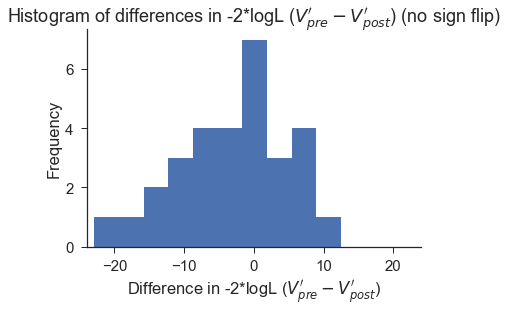

In [91]:
fopt=pickle.load(open("foptweightby_correct_incorrect.p","rb"))
sns.set(font_scale=1.5)
sns.set_style("white")
sns.set_style("ticks")
plt.hist(fopt.foptsamecorrectnosignflip*2-fopt.foptnextcorrectnosignflip*2,bins=10)
plt.xlim(-24,24)
plt.xlabel(r'Difference in -2*logL ($V^{\prime}_{pre} - V^{\prime}_{post}$)')
plt.ylabel('Frequency')
plt.title('Histogram of differences in -2*logL ($V^{\prime}_{pre} - V^{\prime}_{post}$) (no sign flip)')
sns.despine()
plt.show()